In [56]:
import os
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import Dataset
from PIL import Image
from google.colab import drive
import matplotlib.pyplot as plt
import cv2
from collections import Counter
from collections import defaultdict
import random
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [57]:
# If you want to use photos from google drive:
# 1. Open this link https://drive.google.com/drive/folders/1_U3udvWsm1bq6P_m8VUO9jDlGO14zPcl?usp=drive_link
# 2. Go to "Shared with me", right click on shared directory (photos) and click "Organize" -> "Add shortcut" -> "My drive"
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
folders_train = {
    "/content/drive/MyDrive/photos/train_val/amsterdam/database/images":"netherlands",
    "/content/drive/MyDrive/photos/train_val/amman/database/images":"jordan",
    "/content/drive/MyDrive/photos/train_val/budapest/database/images":"hungary",
    "/content/drive/MyDrive/photos/train_val/goa/query/images":"india",
    "/content/drive/MyDrive/photos/train_val/moscow/query/images":"russia",
    "/content/drive/MyDrive/photos/train_val/paris/query/images":"france",
    "/content/drive/MyDrive/photos/train_val/zurich/query/images":"switzerland",
    "/content/drive/MyDrive/photos/train_val/nairobi/database/images":"kenya",
    "/content/drive/MyDrive/photos/train_val/ottawa/database/images":"canada",
    "/content/drive/MyDrive/photos/train_val/toronto/database/images":"canada",
    "/content/drive/MyDrive/photos/train_val/trondheim/database/images":"norway",
    "/content/drive/MyDrive/photos/train_val/boston/database/images":"usa",
    "/content/drive/MyDrive/photos/train_val/phoenix/query/images":"usa",
    "/content/drive/MyDrive/photos/train_val/saopaulo/query/images":"brazil",
    "/content/drive/MyDrive/photos/train_val/tokyo/database/images":"japan",
    "/content/drive/MyDrive/photos/test/athens/query/images":"grece",
    "/content/drive/MyDrive/photos/test/bengaluru/query/images":"india",
    "/content/drive/MyDrive/photos/test/kampala/query/images":"uganda",
    "/content/drive/MyDrive/photos/test/stockholm/query/images":"switzerland"
}

country_to_continent = {
  "netherlands": "Europe",
  "jordan": "Asia",
  "hungary": "Europe",
  "india": "Asia",
  "russia": "Europe",
  "france": "Europe",
  "switzerland": "Europe",
  "kenya": "Africa",
  "canada": "North America",
  "norway": "Europe",
  "usa": "North America",
  "brazil": "South America",
  "japan": "Asia",
  "grece": "Europe",
  "uganda": "Africa",
}

def take_images(folders):
  all_image_paths = []
  i = 0
  for folder in folders.keys():
      print("Sprawdzam folder:", folder)
      for root, _, files in os.walk(folder):
          for file in files:
              if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                  full_path = os.path.join(root, file)
                  all_image_paths.append(full_path)
  return all_image_paths

def data_stats(full_train_dataset):
    country_labels = [full_train_dataset.targets_dict[path.rsplit('/', 1)[0]] for path in full_train_dataset.images_paths]
    continent_labels = [country_to_continent[full_train_dataset.targets_dict[path.rsplit('/', 1)[0]]]for path in full_train_dataset.images_paths]

    country_counts = Counter(country_labels)
    continent_counts = Counter(continent_labels)

    print("Liczba zdjęć treningowych:", len(full_train_dataset))
    print("\n")
    for country, count in country_counts.items():
        print(f"{country}: {count} obrazów")
    print("\n")
    for continent, count in continent_counts.items():
        print(f"{continent}: {count} obrazów")

def max_count_country(full_train_dataset):

    country_labels = [full_train_dataset.targets_dict[path.rsplit('/', 1)[0]] for path in full_train_dataset.images_paths]

    country_counts = Counter(country_labels)

    max_count = max([count for country, count in country_counts.items()])
    return max_count

class ImageDataset(Dataset):
    def __init__(self, images_paths, targets_dict, country_to_continent, transform=None):
        self.images_paths = images_paths
        self.transform = transform
        self.targets_dict = targets_dict
        self.country_to_continent = country_to_continent

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        image_path = self.images_paths[idx]
        image = Image.open(image_path).convert("RGB")
        target = self.targets_dict[image_path.rsplit('/',1)[0]]
        general_label = self.country_to_continent[target]

        if self.transform:
            image = self.transform(image)

        return image, target, general_label

In [149]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [60]:
# Rest a little, watch some TikToks, it will take up to 10 min
# Ignore warnings about Google Drive
# There are breaks in loading

train_files = take_images(folders_train) # 483601 files

Sprawdzam folder: /content/drive/MyDrive/photos/train_val/amsterdam/database/images
Sprawdzam folder: /content/drive/MyDrive/photos/train_val/amman/database/images
Sprawdzam folder: /content/drive/MyDrive/photos/train_val/budapest/database/images
Sprawdzam folder: /content/drive/MyDrive/photos/train_val/goa/query/images
Sprawdzam folder: /content/drive/MyDrive/photos/train_val/moscow/query/images
Sprawdzam folder: /content/drive/MyDrive/photos/train_val/paris/query/images
Sprawdzam folder: /content/drive/MyDrive/photos/train_val/zurich/query/images
Sprawdzam folder: /content/drive/MyDrive/photos/train_val/nairobi/database/images
Sprawdzam folder: /content/drive/MyDrive/photos/train_val/ottawa/database/images
Sprawdzam folder: /content/drive/MyDrive/photos/train_val/toronto/database/images
Sprawdzam folder: /content/drive/MyDrive/photos/train_val/trondheim/database/images
Sprawdzam folder: /content/drive/MyDrive/photos/train_val/boston/database/images
Sprawdzam folder: /content/drive/My

Liczba zdjęć treningowych: 483601


Struktura danych
Przykłady zdjęć


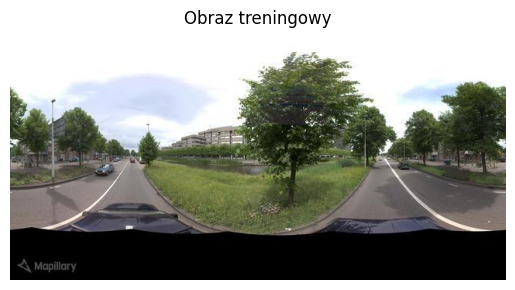

In [158]:
# <-- IMPORTANT INFO -->
# This code is used to investigate data
# You don't have to run it

print("Liczba zdjęć treningowych:", len(train_files))
print("\n")

print("Struktura danych")


print("Przykłady zdjęć")
img = cv2.imread(train_files[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title(f"Obraz treningowy")
plt.axis('off')
plt.show()

In [159]:
# <-- IMPORTANT INFO -->
# ImageDataset object returning 3 values - image, label (Country), general_label (continent)

# Important step - normalizing images
full_train_dataset = ImageDataset(train_files, folders_train, country_to_continent, transform=transform)

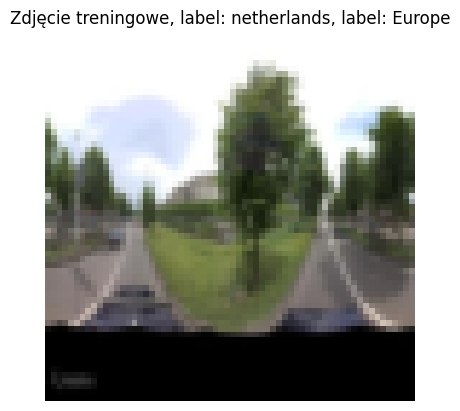

In [160]:
# <-- IMPORTANT INFO -->
# This code is used to investigate data
# You don't have to run it

image_train, label_train, general_label_train = full_train_dataset[0]
image_np_train = image_train.permute(1, 2, 0).numpy()

plt.imshow(image_np_train)
plt.title(f"Zdjęcie treningowe, label: {label_train}, label: {general_label_train}")
plt.axis('off')
plt.show()

In [161]:
data_stats(full_train_dataset)

Liczba zdjęć treningowych: 483601


netherlands: 11539 obrazów
jordan: 953 obrazów
hungary: 153321 obrazów
india: 12388 obrazów
russia: 77496 obrazów
france: 8480 obrazów
switzerland: 9012 obrazów
kenya: 437 obrazów
canada: 82545 obrazów
norway: 5015 obrazów
usa: 64267 obrazów
brazil: 18989 obrazów
japan: 34823 obrazów
grece: 2466 obrazów
uganda: 1870 obrazów


Europe: 267329 obrazów
Asia: 48164 obrazów
Africa: 2307 obrazów
North America: 146812 obrazów
South America: 18989 obrazów


In [ ]:
# <-- IMPORTANT INFO -->
# Jak można zobaczyć wyżej mamy problem z równomiernym rozkładem datasetu, szczególnie z danymi z Afryki
# Stworzyliśmy dataset z równomiernym rozkładem zdjęć z danych państw poprzez wyrzucenie losowych danych

In [ ]:
# Zanim dane zostaną zredukowane, można spróbować znaleźć inne zbiory danych np. z innych krajów lub dogenerować zdjęcia

#Code with augmentation

In [162]:
max_count = 437

In [163]:
def take_images_with_augmentation(folders,max_count):
  all_image_paths = []
  i = 0
  country_to_folder = {}
  for folder in folders.keys():
      if not folders[folder] in country_to_folder.keys():
          country_to_folder[folders[folder]] = []
      country_to_folder[folders[folder]].append(folder)

  for country in country_to_folder.keys():
      folder_images = []
      for folder in country_to_folder[country]:
        for root, _, files in os.walk(folder):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')): # Sprawdź rozszerzenia plików obrazów
                    full_path = os.path.join(root, file)
                    folder_images.append(full_path)
      if len(folder_images) < max_count:
          num_to_add = max_count - len(folder_images)
          additional_paths = random.choices(folder_images, k=num_to_add)
          folder_images.extend(additional_paths)
      all_image_paths.extend(folder_images)

  return all_image_paths
#is one of possibility to transform
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.ToTensor()
])

files_train_augmentation = take_images_with_augmentation(folders_train,max_count)
full_train_dataset_with_augmentation = ImageDataset(files_train_augmentation, folders_train, country_to_continent, transform=train_transform)

In [164]:
data_stats(full_train_dataset_with_augmentation )

Liczba zdjęć treningowych: 483601


netherlands: 11539 obrazów
jordan: 953 obrazów
hungary: 153321 obrazów
india: 12388 obrazów
russia: 77496 obrazów
france: 8480 obrazów
switzerland: 9012 obrazów
kenya: 437 obrazów
canada: 82545 obrazów
norway: 5015 obrazów
usa: 64267 obrazów
brazil: 18989 obrazów
japan: 34823 obrazów
grece: 2466 obrazów
uganda: 1870 obrazów


Europe: 267329 obrazów
Asia: 48164 obrazów
Africa: 2307 obrazów
North America: 146812 obrazów
South America: 18989 obrazów


In [165]:
def show_image(image_, label_, general_label_):
  image_np_train = image_.permute(1, 2, 0).numpy()
  plt.imshow(image_np_train)
  plt.title(f"Zdjęcie treningowe, label: {label_}, label: {general_label_}")
  plt.axis('off')
  plt.show()

In [166]:
train_len = int(0.8 * len(full_train_dataset_with_augmentation))
val_len = len(full_train_dataset_with_augmentation) - train_len
train_dataset, val_dataset_paths = random_split(full_train_dataset_with_augmentation, [train_len, val_len]) # Zwróć uwagę, że walidacyjny zbiór danych na tym etapie nie ma transformacji walidacyjnych

val_image_paths = [files_train_augmentation[i] for i in val_dataset_paths.indices]

val_dataset = ImageDataset(
    val_image_paths,
    targets_dict=full_train_dataset_with_augmentation.targets_dict,
    country_to_continent=full_train_dataset_with_augmentation.country_to_continent,
    transform=transform
)


train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=False
)

In [167]:
print("Liczba zdjęć treningowych:", len(train_dataset))
print("Liczba zdjęć walidacyjnych:", len(val_dataset))

Liczba zdjęć treningowych: 386880
Liczba zdjęć walidacyjnych: 96721


In [189]:
# Przycinanie danych

# 1. Zgrupuj indeksy po krajach
country_to_indices = defaultdict(list)

for idx, path in enumerate(full_train_dataset_with_augmentation.images_paths):
    country = full_train_dataset_with_augmentation.targets_dict[path.rsplit("/", 1)[0]]
    country_to_indices[country].append(idx)

# 2. Znajdź minimalną liczbę zdjęć dla kraju
min_count = min(len(indices) for indices in country_to_indices.values()) - 137
print(f"Minimalna liczba zdjęć w kraju: {min_count}")

# 3. Wybierz losowo min_count zdjęć z każdego kraju
balanced_indices = []

for indices in country_to_indices.values():
    balanced_indices.extend(random.sample(indices, min_count))

# 4. Zbuduj nową listę ścieżek
balanced_image_paths = [full_train_dataset_with_augmentation.images_paths[i] for i in balanced_indices]

# 5. Utwórz nowy zbalansowany ImageDataset
balanced_train_dataset = ImageDataset(
    balanced_image_paths,
    targets_dict=full_train_dataset_with_augmentation.targets_dict,
    country_to_continent=full_train_dataset_with_augmentation.country_to_continent,
    transform=full_train_dataset_with_augmentation.transform
)

print(f"Liczba obrazów po undersamplingu: {len(balanced_train_dataset)}")

Minimalna liczba zdjęć w kraju: 300
Liczba obrazów po undersamplingu: 4500


In [190]:
data_stats(balanced_train_dataset)

Liczba zdjęć treningowych: 4500


netherlands: 300 obrazów
jordan: 300 obrazów
hungary: 300 obrazów
india: 300 obrazów
russia: 300 obrazów
france: 300 obrazów
switzerland: 300 obrazów
kenya: 300 obrazów
canada: 300 obrazów
norway: 300 obrazów
usa: 300 obrazów
brazil: 300 obrazów
japan: 300 obrazów
grece: 300 obrazów
uganda: 300 obrazów


Europe: 2100 obrazów
Asia: 900 obrazów
Africa: 600 obrazów
North America: 600 obrazów
South America: 300 obrazów


In [191]:
# Split data to training dataset and validation dataset
train_len = int(0.8 * len(balanced_train_dataset))
val_len = len(balanced_train_dataset) - train_len
train_dataset, val_dataset = random_split(balanced_train_dataset, [train_len, val_len])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

num_epochs = 10

In [192]:
print("Liczba zdjęć treningowych:", len(train_dataset))
print("Liczba zdjęć walidacyjnych:", len(val_dataset))

Liczba zdjęć treningowych: 3600
Liczba zdjęć walidacyjnych: 900


# Ocr, do usunięcia

In [ ]:
# for i in range(200):
#   temp = train_dataset[i]
#   show_image(temp[0],f"id: {i} "+temp[1],temp[2])

In [ ]:
# !pip install easyocr

In [ ]:
# import torchvision
# import torchaudio
# import easyocr
# import numpy as np

In [ ]:
# example = train_dataset[10]

In [ ]:
# temp = (example[0] * 255).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
# gray = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray, 'gray')

In [ ]:
# all_languages = [
#     'abq', 'en'
# ]

# reader = easyocr.Reader(all_languages, gpu=False)

# results = reader.readtext(gray)

# for bbox, text, conf in results:
#     print(f"Text: {text} (Confidence: {conf:.2f})")

In [ ]:
# Można pisać model

# Model, torch

In [193]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()

        weight_decay = 0.005

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # nn.Conv2d(64, 128, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.Conv2d(128, 128, kernel_size=3),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.dropout1 = nn.Dropout(0.3)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(64, 512)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.dropout1(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x


In [194]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # mniejsza liczba kanałów
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)  # po 2x maxpool na 64x64 -> 16x16
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)  # 64->32
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # 32->16
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # spłaszcz
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [195]:
device = ('cpu' if not torch.cuda.is_available() else 'cuda')

num_classes = len(country_to_continent)
# model = CNNModel(num_classes).to(device)
model = SimpleCNN(num_classes).to(device)
# model = torch.compile(model)

print(device)

cpu


In [196]:
from torch.optim import Adam

lr = 1e-4

optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [198]:
num_epochs = 5

In [199]:
country_to_target = {
  "netherlands": 0,
  "jordan": 1,
  "hungary": 2,
  "india": 3,
  "russia": 4,
  "france": 5,
  "switzerland": 6,
  "kenya": 7,
  "canada": 8,
  "norway": 9,
  "usa": 10,
  "brazil": 11,
  "japan": 12,
  "grece": 13,
  "uganda": 14,
}

In [200]:
def labels_to_targets_helper(labels):
  temp = []
  for i in labels:
    temp.append(country_to_target[i])
  return torch.tensor(temp)

In [201]:
torch.cuda.empty_cache()

In [202]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [203]:
inputs, _, _ = next(iter(train_loader))
print(inputs[0].shape)

torch.Size([3, 64, 64])


In [204]:
from tqdm import tqdm

for epoch in range(num_epochs):
  model.train()
  train_loss = 0.0
  correct = 0
  total = 0

  for inputs, label, label_general in tqdm(train_loader):
    label = labels_to_targets_helper(label)
    # inputs = torch.stack([inputs[0], inputs[1]], dim=0)
    inputs, label = inputs.to(device), label.to(device)

    outputs = model(inputs)
    loss = criterion(outputs, label)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    train_loss += loss.item() * inputs.size(0)
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == label).sum().item()
    total += label.size(0)

    print(f"loss: {loss.item()}")

  train_loss /= total
  train_acc = correct / total

  # Validation
  model.eval()
  val_loss = 0.0
  correct_val = 0
  total_val = 0

  with torch.no_grad():
    for inputs, label, label_general in tqdm(val_loader):
      label = labels_to_targets_helper(label)
      # inputs = torch.stack([inputs[0], inputs[1]], dim=0)
      inputs, label = inputs.to(device), label.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, label)

      val_loss += loss.item() * inputs.size(0)
      _, predicted = torch.max(outputs, 1)
      correct_val += (predicted == label).sum().item()
      total_val += label.size(0)

  val_loss /= total_val
  val_acc = correct / total_val

  train_losses.append(train_loss)
  val_losses.append(val_loss)
  train_accuracies.append(train_acc)
  val_accuracies.append(val_acc)

  print(f"Epoch [{epoch+1}/{num_epochs}] | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

  0%|          | 1/450 [00:07<52:48,  7.06s/it]

loss: 2.6919894218444824


  0%|          | 2/450 [00:27<1:50:36, 14.81s/it]

loss: 2.7013604640960693


  1%|          | 3/450 [00:38<1:37:45, 13.12s/it]

loss: 2.698936939239502


  1%|          | 4/450 [00:47<1:26:48, 11.68s/it]

loss: 2.6889090538024902


  1%|          | 5/450 [00:54<1:13:11,  9.87s/it]

loss: 2.7333264350891113


  1%|▏         | 6/450 [01:06<1:17:43, 10.50s/it]

loss: 2.6929843425750732


  2%|▏         | 7/450 [01:13<1:10:41,  9.57s/it]

loss: 2.7464969158172607


  2%|▏         | 8/450 [01:22<1:08:08,  9.25s/it]

loss: 2.7476580142974854


  2%|▏         | 9/450 [01:35<1:16:14, 10.37s/it]

loss: 2.736642360687256


  2%|▏         | 10/450 [01:46<1:17:43, 10.60s/it]

loss: 2.748438596725464


  2%|▏         | 11/450 [01:52<1:06:51,  9.14s/it]

loss: 2.7606496810913086


  3%|▎         | 12/450 [02:01<1:06:03,  9.05s/it]

loss: 2.677835702896118


  3%|▎         | 13/450 [02:09<1:03:49,  8.76s/it]

loss: 2.748952865600586


  3%|▎         | 14/450 [02:17<1:03:21,  8.72s/it]

loss: 2.740600824356079


  3%|▎         | 15/450 [02:26<1:03:58,  8.82s/it]

loss: 2.715999126434326


  4%|▎         | 16/450 [02:36<1:05:03,  8.99s/it]

loss: 2.7028896808624268


  4%|▍         | 17/450 [02:46<1:07:12,  9.31s/it]

loss: 2.7060441970825195


  4%|▍         | 18/450 [02:53<1:02:36,  8.70s/it]

loss: 2.730539083480835


  4%|▍         | 19/450 [03:04<1:08:08,  9.49s/it]

loss: 2.7095680236816406


  4%|▍         | 20/450 [03:13<1:06:30,  9.28s/it]

loss: 2.7376251220703125


  5%|▍         | 21/450 [03:24<1:08:55,  9.64s/it]

loss: 2.7263245582580566


  5%|▍         | 22/450 [03:30<1:00:50,  8.53s/it]

loss: 2.6898608207702637


  5%|▌         | 23/450 [03:40<1:05:26,  9.20s/it]

loss: 2.7237274646759033


  5%|▌         | 24/450 [03:48<1:02:37,  8.82s/it]

loss: 2.7022528648376465


  6%|▌         | 25/450 [04:00<1:08:38,  9.69s/it]

loss: 2.649009943008423


  6%|▌         | 26/450 [04:08<1:05:09,  9.22s/it]

loss: 2.6863880157470703


  6%|▌         | 27/450 [04:15<1:00:14,  8.55s/it]

loss: 2.716221809387207


  6%|▌         | 28/450 [04:24<1:00:08,  8.55s/it]

loss: 2.6989240646362305


  6%|▋         | 29/450 [04:33<1:00:39,  8.65s/it]

loss: 2.683501720428467


  7%|▋         | 30/450 [04:37<52:11,  7.46s/it]  

loss: 2.7085351943969727


  7%|▋         | 31/450 [04:46<54:52,  7.86s/it]

loss: 2.7619783878326416


  7%|▋         | 32/450 [04:55<57:05,  8.20s/it]

loss: 2.7236673831939697


  7%|▋         | 33/450 [05:17<1:25:06, 12.25s/it]

loss: 2.678386688232422


  8%|▊         | 34/450 [05:26<1:18:38, 11.34s/it]

loss: 2.75394868850708


  8%|▊         | 35/450 [05:33<1:08:58,  9.97s/it]

loss: 2.6747307777404785


  8%|▊         | 36/450 [05:41<1:04:44,  9.38s/it]

loss: 2.7277979850769043


  8%|▊         | 37/450 [05:50<1:05:01,  9.45s/it]

loss: 2.70345139503479


  8%|▊         | 38/450 [05:59<1:02:20,  9.08s/it]

loss: 2.6856367588043213


  9%|▊         | 39/450 [06:06<57:49,  8.44s/it]  

loss: 2.705230474472046


  9%|▉         | 40/450 [06:17<1:03:41,  9.32s/it]

loss: 2.7480616569519043


  9%|▉         | 41/450 [06:28<1:06:19,  9.73s/it]

loss: 2.706873655319214


  9%|▉         | 42/450 [06:37<1:06:12,  9.74s/it]

loss: 2.6812381744384766


 10%|▉         | 43/450 [06:45<1:02:43,  9.25s/it]

loss: 2.7155675888061523


 10%|▉         | 44/450 [06:57<1:06:38,  9.85s/it]

loss: 2.711557388305664


 10%|█         | 45/450 [07:06<1:06:07,  9.80s/it]

loss: 2.7036571502685547


 10%|█         | 46/450 [07:13<59:05,  8.78s/it]  

loss: 2.732276439666748


 10%|█         | 47/450 [07:21<57:48,  8.61s/it]

loss: 2.745360851287842


 11%|█         | 48/450 [07:29<56:28,  8.43s/it]

loss: 2.7153401374816895


 11%|█         | 49/450 [07:37<55:57,  8.37s/it]

loss: 2.7167580127716064


 11%|█         | 50/450 [07:47<58:18,  8.75s/it]

loss: 2.6892926692962646


 11%|█▏        | 51/450 [07:54<55:13,  8.30s/it]

loss: 2.7016313076019287


 12%|█▏        | 52/450 [08:04<58:21,  8.80s/it]

loss: 2.737354278564453


 12%|█▏        | 53/450 [08:16<1:04:49,  9.80s/it]

loss: 2.6483635902404785


 12%|█▏        | 54/450 [08:21<53:52,  8.16s/it]  

loss: 2.696080207824707


 12%|█▏        | 55/450 [08:29<54:42,  8.31s/it]

loss: 2.660067558288574


 12%|█▏        | 56/450 [08:39<57:04,  8.69s/it]

loss: 2.7265028953552246


 13%|█▎        | 57/450 [08:45<51:20,  7.84s/it]

loss: 2.7234976291656494


 13%|█▎        | 58/450 [08:54<54:12,  8.30s/it]

loss: 2.6521401405334473


 13%|█▎        | 59/450 [09:03<55:42,  8.55s/it]

loss: 2.738039255142212


 13%|█▎        | 60/450 [09:11<54:58,  8.46s/it]

loss: 2.7237448692321777


 14%|█▎        | 61/450 [09:21<57:00,  8.79s/it]

loss: 2.7079849243164062


 14%|█▍        | 62/450 [09:30<57:54,  8.95s/it]

loss: 2.7190158367156982


 14%|█▍        | 63/450 [09:38<55:36,  8.62s/it]

loss: 2.6659886837005615


 14%|█▍        | 64/450 [09:47<55:53,  8.69s/it]

loss: 2.6983606815338135


 14%|█▍        | 65/450 [09:55<55:02,  8.58s/it]

loss: 2.7110373973846436


 15%|█▍        | 66/450 [10:05<56:55,  8.90s/it]

loss: 2.697505474090576


 15%|█▍        | 67/450 [10:13<54:54,  8.60s/it]

loss: 2.6761443614959717


 15%|█▌        | 68/450 [10:23<57:12,  8.99s/it]

loss: 2.723517417907715


 15%|█▌        | 69/450 [10:31<56:29,  8.90s/it]

loss: 2.7439424991607666


 16%|█▌        | 70/450 [10:38<52:17,  8.26s/it]

loss: 2.6992874145507812


 16%|█▌        | 71/450 [10:48<54:53,  8.69s/it]

loss: 2.6856043338775635


 16%|█▌        | 72/450 [10:57<55:16,  8.77s/it]

loss: 2.716392993927002


 16%|█▌        | 73/450 [11:06<55:45,  8.87s/it]

loss: 2.6830830574035645


 16%|█▋        | 74/450 [11:15<56:42,  9.05s/it]

loss: 2.712085723876953


 17%|█▋        | 75/450 [11:24<56:11,  8.99s/it]

loss: 2.692732810974121


 17%|█▋        | 76/450 [11:33<56:23,  9.05s/it]

loss: 2.6616082191467285


 17%|█▋        | 77/450 [11:44<58:58,  9.49s/it]

loss: 2.7035090923309326


 17%|█▋        | 78/450 [11:50<53:13,  8.58s/it]

loss: 2.7107179164886475


 18%|█▊        | 79/450 [11:57<49:15,  7.97s/it]

loss: 2.7274460792541504


 18%|█▊        | 80/450 [12:06<50:29,  8.19s/it]

loss: 2.7647087574005127


 18%|█▊        | 81/450 [12:14<50:25,  8.20s/it]

loss: 2.6457042694091797


 18%|█▊        | 82/450 [12:24<54:42,  8.92s/it]

loss: 2.7722551822662354


 18%|█▊        | 83/450 [12:33<53:59,  8.83s/it]

loss: 2.649840831756592


 19%|█▊        | 84/450 [12:41<52:58,  8.69s/it]

loss: 2.709113597869873


 19%|█▉        | 85/450 [12:51<54:13,  8.92s/it]

loss: 2.6815178394317627


 19%|█▉        | 86/450 [13:00<54:47,  9.03s/it]

loss: 2.6628577709198


 19%|█▉        | 87/450 [13:05<46:49,  7.74s/it]

loss: 2.684372901916504


 20%|█▉        | 88/450 [13:13<47:00,  7.79s/it]

loss: 2.681886911392212


 20%|█▉        | 89/450 [13:19<44:42,  7.43s/it]

loss: 2.6826469898223877


 20%|██        | 90/450 [13:27<44:36,  7.43s/it]

loss: 2.6848816871643066


 20%|██        | 91/450 [13:32<39:31,  6.60s/it]

loss: 2.7195863723754883


 20%|██        | 92/450 [13:41<43:37,  7.31s/it]

loss: 2.654667854309082


 21%|██        | 93/450 [13:51<49:21,  8.30s/it]

loss: 2.6526975631713867


 21%|██        | 94/450 [14:00<50:09,  8.45s/it]

loss: 2.753931999206543


 21%|██        | 95/450 [14:05<43:56,  7.43s/it]

loss: 2.6709811687469482


 21%|██▏       | 96/450 [14:13<44:50,  7.60s/it]

loss: 2.7607197761535645


 22%|██▏       | 97/450 [14:20<43:04,  7.32s/it]

loss: 2.6951651573181152


 22%|██▏       | 98/450 [14:27<43:53,  7.48s/it]

loss: 2.6645658016204834


 22%|██▏       | 99/450 [14:38<48:40,  8.32s/it]

loss: 2.7797656059265137


 22%|██▏       | 100/450 [14:48<51:35,  8.85s/it]

loss: 2.7296090126037598


 22%|██▏       | 101/450 [14:57<52:13,  8.98s/it]

loss: 2.7364840507507324


 23%|██▎       | 102/450 [15:06<51:09,  8.82s/it]

loss: 2.7045211791992188


 23%|██▎       | 103/450 [15:13<49:13,  8.51s/it]

loss: 2.69132661819458


 23%|██▎       | 104/450 [15:23<50:53,  8.83s/it]

loss: 2.6866908073425293


 23%|██▎       | 105/450 [15:31<48:36,  8.45s/it]

loss: 2.7309961318969727


 24%|██▎       | 106/450 [15:36<43:23,  7.57s/it]

loss: 2.694291114807129


 24%|██▍       | 107/450 [15:47<49:31,  8.66s/it]

loss: 2.710651159286499


 24%|██▍       | 108/450 [15:57<51:46,  9.08s/it]

loss: 2.7622690200805664


 24%|██▍       | 109/450 [16:03<45:08,  7.94s/it]

loss: 2.6699604988098145


 24%|██▍       | 110/450 [16:08<41:31,  7.33s/it]

loss: 2.714694023132324


 25%|██▍       | 111/450 [16:20<47:51,  8.47s/it]

loss: 2.6702911853790283


 25%|██▍       | 112/450 [16:29<49:27,  8.78s/it]

loss: 2.696690797805786


 25%|██▌       | 113/450 [16:39<51:46,  9.22s/it]

loss: 2.6939802169799805


 25%|██▌       | 114/450 [16:48<49:58,  8.92s/it]

loss: 2.7223258018493652


 26%|██▌       | 115/450 [16:55<47:04,  8.43s/it]

loss: 2.6481003761291504


 26%|██▌       | 116/450 [17:05<49:25,  8.88s/it]

loss: 2.706948757171631


 26%|██▌       | 117/450 [17:13<47:51,  8.62s/it]

loss: 2.7403557300567627


 26%|██▌       | 118/450 [17:22<47:59,  8.67s/it]

loss: 2.6823742389678955


 26%|██▋       | 119/450 [17:29<45:44,  8.29s/it]

loss: 2.7397279739379883


 27%|██▋       | 120/450 [17:37<44:48,  8.15s/it]

loss: 2.6939539909362793


 27%|██▋       | 121/450 [17:45<45:13,  8.25s/it]

loss: 2.747138261795044


 27%|██▋       | 122/450 [17:54<45:47,  8.38s/it]

loss: 2.7285664081573486


 27%|██▋       | 123/450 [18:04<48:52,  8.97s/it]

loss: 2.6942191123962402


 28%|██▊       | 124/450 [18:14<50:35,  9.31s/it]

loss: 2.7213661670684814


 28%|██▊       | 125/450 [18:26<53:23,  9.86s/it]

loss: 2.687418222427368


 28%|██▊       | 126/450 [18:35<52:48,  9.78s/it]

loss: 2.720168113708496


 28%|██▊       | 127/450 [18:44<51:51,  9.63s/it]

loss: 2.677300453186035


 28%|██▊       | 128/450 [18:53<50:02,  9.32s/it]

loss: 2.668912887573242


 29%|██▊       | 129/450 [19:04<52:52,  9.88s/it]

loss: 2.724515438079834


 29%|██▉       | 130/450 [19:14<51:55,  9.74s/it]

loss: 2.6750364303588867


 29%|██▉       | 131/450 [19:24<52:12,  9.82s/it]

loss: 2.699263572692871


 29%|██▉       | 132/450 [19:33<51:37,  9.74s/it]

loss: 2.7036540508270264


 30%|██▉       | 133/450 [19:43<52:13,  9.88s/it]

loss: 2.7368087768554688


 30%|██▉       | 134/450 [19:54<52:59, 10.06s/it]

loss: 2.739971399307251


 30%|███       | 135/450 [20:04<52:36, 10.02s/it]

loss: 2.6917777061462402


 30%|███       | 136/450 [20:10<46:27,  8.88s/it]

loss: 2.645617723464966


 30%|███       | 137/450 [20:19<46:24,  8.90s/it]

loss: 2.7308146953582764


 31%|███       | 138/450 [20:27<44:35,  8.58s/it]

loss: 2.6720941066741943


 31%|███       | 139/450 [20:34<41:45,  8.06s/it]

loss: 2.689030408859253


 31%|███       | 140/450 [20:42<42:40,  8.26s/it]

loss: 2.7269089221954346


 31%|███▏      | 141/450 [20:52<44:31,  8.65s/it]

loss: 2.727633476257324


 32%|███▏      | 142/450 [21:01<44:41,  8.71s/it]

loss: 2.7043709754943848


 32%|███▏      | 143/450 [21:09<43:29,  8.50s/it]

loss: 2.7074739933013916


 32%|███▏      | 144/450 [21:17<43:06,  8.45s/it]

loss: 2.711622476577759


 32%|███▏      | 145/450 [21:23<39:14,  7.72s/it]

loss: 2.675891399383545


 32%|███▏      | 146/450 [21:33<41:48,  8.25s/it]

loss: 2.7198057174682617


 33%|███▎      | 147/450 [21:44<45:51,  9.08s/it]

loss: 2.7243213653564453


 33%|███▎      | 148/450 [21:51<43:45,  8.69s/it]

loss: 2.6614959239959717


 33%|███▎      | 149/450 [21:58<40:02,  7.98s/it]

loss: 2.7092254161834717


 33%|███▎      | 150/450 [22:05<38:12,  7.64s/it]

loss: 2.6832213401794434


 34%|███▎      | 151/450 [22:21<50:38, 10.16s/it]

loss: 2.677612066268921


 34%|███▍      | 152/450 [22:27<44:28,  8.95s/it]

loss: 2.698085308074951


 34%|███▍      | 153/450 [22:32<39:06,  7.90s/it]

loss: 2.710897207260132


 34%|███▍      | 154/450 [22:37<34:53,  7.07s/it]

loss: 2.6330857276916504


 34%|███▍      | 155/450 [22:45<34:52,  7.09s/it]

loss: 2.680748224258423


 35%|███▍      | 156/450 [22:50<31:52,  6.50s/it]

loss: 2.6991755962371826


 35%|███▍      | 157/450 [22:57<33:03,  6.77s/it]

loss: 2.687584638595581


 35%|███▌      | 158/450 [23:04<32:51,  6.75s/it]

loss: 2.6865627765655518


 35%|███▌      | 159/450 [23:11<33:39,  6.94s/it]

loss: 2.71578049659729


 36%|███▌      | 160/450 [23:15<29:44,  6.15s/it]

loss: 2.6918985843658447


 36%|███▌      | 161/450 [23:23<32:10,  6.68s/it]

loss: 2.7342529296875


 36%|███▌      | 162/450 [23:29<31:02,  6.47s/it]

loss: 2.6751346588134766


 36%|███▌      | 163/450 [23:41<38:23,  8.03s/it]

loss: 2.6794705390930176


 36%|███▋      | 164/450 [24:08<1:05:09, 13.67s/it]

loss: 2.7685141563415527


 37%|███▋      | 165/450 [24:15<55:45, 11.74s/it]  

loss: 2.716719150543213


 37%|███▋      | 166/450 [24:33<1:04:06, 13.55s/it]

loss: 2.6949501037597656


 37%|███▋      | 167/450 [24:40<54:20, 11.52s/it]  

loss: 2.7388646602630615


 37%|███▋      | 168/450 [24:57<1:02:10, 13.23s/it]

loss: 2.7176854610443115


 38%|███▊      | 169/450 [25:02<50:22, 10.76s/it]  

loss: 2.669837474822998


 38%|███▊      | 170/450 [25:07<42:20,  9.07s/it]

loss: 2.690333843231201


 38%|███▊      | 171/450 [25:13<37:19,  8.03s/it]

loss: 2.69157075881958


 38%|███▊      | 172/450 [25:19<35:29,  7.66s/it]

loss: 2.7006916999816895


 38%|███▊      | 173/450 [25:27<34:41,  7.51s/it]

loss: 2.669217109680176


 39%|███▊      | 174/450 [25:33<33:29,  7.28s/it]

loss: 2.666985511779785


 39%|███▉      | 175/450 [25:41<33:25,  7.29s/it]

loss: 2.6728594303131104


 39%|███▉      | 176/450 [25:47<31:35,  6.92s/it]

loss: 2.6829817295074463


 39%|███▉      | 177/450 [25:55<32:52,  7.23s/it]

loss: 2.673140048980713


 40%|███▉      | 178/450 [26:01<31:07,  6.86s/it]

loss: 2.669315814971924


 40%|███▉      | 179/450 [26:07<29:54,  6.62s/it]

loss: 2.69695782661438


 40%|████      | 180/450 [26:13<29:15,  6.50s/it]

loss: 2.686738967895508


 40%|████      | 181/450 [26:21<30:58,  6.91s/it]

loss: 2.66672420501709


 40%|████      | 182/450 [26:27<30:05,  6.74s/it]

loss: 2.722179889678955


 41%|████      | 183/450 [26:34<29:39,  6.67s/it]

loss: 2.6866519451141357


 41%|████      | 184/450 [26:41<30:32,  6.89s/it]

loss: 2.705599546432495


 41%|████      | 185/450 [26:47<28:37,  6.48s/it]

loss: 2.671065330505371


 41%|████▏     | 186/450 [26:53<29:00,  6.59s/it]

loss: 2.682786226272583


 42%|████▏     | 187/450 [27:01<29:55,  6.83s/it]

loss: 2.7078466415405273


 42%|████▏     | 188/450 [27:09<31:03,  7.11s/it]

loss: 2.6799895763397217


 42%|████▏     | 189/450 [27:25<42:49,  9.84s/it]

loss: 2.6690902709960938


 42%|████▏     | 190/450 [27:31<38:07,  8.80s/it]

loss: 2.713977813720703


 42%|████▏     | 191/450 [27:38<35:21,  8.19s/it]

loss: 2.652447462081909


 43%|████▎     | 192/450 [27:45<33:59,  7.90s/it]

loss: 2.6627354621887207


 43%|████▎     | 193/450 [27:51<31:23,  7.33s/it]

loss: 2.7144172191619873


 43%|████▎     | 194/450 [28:06<41:20,  9.69s/it]

loss: 2.6972475051879883


 43%|████▎     | 195/450 [28:13<36:59,  8.71s/it]

loss: 2.7061426639556885


 44%|████▎     | 196/450 [28:17<31:16,  7.39s/it]

loss: 2.684051275253296


 44%|████▍     | 197/450 [28:25<31:21,  7.44s/it]

loss: 2.6991500854492188


 44%|████▍     | 198/450 [28:39<40:31,  9.65s/it]

loss: 2.7145121097564697


 44%|████▍     | 199/450 [28:57<50:12, 12.00s/it]

loss: 2.6824569702148438


 44%|████▍     | 200/450 [29:03<42:26, 10.19s/it]

loss: 2.6415534019470215


 45%|████▍     | 201/450 [29:11<39:33,  9.53s/it]

loss: 2.6595282554626465


 45%|████▍     | 202/450 [29:18<36:11,  8.76s/it]

loss: 2.7389883995056152


 45%|████▌     | 203/450 [29:27<36:18,  8.82s/it]

loss: 2.6776537895202637


 45%|████▌     | 204/450 [29:39<40:54,  9.98s/it]

loss: 2.6706628799438477


 46%|████▌     | 205/450 [29:46<36:18,  8.89s/it]

loss: 2.6484375


 46%|████▌     | 206/450 [29:53<33:43,  8.29s/it]

loss: 2.667022228240967


 46%|████▌     | 207/450 [30:00<32:16,  7.97s/it]

loss: 2.713088274002075


 46%|████▌     | 208/450 [30:06<29:41,  7.36s/it]

loss: 2.675445079803467


 46%|████▋     | 209/450 [30:12<27:51,  6.94s/it]

loss: 2.65641713142395


 47%|████▋     | 210/450 [30:20<29:06,  7.28s/it]

loss: 2.6486763954162598


 47%|████▋     | 211/450 [30:26<27:27,  6.89s/it]

loss: 2.600001335144043


 47%|████▋     | 212/450 [30:34<28:38,  7.22s/it]

loss: 2.6350700855255127


 47%|████▋     | 213/450 [30:41<28:25,  7.19s/it]

loss: 2.6392691135406494


 48%|████▊     | 214/450 [30:48<28:08,  7.16s/it]

loss: 2.628230094909668


 48%|████▊     | 215/450 [30:54<26:39,  6.81s/it]

loss: 2.700085163116455


 48%|████▊     | 216/450 [31:01<26:49,  6.88s/it]

loss: 2.6296725273132324


 48%|████▊     | 217/450 [31:07<25:44,  6.63s/it]

loss: 2.7057034969329834


 48%|████▊     | 218/450 [31:15<27:13,  7.04s/it]

loss: 2.636521100997925


 49%|████▊     | 219/450 [31:20<24:56,  6.48s/it]

loss: 2.6687610149383545


 49%|████▉     | 220/450 [31:27<25:40,  6.70s/it]

loss: 2.6443066596984863


 49%|████▉     | 221/450 [31:34<25:40,  6.73s/it]

loss: 2.6984870433807373


 49%|████▉     | 222/450 [31:41<25:08,  6.62s/it]

loss: 2.7228055000305176


 50%|████▉     | 223/450 [31:47<24:14,  6.41s/it]

loss: 2.5870931148529053


 50%|████▉     | 224/450 [31:55<26:01,  6.91s/it]

loss: 2.6219534873962402


 50%|█████     | 225/450 [32:01<24:49,  6.62s/it]

loss: 2.6582343578338623


 50%|█████     | 226/450 [32:09<26:25,  7.08s/it]

loss: 2.659146547317505


 50%|█████     | 227/450 [32:16<26:12,  7.05s/it]

loss: 2.7042319774627686


 51%|█████     | 228/450 [32:23<26:02,  7.04s/it]

loss: 2.640981674194336


 51%|█████     | 229/450 [32:29<24:46,  6.73s/it]

loss: 2.6254022121429443


 51%|█████     | 230/450 [32:36<25:13,  6.88s/it]

loss: 2.6867921352386475


 51%|█████▏    | 231/450 [32:42<24:10,  6.62s/it]

loss: 2.5823280811309814


 52%|█████▏    | 232/450 [32:50<25:30,  7.02s/it]

loss: 2.7559003829956055


 52%|█████▏    | 233/450 [32:55<23:29,  6.49s/it]

loss: 2.6381189823150635


 52%|█████▏    | 234/450 [33:02<23:15,  6.46s/it]

loss: 2.6651225090026855


 52%|█████▏    | 235/450 [33:08<23:24,  6.53s/it]

loss: 2.638376474380493


 52%|█████▏    | 236/450 [33:25<33:50,  9.49s/it]

loss: 2.6432056427001953


 53%|█████▎    | 237/450 [33:33<32:20,  9.11s/it]

loss: 2.756237030029297


 53%|█████▎    | 238/450 [33:48<38:55, 11.02s/it]

loss: 2.7742042541503906


 53%|█████▎    | 239/450 [33:55<34:29,  9.81s/it]

loss: 2.600144863128662


 53%|█████▎    | 240/450 [34:02<30:55,  8.83s/it]

loss: 2.67519474029541


 54%|█████▎    | 241/450 [34:14<33:42,  9.68s/it]

loss: 2.4371092319488525


 54%|█████▍    | 242/450 [34:20<30:12,  8.71s/it]

loss: 2.7635626792907715


 54%|█████▍    | 243/450 [34:27<28:24,  8.23s/it]

loss: 2.7162208557128906


 54%|█████▍    | 244/450 [34:34<26:25,  7.70s/it]

loss: 2.7008001804351807


 54%|█████▍    | 245/450 [34:40<25:03,  7.33s/it]

loss: 2.5354127883911133


 55%|█████▍    | 246/450 [34:46<23:43,  6.98s/it]

loss: 2.65649151802063


 55%|█████▍    | 247/450 [34:53<23:24,  6.92s/it]

loss: 2.670163631439209


 55%|█████▌    | 248/450 [35:05<28:44,  8.54s/it]

loss: 2.6235733032226562


 55%|█████▌    | 249/450 [35:12<26:25,  7.89s/it]

loss: 2.6637046337127686


 56%|█████▌    | 250/450 [35:23<29:48,  8.94s/it]

loss: 2.5360476970672607


 56%|█████▌    | 251/450 [35:28<26:07,  7.88s/it]

loss: 2.6082847118377686


 56%|█████▌    | 252/450 [35:35<24:52,  7.54s/it]

loss: 2.5578250885009766


 56%|█████▌    | 253/450 [35:41<22:47,  6.94s/it]

loss: 2.7258141040802


 56%|█████▋    | 254/450 [35:47<22:22,  6.85s/it]

loss: 2.6094141006469727


 57%|█████▋    | 255/450 [35:53<20:52,  6.42s/it]

loss: 2.687113046646118


 57%|█████▋    | 256/450 [35:57<18:37,  5.76s/it]

loss: 2.733985185623169


 57%|█████▋    | 257/450 [36:04<19:15,  5.99s/it]

loss: 2.767012119293213


 57%|█████▋    | 258/450 [36:16<24:58,  7.81s/it]

loss: 2.6812236309051514


 58%|█████▊    | 259/450 [36:22<23:15,  7.31s/it]

loss: 2.6796000003814697


 58%|█████▊    | 260/450 [36:28<22:34,  7.13s/it]

loss: 2.6170265674591064


 58%|█████▊    | 261/450 [36:35<21:41,  6.89s/it]

loss: 2.782017707824707


 58%|█████▊    | 262/450 [36:40<20:15,  6.46s/it]

loss: 2.616442918777466


 58%|█████▊    | 263/450 [36:47<20:26,  6.56s/it]

loss: 2.6182968616485596


 59%|█████▊    | 264/450 [36:59<25:43,  8.30s/it]

loss: 2.4244160652160645


 59%|█████▉    | 265/450 [37:10<27:28,  8.91s/it]

loss: 2.6656768321990967


 59%|█████▉    | 266/450 [37:26<33:43, 11.00s/it]

loss: 2.7933740615844727


 59%|█████▉    | 267/450 [37:40<36:46, 12.06s/it]

loss: 2.6807920932769775


 60%|█████▉    | 268/450 [37:45<29:55,  9.87s/it]

loss: 2.563922643661499


 60%|█████▉    | 269/450 [37:52<26:53,  8.92s/it]

loss: 2.6372127532958984


 60%|██████    | 270/450 [38:08<33:13, 11.08s/it]

loss: 2.6824538707733154


 60%|██████    | 271/450 [38:13<28:15,  9.47s/it]

loss: 2.5341529846191406


 60%|██████    | 272/450 [38:20<25:23,  8.56s/it]

loss: 2.629629135131836


 61%|██████    | 273/450 [38:26<23:08,  7.85s/it]

loss: 2.5188159942626953


 61%|██████    | 274/450 [38:34<22:44,  7.75s/it]

loss: 2.581144332885742


 61%|██████    | 275/450 [38:45<26:13,  8.99s/it]

loss: 2.5755481719970703


 61%|██████▏   | 276/450 [39:00<31:10, 10.75s/it]

loss: 2.624831199645996


 62%|██████▏   | 277/450 [39:11<31:13, 10.83s/it]

loss: 2.6293256282806396


 62%|██████▏   | 278/450 [39:19<28:42, 10.02s/it]

loss: 2.770155191421509


 62%|██████▏   | 279/450 [39:41<38:22, 13.46s/it]

loss: 2.756723165512085


 62%|██████▏   | 280/450 [40:06<47:39, 16.82s/it]

loss: 2.554251194000244


 62%|██████▏   | 281/450 [40:21<46:31, 16.52s/it]

loss: 2.6012582778930664


 63%|██████▎   | 282/450 [40:50<56:31, 20.19s/it]

loss: 2.751875638961792


 63%|██████▎   | 283/450 [41:13<58:23, 20.98s/it]

loss: 2.6562581062316895


 63%|██████▎   | 284/450 [41:33<56:55, 20.57s/it]

loss: 2.7851271629333496


 63%|██████▎   | 285/450 [41:57<59:21, 21.59s/it]

loss: 2.6751081943511963


 64%|██████▎   | 286/450 [42:14<55:57, 20.47s/it]

loss: 2.6577534675598145


 64%|██████▍   | 287/450 [42:40<59:38, 21.95s/it]

loss: 2.7317776679992676


 64%|██████▍   | 288/450 [43:03<1:00:07, 22.27s/it]

loss: 2.6982905864715576


 64%|██████▍   | 289/450 [43:33<1:05:46, 24.51s/it]

loss: 2.5788888931274414


 64%|██████▍   | 290/450 [44:02<1:09:01, 25.88s/it]

loss: 2.4876904487609863


 65%|██████▍   | 291/450 [44:24<1:05:59, 24.91s/it]

loss: 2.712566614151001


 65%|██████▍   | 292/450 [44:28<49:13, 18.69s/it]  

loss: 2.6116089820861816


 65%|██████▌   | 293/450 [44:34<38:32, 14.73s/it]

loss: 2.703026533126831


 65%|██████▌   | 294/450 [44:39<30:37, 11.78s/it]

loss: 2.558694839477539


 66%|██████▌   | 295/450 [44:45<25:43,  9.96s/it]

loss: 2.6506526470184326


 66%|██████▌   | 296/450 [44:51<22:54,  8.92s/it]

loss: 2.6377694606781006


 66%|██████▌   | 297/450 [44:57<20:03,  7.87s/it]

loss: 2.816706657409668


 66%|██████▌   | 298/450 [45:01<17:30,  6.91s/it]

loss: 2.581054210662842


 66%|██████▋   | 299/450 [45:07<16:16,  6.47s/it]

loss: 2.733369827270508


 67%|██████▋   | 300/450 [45:12<15:19,  6.13s/it]

loss: 2.6903440952301025


 67%|██████▋   | 301/450 [45:18<15:03,  6.07s/it]

loss: 2.7660446166992188


 67%|██████▋   | 302/450 [45:22<13:34,  5.50s/it]

loss: 2.693586587905884


 67%|██████▋   | 303/450 [45:26<12:31,  5.11s/it]

loss: 2.556150436401367


 68%|██████▊   | 304/450 [45:31<12:29,  5.14s/it]

loss: 2.7049758434295654


 68%|██████▊   | 305/450 [45:36<12:11,  5.05s/it]

loss: 2.600388526916504


 68%|██████▊   | 306/450 [45:43<12:58,  5.41s/it]

loss: 2.626593828201294


 68%|██████▊   | 307/450 [45:50<14:09,  5.94s/it]

loss: 2.648102283477783


 68%|██████▊   | 308/450 [45:55<13:22,  5.65s/it]

loss: 2.5880589485168457


 69%|██████▊   | 309/450 [46:01<13:28,  5.74s/it]

loss: 2.670992851257324


 69%|██████▉   | 310/450 [46:07<13:42,  5.87s/it]

loss: 2.607450008392334


 69%|██████▉   | 311/450 [46:13<13:35,  5.87s/it]

loss: 2.700854539871216


 69%|██████▉   | 312/450 [46:18<13:16,  5.77s/it]

loss: 2.5475916862487793


 70%|██████▉   | 313/450 [46:25<13:33,  5.94s/it]

loss: 2.681035280227661


 70%|██████▉   | 314/450 [46:30<13:25,  5.92s/it]

loss: 2.666149854660034


 70%|███████   | 315/450 [46:36<13:07,  5.83s/it]

loss: 2.6736650466918945


 70%|███████   | 316/450 [46:41<12:44,  5.71s/it]

loss: 2.536520481109619


 70%|███████   | 317/450 [46:46<12:03,  5.44s/it]

loss: 2.765558958053589


 71%|███████   | 318/450 [46:52<12:08,  5.52s/it]

loss: 2.604871988296509


 71%|███████   | 319/450 [46:58<12:35,  5.76s/it]

loss: 2.6147701740264893


 71%|███████   | 320/450 [47:04<12:17,  5.68s/it]

loss: 2.6757164001464844


 71%|███████▏  | 321/450 [47:10<12:28,  5.80s/it]

loss: 2.6266345977783203


 72%|███████▏  | 322/450 [47:16<12:37,  5.92s/it]

loss: 2.693474292755127


 72%|███████▏  | 323/450 [47:22<12:42,  6.00s/it]

loss: 2.6264209747314453


 72%|███████▏  | 324/450 [47:28<12:34,  5.99s/it]

loss: 2.5027408599853516


 72%|███████▏  | 325/450 [47:34<12:29,  6.00s/it]

loss: 2.729969024658203


 72%|███████▏  | 326/450 [47:39<11:35,  5.61s/it]

loss: 2.5867652893066406


 73%|███████▎  | 327/450 [47:45<11:31,  5.62s/it]

loss: 2.459677219390869


 73%|███████▎  | 328/450 [47:50<11:21,  5.59s/it]

loss: 2.671426296234131


 73%|███████▎  | 329/450 [47:57<11:46,  5.84s/it]

loss: 2.5851268768310547


 73%|███████▎  | 330/450 [48:02<11:44,  5.87s/it]

loss: 2.7231078147888184


 74%|███████▎  | 331/450 [48:08<11:31,  5.81s/it]

loss: 2.6120448112487793


 74%|███████▍  | 332/450 [48:13<10:55,  5.55s/it]

loss: 2.481776475906372


 74%|███████▍  | 333/450 [48:19<11:06,  5.70s/it]

loss: 2.6702518463134766


 74%|███████▍  | 334/450 [48:26<11:27,  5.93s/it]

loss: 2.6872260570526123


 74%|███████▍  | 335/450 [48:31<11:05,  5.79s/it]

loss: 2.5616397857666016


 75%|███████▍  | 336/450 [48:36<10:33,  5.56s/it]

loss: 2.5793144702911377


 75%|███████▍  | 337/450 [48:43<11:04,  5.88s/it]

loss: 2.5871829986572266


 75%|███████▌  | 338/450 [48:49<11:08,  5.97s/it]

loss: 2.484401226043701


 75%|███████▌  | 339/450 [48:53<10:13,  5.52s/it]

loss: 2.658557891845703


 76%|███████▌  | 340/450 [48:58<09:38,  5.26s/it]

loss: 2.6362462043762207


 76%|███████▌  | 341/450 [49:04<09:55,  5.46s/it]

loss: 2.694242000579834


 76%|███████▌  | 342/450 [49:08<09:08,  5.08s/it]

loss: 2.6342294216156006


 76%|███████▌  | 343/450 [49:14<09:28,  5.31s/it]

loss: 2.7059829235076904


 76%|███████▋  | 344/450 [49:20<09:47,  5.54s/it]

loss: 2.573118209838867


 77%|███████▋  | 345/450 [49:25<09:29,  5.43s/it]

loss: 2.793043851852417


 77%|███████▋  | 346/450 [49:31<09:22,  5.40s/it]

loss: 2.488990068435669


 77%|███████▋  | 347/450 [49:37<09:42,  5.66s/it]

loss: 2.599318504333496


 77%|███████▋  | 348/450 [49:43<09:37,  5.66s/it]

loss: 2.4210946559906006


 78%|███████▊  | 349/450 [49:47<08:57,  5.32s/it]

loss: 2.643636703491211


 78%|███████▊  | 350/450 [49:52<08:36,  5.16s/it]

loss: 2.589193820953369


 78%|███████▊  | 351/450 [49:59<09:38,  5.84s/it]

loss: 2.6235358715057373


 78%|███████▊  | 352/450 [50:05<09:29,  5.81s/it]

loss: 2.6509077548980713


 78%|███████▊  | 353/450 [50:12<09:56,  6.15s/it]

loss: 2.7216827869415283


 79%|███████▊  | 354/450 [50:18<09:49,  6.15s/it]

loss: 2.704263210296631


 79%|███████▉  | 355/450 [50:23<09:07,  5.76s/it]

loss: 2.429835319519043


 79%|███████▉  | 356/450 [50:28<08:50,  5.64s/it]

loss: 2.606949806213379


 79%|███████▉  | 357/450 [50:35<09:05,  5.87s/it]

loss: 2.5190179347991943


 80%|███████▉  | 358/450 [50:40<08:37,  5.63s/it]

loss: 2.39805269241333


 80%|███████▉  | 359/450 [50:44<08:06,  5.34s/it]

loss: 2.7233166694641113


 80%|████████  | 360/450 [50:51<08:21,  5.57s/it]

loss: 2.556142807006836


 80%|████████  | 361/450 [50:57<08:34,  5.78s/it]

loss: 2.584193468093872


 80%|████████  | 362/450 [51:02<08:18,  5.66s/it]

loss: 2.4189453125


 81%|████████  | 363/450 [51:08<08:16,  5.71s/it]

loss: 2.4689133167266846


 81%|████████  | 364/450 [51:14<08:12,  5.73s/it]

loss: 2.577332019805908


 81%|████████  | 365/450 [51:19<07:59,  5.64s/it]

loss: 2.505155086517334


 81%|████████▏ | 366/450 [51:23<07:10,  5.13s/it]

loss: 2.5664749145507812


 82%|████████▏ | 367/450 [51:29<07:35,  5.49s/it]

loss: 2.737525224685669


 82%|████████▏ | 368/450 [51:35<07:37,  5.58s/it]

loss: 2.605445384979248


 82%|████████▏ | 369/450 [51:38<06:34,  4.87s/it]

loss: 2.5232725143432617


 82%|████████▏ | 370/450 [51:44<06:33,  4.92s/it]

loss: 2.7334561347961426


 82%|████████▏ | 371/450 [51:50<06:57,  5.28s/it]

loss: 2.75648832321167


 83%|████████▎ | 372/450 [51:56<07:11,  5.53s/it]

loss: 2.6719415187835693


 83%|████████▎ | 373/450 [52:00<06:32,  5.09s/it]

loss: 2.408165454864502


 83%|████████▎ | 374/450 [52:04<06:14,  4.92s/it]

loss: 2.5523083209991455


 83%|████████▎ | 375/450 [52:10<06:33,  5.25s/it]

loss: 2.3928332328796387


 84%|████████▎ | 376/450 [52:16<06:31,  5.29s/it]

loss: 2.5395262241363525


 84%|████████▍ | 377/450 [52:21<06:32,  5.38s/it]

loss: 2.653517484664917


 84%|████████▍ | 378/450 [52:26<06:16,  5.23s/it]

loss: 2.390937566757202


 84%|████████▍ | 379/450 [52:33<06:36,  5.59s/it]

loss: 2.5287156105041504


 84%|████████▍ | 380/450 [52:39<06:40,  5.72s/it]

loss: 2.7076852321624756


 85%|████████▍ | 381/450 [52:42<05:43,  4.97s/it]

loss: 2.64357328414917


 85%|████████▍ | 382/450 [52:48<05:59,  5.28s/it]

loss: 2.656963586807251


 85%|████████▌ | 383/450 [52:52<05:26,  4.88s/it]

loss: 2.419583559036255


 85%|████████▌ | 384/450 [52:57<05:36,  5.09s/it]

loss: 2.5508975982666016


 86%|████████▌ | 385/450 [53:03<05:38,  5.21s/it]

loss: 2.7481207847595215


 86%|████████▌ | 386/450 [53:08<05:27,  5.12s/it]

loss: 2.504263162612915


 86%|████████▌ | 387/450 [53:12<05:02,  4.81s/it]

loss: 2.5249476432800293


 86%|████████▌ | 388/450 [53:18<05:20,  5.17s/it]

loss: 2.5255959033966064


 86%|████████▋ | 389/450 [53:24<05:27,  5.36s/it]

loss: 2.603510856628418


 87%|████████▋ | 390/450 [53:30<05:34,  5.57s/it]

loss: 2.592473030090332


 87%|████████▋ | 391/450 [53:35<05:19,  5.41s/it]

loss: 2.575852870941162


 87%|████████▋ | 392/450 [53:40<05:08,  5.33s/it]

loss: 2.5714468955993652


 87%|████████▋ | 393/450 [53:47<05:29,  5.79s/it]

loss: 2.3874573707580566


 88%|████████▊ | 394/450 [53:53<05:36,  6.01s/it]

loss: 2.6712985038757324


 88%|████████▊ | 395/450 [54:00<05:33,  6.06s/it]

loss: 2.6509101390838623


 88%|████████▊ | 396/450 [54:05<05:17,  5.87s/it]

loss: 2.56208872795105


 88%|████████▊ | 397/450 [54:10<05:03,  5.72s/it]

loss: 2.6147382259368896


 88%|████████▊ | 398/450 [54:17<05:05,  5.88s/it]

loss: 2.599977970123291


 89%|████████▊ | 399/450 [54:22<04:49,  5.67s/it]

loss: 2.6246092319488525


 89%|████████▉ | 400/450 [54:27<04:31,  5.44s/it]

loss: 2.6340532302856445


 89%|████████▉ | 401/450 [54:33<04:41,  5.75s/it]

loss: 2.691476345062256


 89%|████████▉ | 402/450 [54:39<04:39,  5.82s/it]

loss: 2.6133642196655273


 90%|████████▉ | 403/450 [54:44<04:22,  5.60s/it]

loss: 2.544766426086426


 90%|████████▉ | 404/450 [54:51<04:32,  5.93s/it]

loss: 2.637777090072632


 90%|█████████ | 405/450 [54:58<04:36,  6.15s/it]

loss: 2.4777672290802


 90%|█████████ | 406/450 [55:03<04:16,  5.82s/it]

loss: 2.3130745887756348


 90%|█████████ | 407/450 [55:09<04:11,  5.85s/it]

loss: 2.628559112548828


 91%|█████████ | 408/450 [55:14<04:01,  5.74s/it]

loss: 2.770444631576538


 91%|█████████ | 409/450 [55:20<03:57,  5.80s/it]

loss: 2.814288854598999


 91%|█████████ | 410/450 [55:26<03:58,  5.95s/it]

loss: 2.4383978843688965


 91%|█████████▏| 411/450 [55:30<03:28,  5.35s/it]

loss: 2.5385565757751465


 92%|█████████▏| 412/450 [55:35<03:17,  5.19s/it]

loss: 2.758476495742798


 92%|█████████▏| 413/450 [55:41<03:23,  5.50s/it]

loss: 2.6848185062408447


 92%|█████████▏| 414/450 [55:47<03:16,  5.46s/it]

loss: 2.5991034507751465


 92%|█████████▏| 415/450 [55:51<03:01,  5.18s/it]

loss: 2.7742128372192383


 92%|█████████▏| 416/450 [55:57<03:04,  5.42s/it]

loss: 2.6295549869537354


 93%|█████████▎| 417/450 [56:02<02:56,  5.35s/it]

loss: 2.7226383686065674


 93%|█████████▎| 418/450 [56:07<02:48,  5.27s/it]

loss: 2.416530132293701


 93%|█████████▎| 419/450 [56:13<02:43,  5.26s/it]

loss: 2.7058258056640625


 93%|█████████▎| 420/450 [56:16<02:25,  4.84s/it]

loss: 2.6796700954437256


 94%|█████████▎| 421/450 [56:31<03:40,  7.61s/it]

loss: 2.577082872390747


 94%|█████████▍| 422/450 [56:36<03:11,  6.83s/it]

loss: 2.3720948696136475


 94%|█████████▍| 423/450 [56:40<02:44,  6.11s/it]

loss: 2.5813074111938477


 94%|█████████▍| 424/450 [56:45<02:32,  5.86s/it]

loss: 2.4885213375091553


 94%|█████████▍| 425/450 [56:50<02:17,  5.52s/it]

loss: 2.545921802520752


 95%|█████████▍| 426/450 [56:56<02:14,  5.60s/it]

loss: 2.6907436847686768


 95%|█████████▍| 427/450 [57:01<02:08,  5.59s/it]

loss: 2.622180223464966


 95%|█████████▌| 428/450 [57:07<02:05,  5.71s/it]

loss: 2.4923417568206787


 95%|█████████▌| 429/450 [57:13<01:59,  5.67s/it]

loss: 2.578667402267456


 96%|█████████▌| 430/450 [57:18<01:48,  5.43s/it]

loss: 2.326073169708252


 96%|█████████▌| 431/450 [57:22<01:38,  5.20s/it]

loss: 2.5351359844207764


 96%|█████████▌| 432/450 [57:28<01:35,  5.28s/it]

loss: 2.821185827255249


 96%|█████████▌| 433/450 [57:34<01:35,  5.64s/it]

loss: 2.6777572631835938


 96%|█████████▋| 434/450 [57:39<01:26,  5.42s/it]

loss: 2.5094313621520996


 97%|█████████▋| 435/450 [57:43<01:14,  4.94s/it]

loss: 2.4856207370758057


 97%|█████████▋| 436/450 [57:49<01:11,  5.13s/it]

loss: 2.472869873046875


 97%|█████████▋| 437/450 [57:54<01:08,  5.27s/it]

loss: 2.442903518676758


 97%|█████████▋| 438/450 [57:59<01:00,  5.04s/it]

loss: 2.427189350128174


 98%|█████████▊| 439/450 [58:05<01:00,  5.47s/it]

loss: 2.6584279537200928


 98%|█████████▊| 440/450 [58:12<00:57,  5.76s/it]

loss: 2.5576748847961426


 98%|█████████▊| 441/450 [58:17<00:51,  5.74s/it]

loss: 2.5160317420959473


 98%|█████████▊| 442/450 [58:23<00:46,  5.77s/it]

loss: 2.604079246520996


 98%|█████████▊| 443/450 [58:29<00:41,  5.88s/it]

loss: 2.5367674827575684


 99%|█████████▊| 444/450 [58:35<00:35,  5.90s/it]

loss: 2.369990110397339


 99%|█████████▉| 445/450 [58:41<00:28,  5.72s/it]

loss: 2.8030073642730713


 99%|█████████▉| 446/450 [58:46<00:22,  5.52s/it]

loss: 2.770240306854248


 99%|█████████▉| 447/450 [58:51<00:16,  5.53s/it]

loss: 2.4867682456970215


100%|█████████▉| 448/450 [58:55<00:09,  4.96s/it]

loss: 2.398604154586792


100%|█████████▉| 449/450 [59:00<00:04,  4.97s/it]

loss: 2.577877998352051


100%|██████████| 450/450 [59:05<00:00,  7.88s/it]


loss: 2.4199507236480713


100%|██████████| 113/113 [10:20<00:00,  5.49s/it]


Epoch [1/5] | Train Loss: 2.6554, Train Acc: 0.1292 | Val Loss: 2.5522, Val Acc: 0.5167


  0%|          | 1/450 [00:00<02:41,  2.78it/s]

loss: 2.4848334789276123


  0%|          | 2/450 [00:00<02:47,  2.67it/s]

loss: 2.4353017807006836


  1%|          | 3/450 [00:01<02:51,  2.61it/s]

loss: 2.5443782806396484


  1%|          | 4/450 [00:01<03:19,  2.24it/s]

loss: 2.649409770965576


  1%|          | 5/450 [00:02<03:25,  2.16it/s]

loss: 2.7035117149353027


  1%|▏         | 6/450 [00:02<03:36,  2.05it/s]

loss: 2.5802009105682373


  2%|▏         | 7/450 [00:03<03:42,  1.99it/s]

loss: 2.4960098266601562


  2%|▏         | 8/450 [00:03<03:41,  2.00it/s]

loss: 2.477722406387329


  2%|▏         | 9/450 [00:04<03:44,  1.96it/s]

loss: 2.5033955574035645


  2%|▏         | 10/450 [00:04<03:51,  1.90it/s]

loss: 2.4355664253234863


  2%|▏         | 11/450 [00:05<03:33,  2.05it/s]

loss: 2.390793800354004


  3%|▎         | 12/450 [00:05<03:14,  2.26it/s]

loss: 2.7027807235717773


  3%|▎         | 13/450 [00:05<03:03,  2.38it/s]

loss: 2.595933675765991


  3%|▎         | 14/450 [00:06<02:51,  2.54it/s]

loss: 2.488367795944214


  3%|▎         | 15/450 [00:06<02:51,  2.53it/s]

loss: 2.6417813301086426


  4%|▎         | 16/450 [00:07<02:45,  2.63it/s]

loss: 2.5149099826812744


  4%|▍         | 17/450 [00:07<02:45,  2.61it/s]

loss: 2.3121178150177


  4%|▍         | 18/450 [00:07<02:41,  2.67it/s]

loss: 2.3838460445404053


  4%|▍         | 19/450 [00:08<02:41,  2.67it/s]

loss: 2.21415114402771


  4%|▍         | 20/450 [00:08<02:39,  2.70it/s]

loss: 2.4582810401916504


  5%|▍         | 21/450 [00:08<02:39,  2.69it/s]

loss: 2.5483524799346924


  5%|▍         | 22/450 [00:09<02:36,  2.74it/s]

loss: 2.518848419189453


  5%|▌         | 23/450 [00:09<02:35,  2.74it/s]

loss: 2.6315817832946777


  5%|▌         | 24/450 [00:09<02:37,  2.71it/s]

loss: 2.7549734115600586


  6%|▌         | 25/450 [00:10<02:31,  2.80it/s]

loss: 2.431333065032959


  6%|▌         | 26/450 [00:10<02:31,  2.81it/s]

loss: 2.636671543121338


  6%|▌         | 27/450 [00:11<02:34,  2.74it/s]

loss: 2.692274570465088


  6%|▌         | 28/450 [00:11<02:33,  2.75it/s]

loss: 2.4262983798980713


  6%|▋         | 29/450 [00:11<02:34,  2.72it/s]

loss: 2.573221445083618


  7%|▋         | 30/450 [00:12<02:33,  2.74it/s]

loss: 2.4013097286224365


  7%|▋         | 31/450 [00:12<02:30,  2.78it/s]

loss: 2.678499221801758


  7%|▋         | 32/450 [00:12<02:28,  2.81it/s]

loss: 2.3573484420776367


  7%|▋         | 33/450 [00:13<02:27,  2.83it/s]

loss: 2.3805809020996094


  8%|▊         | 34/450 [00:13<02:24,  2.88it/s]

loss: 2.64846134185791


  8%|▊         | 35/450 [00:13<02:29,  2.78it/s]

loss: 2.4668495655059814


  8%|▊         | 36/450 [00:14<02:32,  2.72it/s]

loss: 2.5588691234588623


  8%|▊         | 37/450 [00:14<02:32,  2.70it/s]

loss: 2.501281976699829


  8%|▊         | 38/450 [00:15<02:37,  2.62it/s]

loss: 2.770831346511841


  9%|▊         | 39/450 [00:15<02:49,  2.42it/s]

loss: 2.2099146842956543


  9%|▉         | 40/450 [00:16<02:59,  2.28it/s]

loss: 2.3481285572052


  9%|▉         | 41/450 [00:16<03:06,  2.20it/s]

loss: 2.5026602745056152


  9%|▉         | 42/450 [00:17<03:14,  2.10it/s]

loss: 2.372990131378174


 10%|▉         | 43/450 [00:17<03:22,  2.01it/s]

loss: 2.452633857727051


 10%|▉         | 44/450 [00:18<03:21,  2.02it/s]

loss: 2.5756664276123047


 10%|█         | 45/450 [00:18<03:23,  1.99it/s]

loss: 2.604726552963257


 10%|█         | 46/450 [00:19<03:12,  2.09it/s]

loss: 2.294337749481201


 10%|█         | 47/450 [00:19<02:58,  2.26it/s]

loss: 2.42155122756958


 11%|█         | 48/450 [00:19<02:48,  2.38it/s]

loss: 2.2725350856781006


 11%|█         | 49/450 [00:20<02:38,  2.53it/s]

loss: 2.2028512954711914


 11%|█         | 50/450 [00:20<02:33,  2.60it/s]

loss: 2.486769914627075


 11%|█▏        | 51/450 [00:20<02:32,  2.62it/s]

loss: 2.8691043853759766


 12%|█▏        | 52/450 [00:21<02:32,  2.61it/s]

loss: 2.540269136428833


 12%|█▏        | 53/450 [00:21<02:29,  2.66it/s]

loss: 2.52763295173645


 12%|█▏        | 54/450 [00:21<02:25,  2.71it/s]

loss: 2.8506875038146973


 12%|█▏        | 55/450 [00:22<02:23,  2.75it/s]

loss: 2.3882317543029785


 12%|█▏        | 56/450 [00:22<02:25,  2.71it/s]

loss: 2.5885729789733887


 13%|█▎        | 57/450 [00:23<02:27,  2.67it/s]

loss: 2.5313661098480225


 13%|█▎        | 58/450 [00:23<02:24,  2.71it/s]

loss: 2.6427066326141357


 13%|█▎        | 59/450 [00:23<02:22,  2.74it/s]

loss: 2.6930155754089355


 13%|█▎        | 60/450 [00:24<02:25,  2.69it/s]

loss: 2.349640369415283


 14%|█▎        | 61/450 [00:24<02:21,  2.75it/s]

loss: 2.393860340118408


 14%|█▍        | 62/450 [00:24<02:21,  2.73it/s]

loss: 2.222867012023926


 14%|█▍        | 63/450 [00:25<02:23,  2.69it/s]

loss: 2.5551605224609375


 14%|█▍        | 64/450 [00:25<02:22,  2.71it/s]

loss: 2.6184940338134766


 14%|█▍        | 65/450 [00:25<02:19,  2.76it/s]

loss: 2.4940595626831055


 15%|█▍        | 66/450 [00:26<02:19,  2.75it/s]

loss: 2.5822243690490723


 15%|█▍        | 67/450 [00:26<02:23,  2.66it/s]

loss: 2.5914759635925293


 15%|█▌        | 68/450 [00:27<02:23,  2.67it/s]

loss: 2.4733314514160156


 15%|█▌        | 69/450 [00:27<02:19,  2.72it/s]

loss: 2.5025455951690674


 16%|█▌        | 70/450 [00:27<02:21,  2.69it/s]

loss: 2.3087828159332275


 16%|█▌        | 71/450 [00:28<02:22,  2.66it/s]

loss: 2.3584697246551514


 16%|█▌        | 72/450 [00:28<02:19,  2.70it/s]

loss: 2.3480825424194336


 16%|█▌        | 73/450 [00:28<02:24,  2.62it/s]

loss: 2.4111311435699463


 16%|█▋        | 74/450 [00:29<02:37,  2.38it/s]

loss: 2.4727590084075928


 17%|█▋        | 75/450 [00:30<02:51,  2.18it/s]

loss: 2.6086621284484863


 17%|█▋        | 76/450 [00:30<03:02,  2.05it/s]

loss: 2.688933849334717


 17%|█▋        | 77/450 [00:31<03:08,  1.98it/s]

loss: 2.7897491455078125


 17%|█▋        | 78/450 [00:31<03:10,  1.95it/s]

loss: 2.432690143585205


 18%|█▊        | 79/450 [00:32<03:09,  1.96it/s]

loss: 2.5207273960113525


 18%|█▊        | 80/450 [00:32<03:07,  1.97it/s]

loss: 2.4856855869293213


 18%|█▊        | 81/450 [00:33<02:57,  2.08it/s]

loss: 2.3502602577209473


 18%|█▊        | 82/450 [00:33<02:42,  2.26it/s]

loss: 2.686702251434326


 18%|█▊        | 83/450 [00:33<02:36,  2.35it/s]

loss: 2.536425828933716


 19%|█▊        | 84/450 [00:34<02:31,  2.41it/s]

loss: 2.5569324493408203


 19%|█▉        | 85/450 [00:34<02:28,  2.45it/s]

loss: 2.584676504135132


 19%|█▉        | 86/450 [00:34<02:22,  2.56it/s]

loss: 2.348741292953491


 19%|█▉        | 87/450 [00:35<02:19,  2.61it/s]

loss: 2.6363637447357178


 20%|█▉        | 88/450 [00:35<02:14,  2.70it/s]

loss: 2.5539519786834717


 20%|█▉        | 89/450 [00:36<02:12,  2.72it/s]

loss: 2.404963493347168


 20%|██        | 90/450 [00:36<02:13,  2.70it/s]

loss: 2.706324577331543


 20%|██        | 91/450 [00:36<02:09,  2.78it/s]

loss: 2.1570329666137695


 20%|██        | 92/450 [00:37<02:09,  2.76it/s]

loss: 2.419548511505127


 21%|██        | 93/450 [00:37<02:11,  2.71it/s]

loss: 2.1542415618896484


 21%|██        | 94/450 [00:37<02:07,  2.79it/s]

loss: 2.398280143737793


 21%|██        | 95/450 [00:38<02:08,  2.76it/s]

loss: 2.4468820095062256


 21%|██▏       | 96/450 [00:38<02:05,  2.81it/s]

loss: 2.283074140548706


 22%|██▏       | 97/450 [00:38<02:04,  2.83it/s]

loss: 2.493529796600342


 22%|██▏       | 98/450 [00:39<02:07,  2.76it/s]

loss: 2.502368450164795


 22%|██▏       | 99/450 [00:39<02:05,  2.80it/s]

loss: 2.395054817199707


 22%|██▏       | 100/450 [00:39<02:05,  2.80it/s]

loss: 2.3610410690307617


 22%|██▏       | 101/450 [00:40<02:10,  2.68it/s]

loss: 2.6487534046173096


 23%|██▎       | 102/450 [00:40<02:08,  2.71it/s]

loss: 2.657275438308716


 23%|██▎       | 103/450 [00:41<02:04,  2.78it/s]

loss: 2.431169033050537


 23%|██▎       | 104/450 [00:41<02:04,  2.77it/s]

loss: 2.3981518745422363


 23%|██▎       | 105/450 [00:41<02:04,  2.78it/s]

loss: 2.408327102661133


 24%|██▎       | 106/450 [00:42<02:04,  2.76it/s]

loss: 2.5260560512542725


 24%|██▍       | 107/450 [00:42<02:02,  2.81it/s]

loss: 2.4521021842956543


 24%|██▍       | 108/450 [00:42<02:02,  2.79it/s]

loss: 2.5008509159088135


 24%|██▍       | 109/450 [00:43<02:18,  2.46it/s]

loss: 2.275954008102417


 24%|██▍       | 110/450 [00:43<02:26,  2.32it/s]

loss: 2.453061819076538


 25%|██▍       | 111/450 [00:44<02:38,  2.14it/s]

loss: 2.5992703437805176


 25%|██▍       | 112/450 [00:44<02:44,  2.06it/s]

loss: 2.6085593700408936


 25%|██▌       | 113/450 [00:45<02:45,  2.03it/s]

loss: 2.5970118045806885


 25%|██▌       | 114/450 [00:45<02:45,  2.03it/s]

loss: 2.6316287517547607


 26%|██▌       | 115/450 [00:46<02:48,  1.98it/s]

loss: 2.3967814445495605


 26%|██▌       | 116/450 [00:46<02:44,  2.03it/s]

loss: 2.558415412902832


 26%|██▌       | 117/450 [00:47<02:31,  2.20it/s]

loss: 2.921842575073242


 26%|██▌       | 118/450 [00:47<02:19,  2.38it/s]

loss: 2.507925271987915


 26%|██▋       | 119/450 [00:48<02:11,  2.51it/s]

loss: 2.4156134128570557


 27%|██▋       | 120/450 [00:48<02:04,  2.65it/s]

loss: 2.505462169647217


 27%|██▋       | 121/450 [00:48<02:02,  2.69it/s]

loss: 2.358717203140259


 27%|██▋       | 122/450 [00:49<02:03,  2.67it/s]

loss: 2.708937883377075


 27%|██▋       | 123/450 [00:49<02:00,  2.72it/s]

loss: 2.7166595458984375


 28%|██▊       | 124/450 [00:49<01:59,  2.73it/s]

loss: 2.5046331882476807


 28%|██▊       | 125/450 [00:50<02:00,  2.69it/s]

loss: 2.358886241912842


 28%|██▊       | 126/450 [00:50<01:59,  2.72it/s]

loss: 2.5490856170654297


 28%|██▊       | 127/450 [00:50<01:58,  2.74it/s]

loss: 2.6196401119232178


 28%|██▊       | 128/450 [00:51<01:56,  2.77it/s]

loss: 2.2643380165100098


 29%|██▊       | 129/450 [00:51<01:54,  2.80it/s]

loss: 2.6800222396850586


 29%|██▉       | 130/450 [00:51<01:55,  2.77it/s]

loss: 2.6020469665527344


 29%|██▉       | 131/450 [00:52<01:50,  2.89it/s]

loss: 2.4185473918914795


 29%|██▉       | 132/450 [00:52<01:52,  2.82it/s]

loss: 2.5613980293273926


 30%|██▉       | 133/450 [00:53<01:53,  2.79it/s]

loss: 2.370866537094116


 30%|██▉       | 134/450 [00:53<01:52,  2.81it/s]

loss: 2.242326259613037


 30%|███       | 135/450 [00:53<01:53,  2.78it/s]

loss: 2.5197830200195312


 30%|███       | 136/450 [00:54<01:54,  2.74it/s]

loss: 2.414094924926758


 30%|███       | 137/450 [00:54<01:52,  2.77it/s]

loss: 2.4813809394836426


 31%|███       | 138/450 [00:54<01:50,  2.83it/s]

loss: 2.090298891067505


 31%|███       | 139/450 [00:55<01:51,  2.79it/s]

loss: 2.535900115966797


 31%|███       | 140/450 [00:55<01:55,  2.68it/s]

loss: 2.4941751956939697


 31%|███▏      | 141/450 [00:55<01:52,  2.74it/s]

loss: 2.5211164951324463


 32%|███▏      | 142/450 [00:56<01:53,  2.72it/s]

loss: 2.26235032081604


 32%|███▏      | 143/450 [00:56<01:52,  2.74it/s]

loss: 2.6705284118652344


 32%|███▏      | 144/450 [00:57<01:56,  2.62it/s]

loss: 2.542182683944702


 32%|███▏      | 145/450 [00:57<02:10,  2.33it/s]

loss: 2.1420602798461914


 32%|███▏      | 146/450 [00:58<02:18,  2.20it/s]

loss: 2.2452621459960938


 33%|███▎      | 147/450 [00:58<02:26,  2.07it/s]

loss: 2.584444761276245


 33%|███▎      | 148/450 [00:59<02:28,  2.04it/s]

loss: 2.727202892303467


 33%|███▎      | 149/450 [00:59<02:29,  2.02it/s]

loss: 2.424913167953491


 33%|███▎      | 150/450 [01:00<02:32,  1.96it/s]

loss: 2.5526983737945557


 34%|███▎      | 151/450 [01:00<02:34,  1.94it/s]

loss: 2.515108585357666


 34%|███▍      | 152/450 [01:01<02:26,  2.03it/s]

loss: 2.7108376026153564


 34%|███▍      | 153/450 [01:01<02:16,  2.18it/s]

loss: 2.706599473953247


 34%|███▍      | 154/450 [01:01<02:05,  2.35it/s]

loss: 2.751126527786255


 34%|███▍      | 155/450 [01:02<01:58,  2.49it/s]

loss: 2.5480809211730957


 35%|███▍      | 156/450 [01:02<01:54,  2.57it/s]

loss: 2.729630947113037


 35%|███▍      | 157/450 [01:03<01:53,  2.58it/s]

loss: 2.5384559631347656


 35%|███▌      | 158/450 [01:03<01:49,  2.66it/s]

loss: 2.6420445442199707


 35%|███▌      | 159/450 [01:03<01:48,  2.68it/s]

loss: 2.3843095302581787


 36%|███▌      | 160/450 [01:04<01:46,  2.72it/s]

loss: 2.358902931213379


 36%|███▌      | 161/450 [01:04<01:44,  2.76it/s]

loss: 2.4164724349975586


 36%|███▌      | 162/450 [01:04<01:43,  2.78it/s]

loss: 2.6041319370269775


 36%|███▌      | 163/450 [01:05<01:44,  2.75it/s]

loss: 2.298138380050659


 36%|███▋      | 164/450 [01:05<01:40,  2.84it/s]

loss: 2.212538242340088


 37%|███▋      | 165/450 [01:05<01:41,  2.80it/s]

loss: 2.131762742996216


 37%|███▋      | 166/450 [01:06<01:43,  2.75it/s]

loss: 2.5658082962036133


 37%|███▋      | 167/450 [01:06<01:43,  2.74it/s]

loss: 2.1582021713256836


 37%|███▋      | 168/450 [01:06<01:40,  2.82it/s]

loss: 2.236340284347534


 38%|███▊      | 169/450 [01:07<01:39,  2.83it/s]

loss: 2.653271198272705


 38%|███▊      | 170/450 [01:07<01:39,  2.81it/s]

loss: 2.821058750152588


 38%|███▊      | 171/450 [01:08<01:39,  2.81it/s]

loss: 2.6366286277770996


 38%|███▊      | 172/450 [01:08<01:40,  2.77it/s]

loss: 2.519906997680664


 38%|███▊      | 173/450 [01:08<01:40,  2.76it/s]

loss: 2.51235294342041


 39%|███▊      | 174/450 [01:09<01:38,  2.79it/s]

loss: 2.272747755050659


 39%|███▉      | 175/450 [01:09<01:37,  2.82it/s]

loss: 2.4965744018554688


 39%|███▉      | 176/450 [01:09<01:39,  2.74it/s]

loss: 2.5878024101257324


 39%|███▉      | 177/450 [01:10<01:38,  2.77it/s]

loss: 2.6843180656433105


 40%|███▉      | 178/450 [01:10<01:39,  2.75it/s]

loss: 2.514266014099121


 40%|███▉      | 179/450 [01:10<01:38,  2.76it/s]

loss: 2.4869720935821533


 40%|████      | 180/450 [01:11<01:49,  2.46it/s]

loss: 2.449841022491455


 40%|████      | 181/450 [01:11<02:00,  2.23it/s]

loss: 2.149348735809326


 40%|████      | 182/450 [01:12<02:04,  2.16it/s]

loss: 2.5062317848205566


 41%|████      | 183/450 [01:13<02:07,  2.10it/s]

loss: 2.394071578979492


 41%|████      | 184/450 [01:13<02:10,  2.04it/s]

loss: 2.8023476600646973


 41%|████      | 185/450 [01:14<02:13,  1.98it/s]

loss: 2.5700876712799072


 41%|████▏     | 186/450 [01:14<02:15,  1.95it/s]

loss: 2.4425835609436035


 42%|████▏     | 187/450 [01:15<02:14,  1.95it/s]

loss: 2.3255395889282227


 42%|████▏     | 188/450 [01:15<02:04,  2.10it/s]

loss: 2.399139881134033


 42%|████▏     | 189/450 [01:15<01:55,  2.26it/s]

loss: 2.510477304458618


 42%|████▏     | 190/450 [01:16<01:49,  2.37it/s]

loss: 2.642437696456909


 42%|████▏     | 191/450 [01:16<01:45,  2.46it/s]

loss: 2.5761160850524902


 43%|████▎     | 192/450 [01:16<01:38,  2.61it/s]

loss: 2.0515518188476562


 43%|████▎     | 193/450 [01:17<01:37,  2.63it/s]

loss: 2.8373942375183105


 43%|████▎     | 194/450 [01:17<01:37,  2.62it/s]

loss: 2.3659629821777344


 43%|████▎     | 195/450 [01:18<01:33,  2.74it/s]

loss: 1.86887788772583


 44%|████▎     | 196/450 [01:18<01:36,  2.63it/s]

loss: 3.042391538619995


 44%|████▍     | 197/450 [01:18<01:36,  2.61it/s]

loss: 2.441559314727783


 44%|████▍     | 198/450 [01:19<01:33,  2.70it/s]

loss: 2.4528303146362305


 44%|████▍     | 199/450 [01:19<01:34,  2.66it/s]

loss: 2.6754837036132812


 44%|████▍     | 200/450 [01:19<01:34,  2.65it/s]

loss: 2.9953231811523438


 45%|████▍     | 201/450 [01:20<01:33,  2.65it/s]

loss: 2.5714924335479736


 45%|████▍     | 202/450 [01:20<01:30,  2.75it/s]

loss: 2.2383084297180176


 45%|████▌     | 203/450 [01:20<01:27,  2.82it/s]

loss: 2.4926843643188477


 45%|████▌     | 204/450 [01:21<01:30,  2.73it/s]

loss: 2.3813910484313965


 46%|████▌     | 205/450 [01:21<01:28,  2.77it/s]

loss: 2.3243560791015625


 46%|████▌     | 206/450 [01:22<01:27,  2.79it/s]

loss: 2.3131184577941895


 46%|████▌     | 207/450 [01:22<01:26,  2.81it/s]

loss: 2.6582798957824707


 46%|████▌     | 208/450 [01:22<01:25,  2.82it/s]

loss: 2.3911941051483154


 46%|████▋     | 209/450 [01:23<01:26,  2.78it/s]

loss: 2.339216470718384


 47%|████▋     | 210/450 [01:23<01:30,  2.66it/s]

loss: 2.4017882347106934


 47%|████▋     | 211/450 [01:23<01:31,  2.62it/s]

loss: 2.852198839187622


 47%|████▋     | 212/450 [01:24<01:27,  2.72it/s]

loss: 2.3906338214874268


 47%|████▋     | 213/450 [01:24<01:26,  2.73it/s]

loss: 2.0620996952056885


 48%|████▊     | 214/450 [01:25<01:26,  2.73it/s]

loss: 2.380124568939209


 48%|████▊     | 215/450 [01:25<01:39,  2.37it/s]

loss: 2.512453317642212


 48%|████▊     | 216/450 [01:26<01:43,  2.27it/s]

loss: 2.3096532821655273


 48%|████▊     | 217/450 [01:26<01:49,  2.14it/s]

loss: 2.5253334045410156


 48%|████▊     | 218/450 [01:27<01:53,  2.04it/s]

loss: 2.163302183151245


 49%|████▊     | 219/450 [01:27<01:57,  1.96it/s]

loss: 2.082871198654175


 49%|████▉     | 220/450 [01:28<01:54,  2.01it/s]

loss: 2.248713254928589


 49%|████▉     | 221/450 [01:28<01:54,  2.00it/s]

loss: 2.4976963996887207


 49%|████▉     | 222/450 [01:29<01:54,  1.98it/s]

loss: 2.6145594120025635


 50%|████▉     | 223/450 [01:29<01:46,  2.13it/s]

loss: 2.398533344268799


 50%|████▉     | 224/450 [01:29<01:39,  2.27it/s]

loss: 2.3842647075653076


 50%|█████     | 225/450 [01:30<01:34,  2.38it/s]

loss: 2.1971724033355713


 50%|█████     | 226/450 [01:30<01:32,  2.41it/s]

loss: 2.5459978580474854


 50%|█████     | 227/450 [01:31<01:29,  2.49it/s]

loss: 2.057239532470703


 51%|█████     | 228/450 [01:31<01:26,  2.55it/s]

loss: 2.518549680709839


 51%|█████     | 229/450 [01:31<01:25,  2.60it/s]

loss: 2.306981086730957


 51%|█████     | 230/450 [01:32<01:21,  2.70it/s]

loss: 2.333585739135742


 51%|█████▏    | 231/450 [01:32<01:21,  2.68it/s]

loss: 2.329547882080078


 52%|█████▏    | 232/450 [01:32<01:21,  2.67it/s]

loss: 2.57080078125


 52%|█████▏    | 233/450 [01:33<01:19,  2.73it/s]

loss: 2.4083645343780518


 52%|█████▏    | 234/450 [01:33<01:20,  2.70it/s]

loss: 2.603713035583496


 52%|█████▏    | 235/450 [01:33<01:18,  2.73it/s]

loss: 2.62235164642334


 52%|█████▏    | 236/450 [01:34<01:19,  2.71it/s]

loss: 2.4882214069366455


 53%|█████▎    | 237/450 [01:34<01:18,  2.73it/s]

loss: 2.325434684753418


 53%|█████▎    | 238/450 [01:35<01:16,  2.77it/s]

loss: 2.1854233741760254


 53%|█████▎    | 239/450 [01:35<01:15,  2.78it/s]

loss: 2.07824444770813


 53%|█████▎    | 240/450 [01:35<01:17,  2.72it/s]

loss: 2.4782001972198486


 54%|█████▎    | 241/450 [01:36<01:16,  2.72it/s]

loss: 2.7415823936462402


 54%|█████▍    | 242/450 [01:36<01:17,  2.69it/s]

loss: 1.8610621690750122


 54%|█████▍    | 243/450 [01:36<01:15,  2.75it/s]

loss: 3.26253080368042


 54%|█████▍    | 244/450 [01:37<01:14,  2.76it/s]

loss: 2.2907118797302246


 54%|█████▍    | 245/450 [01:37<01:15,  2.73it/s]

loss: 2.658289909362793


 55%|█████▍    | 246/450 [01:38<01:14,  2.75it/s]

loss: 2.5150721073150635


 55%|█████▍    | 247/450 [01:38<01:16,  2.66it/s]

loss: 2.7555992603302


 55%|█████▌    | 248/450 [01:38<01:15,  2.66it/s]

loss: 2.2352843284606934


 55%|█████▌    | 249/450 [01:39<01:16,  2.64it/s]

loss: 2.1985220909118652


 56%|█████▌    | 250/450 [01:39<01:25,  2.33it/s]

loss: 2.0267300605773926


 56%|█████▌    | 251/450 [01:40<01:32,  2.15it/s]

loss: 2.967092990875244


 56%|█████▌    | 252/450 [01:40<01:34,  2.09it/s]

loss: 2.888916015625


 56%|█████▌    | 253/450 [01:41<01:34,  2.08it/s]

loss: 2.11055326461792


 56%|█████▋    | 254/450 [01:41<01:36,  2.03it/s]

loss: 2.626582622528076


 57%|█████▋    | 255/450 [01:42<01:37,  1.99it/s]

loss: 2.541663646697998


 57%|█████▋    | 256/450 [01:42<01:39,  1.94it/s]

loss: 2.2098307609558105


 57%|█████▋    | 257/450 [01:43<01:34,  2.04it/s]

loss: 2.4414405822753906


 57%|█████▋    | 258/450 [01:43<01:29,  2.15it/s]

loss: 2.31121826171875


 58%|█████▊    | 259/450 [01:44<01:20,  2.36it/s]

loss: 2.1788136959075928


 58%|█████▊    | 260/450 [01:44<01:17,  2.44it/s]

loss: 2.3053038120269775


 58%|█████▊    | 261/450 [01:44<01:15,  2.51it/s]

loss: 2.1222338676452637


 58%|█████▊    | 262/450 [01:45<01:12,  2.59it/s]

loss: 2.360509157180786


 58%|█████▊    | 263/450 [01:45<01:11,  2.63it/s]

loss: 2.2059638500213623


 59%|█████▊    | 264/450 [01:45<01:11,  2.62it/s]

loss: 2.0084540843963623


 59%|█████▉    | 265/450 [01:46<01:11,  2.57it/s]

loss: 2.50164532661438


 59%|█████▉    | 266/450 [01:46<01:11,  2.58it/s]

loss: 2.5528876781463623


 59%|█████▉    | 267/450 [01:47<01:08,  2.67it/s]

loss: 2.4038987159729004


 60%|█████▉    | 268/450 [01:47<01:07,  2.69it/s]

loss: 2.6298608779907227


 60%|█████▉    | 269/450 [01:47<01:08,  2.66it/s]

loss: 2.509561061859131


 60%|██████    | 270/450 [01:48<01:05,  2.75it/s]

loss: 2.673164129257202


 60%|██████    | 271/450 [01:48<01:04,  2.76it/s]

loss: 2.476677894592285


 60%|██████    | 272/450 [01:48<01:04,  2.78it/s]

loss: 2.4796576499938965


 61%|██████    | 273/450 [01:49<01:05,  2.71it/s]

loss: 2.4273576736450195


 61%|██████    | 274/450 [01:49<01:05,  2.67it/s]

loss: 2.08659029006958


 61%|██████    | 275/450 [01:49<01:03,  2.74it/s]

loss: 2.078857898712158


 61%|██████▏   | 276/450 [01:50<01:04,  2.69it/s]

loss: 2.426558256149292


 62%|██████▏   | 277/450 [01:50<01:05,  2.65it/s]

loss: 2.33274245262146


 62%|██████▏   | 278/450 [01:51<01:05,  2.64it/s]

loss: 2.5053927898406982


 62%|██████▏   | 279/450 [01:51<01:04,  2.66it/s]

loss: 2.2803738117218018


 62%|██████▏   | 280/450 [01:51<01:05,  2.61it/s]

loss: 2.039142370223999


 62%|██████▏   | 281/450 [01:52<01:05,  2.59it/s]

loss: 2.6103641986846924


 63%|██████▎   | 282/450 [01:52<01:04,  2.61it/s]

loss: 2.6569294929504395


 63%|██████▎   | 283/450 [01:53<01:04,  2.61it/s]

loss: 2.52933931350708


 63%|██████▎   | 284/450 [01:53<01:06,  2.51it/s]

loss: 2.5309600830078125


 63%|██████▎   | 285/450 [01:53<01:10,  2.33it/s]

loss: 2.4602394104003906


 64%|██████▎   | 286/450 [01:54<01:15,  2.18it/s]

loss: 2.558568000793457


 64%|██████▍   | 287/450 [01:55<01:17,  2.10it/s]

loss: 2.5073981285095215


 64%|██████▍   | 288/450 [01:55<01:18,  2.05it/s]

loss: 1.908285140991211


 64%|██████▍   | 289/450 [01:56<01:21,  1.98it/s]

loss: 2.366884469985962


 64%|██████▍   | 290/450 [01:56<01:21,  1.97it/s]

loss: 2.68789005279541


 65%|██████▍   | 291/450 [01:57<01:20,  1.98it/s]

loss: 2.4295284748077393


 65%|██████▍   | 292/450 [01:57<01:14,  2.12it/s]

loss: 2.3144338130950928


 65%|██████▌   | 293/450 [01:57<01:08,  2.29it/s]

loss: 2.3661999702453613


 65%|██████▌   | 294/450 [01:58<01:03,  2.45it/s]

loss: 2.6196959018707275


 66%|██████▌   | 295/450 [01:58<01:01,  2.50it/s]

loss: 2.6587250232696533


 66%|██████▌   | 296/450 [01:58<01:01,  2.51it/s]

loss: 2.441415309906006


 66%|██████▌   | 297/450 [01:59<01:00,  2.55it/s]

loss: 2.3936800956726074


 66%|██████▌   | 298/450 [01:59<00:58,  2.60it/s]

loss: 2.529341459274292


 66%|██████▋   | 299/450 [02:00<00:58,  2.59it/s]

loss: 2.39212703704834


 67%|██████▋   | 300/450 [02:00<00:57,  2.61it/s]

loss: 2.23968505859375


 67%|██████▋   | 301/450 [02:00<00:55,  2.71it/s]

loss: 2.268061399459839


 67%|██████▋   | 302/450 [02:01<00:55,  2.67it/s]

loss: 2.6608400344848633


 67%|██████▋   | 303/450 [02:01<00:54,  2.71it/s]

loss: 2.3734018802642822


 68%|██████▊   | 304/450 [02:01<00:54,  2.67it/s]

loss: 2.4629228115081787


 68%|██████▊   | 305/450 [02:02<00:53,  2.70it/s]

loss: 2.4326272010803223


 68%|██████▊   | 306/450 [02:02<00:53,  2.70it/s]

loss: 2.2953712940216064


 68%|██████▊   | 307/450 [02:03<00:53,  2.67it/s]

loss: 2.3544609546661377


 68%|██████▊   | 308/450 [02:03<00:51,  2.77it/s]

loss: 2.5234522819519043


 69%|██████▊   | 309/450 [02:03<00:51,  2.74it/s]

loss: 2.1506600379943848


 69%|██████▉   | 310/450 [02:04<00:51,  2.72it/s]

loss: 2.2864458560943604


 69%|██████▉   | 311/450 [02:04<00:52,  2.64it/s]

loss: 2.2673110961914062


 69%|██████▉   | 312/450 [02:04<00:53,  2.59it/s]

loss: 2.6887168884277344


 70%|██████▉   | 313/450 [02:05<00:51,  2.67it/s]

loss: 2.5194942951202393


 70%|██████▉   | 314/450 [02:05<00:51,  2.63it/s]

loss: 2.3860878944396973


 70%|███████   | 315/450 [02:06<00:51,  2.62it/s]

loss: 2.626124620437622


 70%|███████   | 316/450 [02:06<00:50,  2.66it/s]

loss: 2.2380855083465576


 70%|███████   | 317/450 [02:06<00:50,  2.64it/s]

loss: 2.3907575607299805


 71%|███████   | 318/450 [02:07<00:49,  2.67it/s]

loss: 2.6480815410614014


 71%|███████   | 319/450 [02:07<00:54,  2.39it/s]

loss: 2.558426856994629


 71%|███████   | 320/450 [02:08<00:59,  2.20it/s]

loss: 3.0220890045166016


 71%|███████▏  | 321/450 [02:08<01:03,  2.04it/s]

loss: 2.2123379707336426


 72%|███████▏  | 322/450 [02:09<01:05,  1.96it/s]

loss: 2.1769375801086426


 72%|███████▏  | 323/450 [02:09<01:05,  1.94it/s]

loss: 2.654384136199951


 72%|███████▏  | 324/450 [02:10<01:05,  1.93it/s]

loss: 2.255375862121582


 72%|███████▏  | 325/450 [02:10<01:06,  1.88it/s]

loss: 2.8431828022003174


 72%|███████▏  | 326/450 [02:11<01:03,  1.95it/s]

loss: 2.2345638275146484


 73%|███████▎  | 327/450 [02:11<00:57,  2.14it/s]

loss: 1.9627015590667725


 73%|███████▎  | 328/450 [02:12<00:53,  2.29it/s]

loss: 2.5177745819091797


 73%|███████▎  | 329/450 [02:12<00:50,  2.40it/s]

loss: 2.8412482738494873


 73%|███████▎  | 330/450 [02:12<00:49,  2.44it/s]

loss: 2.224945306777954


 74%|███████▎  | 331/450 [02:13<00:47,  2.51it/s]

loss: 2.270772933959961


 74%|███████▍  | 332/450 [02:13<00:45,  2.57it/s]

loss: 2.3319754600524902


 74%|███████▍  | 333/450 [02:14<00:44,  2.60it/s]

loss: 2.49552059173584


 74%|███████▍  | 334/450 [02:14<00:43,  2.67it/s]

loss: 2.220541477203369


 74%|███████▍  | 335/450 [02:14<00:43,  2.62it/s]

loss: 2.278585910797119


 75%|███████▍  | 336/450 [02:15<00:42,  2.67it/s]

loss: 2.3217854499816895


 75%|███████▍  | 337/450 [02:15<00:41,  2.70it/s]

loss: 2.3779404163360596


 75%|███████▌  | 338/450 [02:15<00:41,  2.68it/s]

loss: 2.2511231899261475


 75%|███████▌  | 339/450 [02:16<00:41,  2.66it/s]

loss: 2.5084400177001953


 76%|███████▌  | 340/450 [02:16<00:40,  2.70it/s]

loss: 2.7497124671936035


 76%|███████▌  | 341/450 [02:16<00:40,  2.70it/s]

loss: 2.953488826751709


 76%|███████▌  | 342/450 [02:17<00:40,  2.66it/s]

loss: 2.0731699466705322


 76%|███████▌  | 343/450 [02:17<00:40,  2.65it/s]

loss: 2.4709229469299316


 76%|███████▋  | 344/450 [02:18<00:40,  2.65it/s]

loss: 2.8367114067077637


 77%|███████▋  | 345/450 [02:18<00:39,  2.69it/s]

loss: 2.6042065620422363


 77%|███████▋  | 346/450 [02:18<00:38,  2.69it/s]

loss: 2.432826519012451


 77%|███████▋  | 347/450 [02:19<00:38,  2.65it/s]

loss: 2.214102268218994


 77%|███████▋  | 348/450 [02:19<00:38,  2.65it/s]

loss: 2.4201087951660156


 78%|███████▊  | 349/450 [02:20<00:38,  2.64it/s]

loss: 2.5952353477478027


 78%|███████▊  | 350/450 [02:20<00:38,  2.60it/s]

loss: 2.112950086593628


 78%|███████▊  | 351/450 [02:20<00:38,  2.59it/s]

loss: 2.499748706817627


 78%|███████▊  | 352/450 [02:21<00:36,  2.68it/s]

loss: 2.5886499881744385


 78%|███████▊  | 353/450 [02:21<00:40,  2.41it/s]

loss: 2.3274617195129395


 79%|███████▊  | 354/450 [02:22<00:42,  2.27it/s]

loss: 2.662559747695923


 79%|███████▉  | 355/450 [02:22<00:45,  2.09it/s]

loss: 2.5341196060180664


 79%|███████▉  | 356/450 [02:23<00:47,  2.00it/s]

loss: 3.169459819793701


 79%|███████▉  | 357/450 [02:23<00:46,  1.99it/s]

loss: 2.4982709884643555


 80%|███████▉  | 358/450 [02:24<00:47,  1.93it/s]

loss: 2.4911491870880127


 80%|███████▉  | 359/450 [02:24<00:48,  1.88it/s]

loss: 2.5377635955810547


 80%|████████  | 360/450 [02:25<00:46,  1.92it/s]

loss: 2.873284101486206


 80%|████████  | 361/450 [02:25<00:42,  2.11it/s]

loss: 2.546135663986206


 80%|████████  | 362/450 [02:26<00:39,  2.25it/s]

loss: 2.607886791229248


 81%|████████  | 363/450 [02:26<00:35,  2.42it/s]

loss: 2.247603178024292


 81%|████████  | 364/450 [02:26<00:34,  2.47it/s]

loss: 2.5219180583953857


 81%|████████  | 365/450 [02:27<00:33,  2.55it/s]

loss: 2.956939220428467


 81%|████████▏ | 366/450 [02:27<00:33,  2.53it/s]

loss: 2.154202699661255


 82%|████████▏ | 367/450 [02:27<00:31,  2.65it/s]

loss: 2.51072096824646


 82%|████████▏ | 368/450 [02:28<00:31,  2.61it/s]

loss: 2.072070598602295


 82%|████████▏ | 369/450 [02:28<00:31,  2.60it/s]

loss: 1.7384084463119507


 82%|████████▏ | 370/450 [02:29<00:30,  2.61it/s]

loss: 2.3526158332824707


 82%|████████▏ | 371/450 [02:29<00:29,  2.65it/s]

loss: 2.634420394897461


 83%|████████▎ | 372/450 [02:29<00:29,  2.68it/s]

loss: 2.4590001106262207


 83%|████████▎ | 373/450 [02:30<00:28,  2.69it/s]

loss: 2.5249950885772705


 83%|████████▎ | 374/450 [02:30<00:28,  2.63it/s]

loss: 2.3921680450439453


 83%|████████▎ | 375/450 [02:31<00:28,  2.63it/s]

loss: 2.507704257965088


 84%|████████▎ | 376/450 [02:31<00:28,  2.57it/s]

loss: 2.5334622859954834


 84%|████████▍ | 377/450 [02:31<00:28,  2.60it/s]

loss: 2.225058078765869


 84%|████████▍ | 378/450 [02:32<00:27,  2.66it/s]

loss: 2.4969887733459473


 84%|████████▍ | 379/450 [02:32<00:26,  2.68it/s]

loss: 2.615417242050171


 84%|████████▍ | 380/450 [02:32<00:25,  2.71it/s]

loss: 2.7800002098083496


 85%|████████▍ | 381/450 [02:33<00:26,  2.65it/s]

loss: 2.7874183654785156


 85%|████████▍ | 382/450 [02:33<00:25,  2.63it/s]

loss: 2.385272264480591


 85%|████████▌ | 383/450 [02:34<00:25,  2.67it/s]

loss: 2.3203115463256836


 85%|████████▌ | 384/450 [02:34<00:24,  2.69it/s]

loss: 2.169346332550049


 86%|████████▌ | 385/450 [02:34<00:23,  2.74it/s]

loss: 2.449251651763916


 86%|████████▌ | 386/450 [02:35<00:23,  2.70it/s]

loss: 2.5935356616973877


 86%|████████▌ | 387/450 [02:35<00:24,  2.54it/s]

loss: 2.2013187408447266


 86%|████████▌ | 388/450 [02:36<00:26,  2.30it/s]

loss: 2.6568431854248047


 86%|████████▋ | 389/450 [02:36<00:29,  2.08it/s]

loss: 2.453195333480835


 87%|████████▋ | 390/450 [02:37<00:29,  2.03it/s]

loss: 2.4580984115600586


 87%|████████▋ | 391/450 [02:37<00:29,  2.01it/s]

loss: 2.4670777320861816


 87%|████████▋ | 392/450 [02:38<00:28,  2.02it/s]

loss: 2.4380712509155273


 87%|████████▋ | 393/450 [02:38<00:28,  1.98it/s]

loss: 2.758148431777954


 88%|████████▊ | 394/450 [02:39<00:29,  1.90it/s]

loss: 2.5135350227355957


 88%|████████▊ | 395/450 [02:39<00:26,  2.10it/s]

loss: 2.1449105739593506


 88%|████████▊ | 396/450 [02:40<00:23,  2.25it/s]

loss: 2.4450807571411133


 88%|████████▊ | 397/450 [02:40<00:22,  2.34it/s]

loss: 2.308457374572754


 88%|████████▊ | 398/450 [02:40<00:21,  2.45it/s]

loss: 2.5711073875427246


 89%|████████▊ | 399/450 [02:41<00:20,  2.51it/s]

loss: 2.1477322578430176


 89%|████████▉ | 400/450 [02:41<00:19,  2.61it/s]

loss: 2.2067601680755615


 89%|████████▉ | 401/450 [02:41<00:18,  2.66it/s]

loss: 2.183718204498291


 89%|████████▉ | 402/450 [02:42<00:17,  2.79it/s]

loss: 2.090120315551758


 90%|████████▉ | 403/450 [02:42<00:16,  2.79it/s]

loss: 2.236957311630249


 90%|████████▉ | 404/450 [02:42<00:16,  2.83it/s]

loss: 2.583317518234253


 90%|█████████ | 405/450 [02:43<00:15,  2.84it/s]

loss: 2.206881523132324


 90%|█████████ | 406/450 [02:43<00:15,  2.86it/s]

loss: 2.418726682662964


 90%|█████████ | 407/450 [02:43<00:15,  2.79it/s]

loss: 2.92874813079834


 91%|█████████ | 408/450 [02:44<00:15,  2.74it/s]

loss: 2.334536075592041


 91%|█████████ | 409/450 [02:44<00:14,  2.76it/s]

loss: 2.3170323371887207


 91%|█████████ | 410/450 [02:45<00:14,  2.80it/s]

loss: 2.321254014968872


 91%|█████████▏| 411/450 [02:45<00:14,  2.74it/s]

loss: 2.359394073486328


 92%|█████████▏| 412/450 [02:45<00:14,  2.67it/s]

loss: 2.4794352054595947


 92%|█████████▏| 413/450 [02:46<00:13,  2.71it/s]

loss: 2.327556610107422


 92%|█████████▏| 414/450 [02:46<00:13,  2.66it/s]

loss: 2.7467763423919678


 92%|█████████▏| 415/450 [02:46<00:12,  2.71it/s]

loss: 2.027371406555176


 92%|█████████▏| 416/450 [02:47<00:12,  2.77it/s]

loss: 2.526839256286621


 93%|█████████▎| 417/450 [02:47<00:12,  2.74it/s]

loss: 2.3839714527130127


 93%|█████████▎| 418/450 [02:48<00:11,  2.74it/s]

loss: 2.015887975692749


 93%|█████████▎| 419/450 [02:48<00:11,  2.74it/s]

loss: 2.3614559173583984


 93%|█████████▎| 420/450 [02:48<00:11,  2.66it/s]

loss: 2.675257921218872


 94%|█████████▎| 421/450 [02:49<00:10,  2.70it/s]

loss: 2.3184783458709717


 94%|█████████▍| 422/450 [02:49<00:10,  2.72it/s]

loss: 2.5684638023376465


 94%|█████████▍| 423/450 [02:50<00:11,  2.38it/s]

loss: 2.7129101753234863


 94%|█████████▍| 424/450 [02:50<00:11,  2.28it/s]

loss: 2.1906304359436035


 94%|█████████▍| 425/450 [02:50<00:11,  2.21it/s]

loss: 2.368551731109619


 95%|█████████▍| 426/450 [02:51<00:11,  2.09it/s]

loss: 2.6452012062072754


 95%|█████████▍| 427/450 [02:52<00:11,  2.01it/s]

loss: 2.570286273956299


 95%|█████████▌| 428/450 [02:52<00:11,  1.91it/s]

loss: 2.233837604522705


 95%|█████████▌| 429/450 [02:53<00:11,  1.87it/s]

loss: 2.9468541145324707


 96%|█████████▌| 430/450 [02:53<00:10,  1.99it/s]

loss: 2.088775157928467


 96%|█████████▌| 431/450 [02:53<00:08,  2.21it/s]

loss: 1.8994629383087158


 96%|█████████▌| 432/450 [02:54<00:07,  2.37it/s]

loss: 2.2033467292785645


 96%|█████████▌| 433/450 [02:54<00:06,  2.50it/s]

loss: 2.409924268722534


 96%|█████████▋| 434/450 [02:55<00:06,  2.59it/s]

loss: 1.9541292190551758


 97%|█████████▋| 435/450 [02:55<00:05,  2.60it/s]

loss: 2.081151247024536


 97%|█████████▋| 436/450 [02:55<00:05,  2.62it/s]

loss: 2.6150014400482178


 97%|█████████▋| 437/450 [02:56<00:04,  2.63it/s]

loss: 2.487828016281128


 97%|█████████▋| 438/450 [02:56<00:04,  2.67it/s]

loss: 2.1968495845794678


 98%|█████████▊| 439/450 [02:56<00:04,  2.66it/s]

loss: 2.3118252754211426


 98%|█████████▊| 440/450 [02:57<00:03,  2.70it/s]

loss: 2.388085126876831


 98%|█████████▊| 441/450 [02:57<00:03,  2.70it/s]

loss: 2.000208616256714


 98%|█████████▊| 442/450 [02:58<00:02,  2.67it/s]

loss: 2.4642980098724365


 98%|█████████▊| 443/450 [02:58<00:02,  2.66it/s]

loss: 2.1471493244171143


 99%|█████████▊| 444/450 [02:58<00:02,  2.69it/s]

loss: 2.600616455078125


 99%|█████████▉| 445/450 [02:59<00:01,  2.68it/s]

loss: 2.258965253829956


 99%|█████████▉| 446/450 [02:59<00:01,  2.69it/s]

loss: 2.3036463260650635


 99%|█████████▉| 447/450 [02:59<00:01,  2.68it/s]

loss: 2.215426206588745


100%|█████████▉| 448/450 [03:00<00:00,  2.69it/s]

loss: 1.6359854936599731


100%|█████████▉| 449/450 [03:00<00:00,  2.69it/s]

loss: 2.3986854553222656


100%|██████████| 450/450 [03:00<00:00,  2.49it/s]


loss: 1.4446431398391724


100%|██████████| 113/113 [00:41<00:00,  2.74it/s]


Epoch [2/5] | Train Loss: 2.4483, Train Acc: 0.2153 | Val Loss: 2.3799, Val Acc: 0.8611


  0%|          | 1/450 [00:00<02:51,  2.61it/s]

loss: 2.2134571075439453


  0%|          | 2/450 [00:00<02:46,  2.69it/s]

loss: 2.898699998855591


  1%|          | 3/450 [00:01<02:43,  2.73it/s]

loss: 2.360118865966797


  1%|          | 4/450 [00:01<02:43,  2.72it/s]

loss: 1.8461285829544067


  1%|          | 5/450 [00:01<02:44,  2.71it/s]

loss: 2.540020704269409


  1%|▏         | 6/450 [00:02<02:42,  2.73it/s]

loss: 2.5766830444335938


  2%|▏         | 7/450 [00:02<02:40,  2.76it/s]

loss: 2.518840789794922


  2%|▏         | 8/450 [00:02<02:40,  2.75it/s]

loss: 2.1163058280944824


  2%|▏         | 9/450 [00:03<02:56,  2.49it/s]

loss: 2.585099697113037


  2%|▏         | 10/450 [00:03<03:13,  2.27it/s]

loss: 2.2784337997436523


  2%|▏         | 11/450 [00:04<03:19,  2.20it/s]

loss: 2.14104962348938


  3%|▎         | 12/450 [00:04<03:23,  2.15it/s]

loss: 2.076594829559326


  3%|▎         | 13/450 [00:05<03:30,  2.08it/s]

loss: 2.639767646789551


  3%|▎         | 14/450 [00:05<03:29,  2.08it/s]

loss: 2.483194351196289


  3%|▎         | 15/450 [00:06<03:32,  2.05it/s]

loss: 2.5279605388641357


  4%|▎         | 16/450 [00:06<03:32,  2.04it/s]

loss: 2.58904767036438


  4%|▍         | 17/450 [00:07<03:23,  2.13it/s]

loss: 2.3976879119873047


  4%|▍         | 18/450 [00:07<03:10,  2.27it/s]

loss: 2.4445266723632812


  4%|▍         | 19/450 [00:08<03:00,  2.39it/s]

loss: 2.4476451873779297


  4%|▍         | 20/450 [00:08<02:52,  2.49it/s]

loss: 2.636063575744629


  5%|▍         | 21/450 [00:08<02:52,  2.48it/s]

loss: 2.486908197402954


  5%|▍         | 22/450 [00:09<02:46,  2.57it/s]

loss: 2.168437957763672


  5%|▌         | 23/450 [00:09<02:44,  2.60it/s]

loss: 2.156585693359375


  5%|▌         | 24/450 [00:09<02:38,  2.69it/s]

loss: 2.6495723724365234


  6%|▌         | 25/450 [00:10<02:38,  2.68it/s]

loss: 1.8917338848114014


  6%|▌         | 26/450 [00:10<02:39,  2.65it/s]

loss: 2.144535541534424


  6%|▌         | 27/450 [00:11<02:37,  2.69it/s]

loss: 2.74023175239563


  6%|▌         | 28/450 [00:11<02:39,  2.65it/s]

loss: 2.4726970195770264


  6%|▋         | 29/450 [00:11<02:39,  2.64it/s]

loss: 2.3180320262908936


  7%|▋         | 30/450 [00:12<02:37,  2.67it/s]

loss: 2.5891404151916504


  7%|▋         | 31/450 [00:12<02:39,  2.63it/s]

loss: 2.4532387256622314


  7%|▋         | 32/450 [00:12<02:38,  2.64it/s]

loss: 2.352449893951416


  7%|▋         | 33/450 [00:13<02:35,  2.68it/s]

loss: 2.2465827465057373


  8%|▊         | 34/450 [00:13<02:33,  2.71it/s]

loss: 2.0488481521606445


  8%|▊         | 35/450 [00:14<02:30,  2.76it/s]

loss: 2.3770720958709717


  8%|▊         | 36/450 [00:14<02:26,  2.82it/s]

loss: 2.092515230178833


  8%|▊         | 37/450 [00:14<02:31,  2.73it/s]

loss: 2.3636603355407715


  8%|▊         | 38/450 [00:15<02:27,  2.79it/s]

loss: 2.7545721530914307


  9%|▊         | 39/450 [00:15<02:28,  2.76it/s]

loss: 2.2644381523132324


  9%|▉         | 40/450 [00:15<02:28,  2.75it/s]

loss: 2.972520589828491


  9%|▉         | 41/450 [00:16<02:26,  2.79it/s]

loss: 2.589287042617798


  9%|▉         | 42/450 [00:16<02:24,  2.82it/s]

loss: 1.969900131225586


 10%|▉         | 43/450 [00:16<02:26,  2.78it/s]

loss: 2.6363399028778076


 10%|▉         | 44/450 [00:17<02:30,  2.69it/s]

loss: 2.361170768737793


 10%|█         | 45/450 [00:17<02:48,  2.41it/s]

loss: 2.2975306510925293


 10%|█         | 46/450 [00:18<02:58,  2.27it/s]

loss: 2.206993579864502


 10%|█         | 47/450 [00:18<03:02,  2.21it/s]

loss: 2.2793328762054443


 11%|█         | 48/450 [00:19<03:12,  2.09it/s]

loss: 2.178819417953491


 11%|█         | 49/450 [00:19<03:21,  1.99it/s]

loss: 2.17620587348938


 11%|█         | 50/450 [00:20<03:26,  1.94it/s]

loss: 2.619471549987793


 11%|█▏        | 51/450 [00:20<03:25,  1.94it/s]

loss: 2.463787317276001


 12%|█▏        | 52/450 [00:21<03:17,  2.01it/s]

loss: 2.382031202316284


 12%|█▏        | 53/450 [00:21<03:05,  2.14it/s]

loss: 2.693812370300293


 12%|█▏        | 54/450 [00:22<02:54,  2.27it/s]

loss: 2.584520101547241


 12%|█▏        | 55/450 [00:22<02:42,  2.42it/s]

loss: 2.33634352684021


 12%|█▏        | 56/450 [00:22<02:34,  2.55it/s]

loss: 2.1606462001800537


 13%|█▎        | 57/450 [00:23<02:33,  2.57it/s]

loss: 2.6008963584899902


 13%|█▎        | 58/450 [00:23<02:29,  2.63it/s]

loss: 1.982000470161438


 13%|█▎        | 59/450 [00:23<02:29,  2.62it/s]

loss: 2.479205846786499


 13%|█▎        | 60/450 [00:24<02:25,  2.68it/s]

loss: 2.3845386505126953


 14%|█▎        | 61/450 [00:24<02:25,  2.67it/s]

loss: 2.239497661590576


 14%|█▍        | 62/450 [00:25<02:26,  2.65it/s]

loss: 2.627629041671753


 14%|█▍        | 63/450 [00:25<02:25,  2.65it/s]

loss: 2.5323023796081543


 14%|█▍        | 64/450 [00:25<02:25,  2.66it/s]

loss: 2.1001901626586914


 14%|█▍        | 65/450 [00:26<02:22,  2.70it/s]

loss: 2.0701851844787598


 15%|█▍        | 66/450 [00:26<02:21,  2.71it/s]

loss: 2.3220081329345703


 15%|█▍        | 67/450 [00:26<02:17,  2.79it/s]

loss: 2.5240044593811035


 15%|█▌        | 68/450 [00:27<02:18,  2.76it/s]

loss: 2.5102152824401855


 15%|█▌        | 69/450 [00:27<02:19,  2.73it/s]

loss: 2.3756322860717773


 16%|█▌        | 70/450 [00:27<02:15,  2.80it/s]

loss: 3.1102895736694336


 16%|█▌        | 71/450 [00:28<02:17,  2.76it/s]

loss: 2.2762763500213623


 16%|█▌        | 72/450 [00:28<02:14,  2.80it/s]

loss: 1.846285104751587


 16%|█▌        | 73/450 [00:29<02:18,  2.72it/s]

loss: 2.286134958267212


 16%|█▋        | 74/450 [00:29<02:19,  2.69it/s]

loss: 2.722299098968506


 17%|█▋        | 75/450 [00:29<02:17,  2.72it/s]

loss: 2.543839454650879


 17%|█▋        | 76/450 [00:30<02:19,  2.68it/s]

loss: 2.118034839630127


 17%|█▋        | 77/450 [00:30<02:15,  2.75it/s]

loss: 1.9000710248947144


 17%|█▋        | 78/450 [00:30<02:14,  2.76it/s]

loss: 2.412916660308838


 18%|█▊        | 79/450 [00:31<02:18,  2.68it/s]

loss: 2.127964735031128


 18%|█▊        | 80/450 [00:31<02:30,  2.45it/s]

loss: 2.161351442337036


 18%|█▊        | 81/450 [00:32<02:39,  2.31it/s]

loss: 2.393263101577759


 18%|█▊        | 82/450 [00:32<02:43,  2.25it/s]

loss: 2.2054643630981445


 18%|█▊        | 83/450 [00:33<02:47,  2.19it/s]

loss: 2.185122489929199


 19%|█▊        | 84/450 [00:33<02:59,  2.04it/s]

loss: 2.337095022201538


 19%|█▉        | 85/450 [00:34<03:07,  1.95it/s]

loss: 2.388185501098633


 19%|█▉        | 86/450 [00:34<03:04,  1.97it/s]

loss: 1.9060249328613281


 19%|█▉        | 87/450 [00:35<02:59,  2.03it/s]

loss: 2.3239200115203857


 20%|█▉        | 88/450 [00:35<02:41,  2.24it/s]

loss: 2.3161416053771973


 20%|█▉        | 89/450 [00:36<02:31,  2.38it/s]

loss: 1.9473984241485596


 20%|██        | 90/450 [00:36<02:25,  2.48it/s]

loss: 2.0285961627960205


 20%|██        | 91/450 [00:36<02:22,  2.51it/s]

loss: 2.4085865020751953


 20%|██        | 92/450 [00:37<02:18,  2.59it/s]

loss: 2.2076687812805176


 21%|██        | 93/450 [00:37<02:17,  2.59it/s]

loss: 2.5527021884918213


 21%|██        | 94/450 [00:37<02:13,  2.66it/s]

loss: 2.3839378356933594


 21%|██        | 95/450 [00:38<02:11,  2.70it/s]

loss: 2.1563024520874023


 21%|██▏       | 96/450 [00:38<02:11,  2.69it/s]

loss: 1.9338154792785645


 22%|██▏       | 97/450 [00:38<02:09,  2.73it/s]

loss: 2.437593936920166


 22%|██▏       | 98/450 [00:39<02:08,  2.73it/s]

loss: 2.22202205657959


 22%|██▏       | 99/450 [00:39<02:11,  2.67it/s]

loss: 2.348320960998535


 22%|██▏       | 100/450 [00:40<02:11,  2.66it/s]

loss: 2.9257519245147705


 22%|██▏       | 101/450 [00:40<02:08,  2.71it/s]

loss: 2.523958206176758


 23%|██▎       | 102/450 [00:40<02:06,  2.75it/s]

loss: 2.073781967163086


 23%|██▎       | 103/450 [00:41<02:04,  2.80it/s]

loss: 2.1730589866638184


 23%|██▎       | 104/450 [00:41<02:07,  2.72it/s]

loss: 2.431579828262329


 23%|██▎       | 105/450 [00:41<02:08,  2.69it/s]

loss: 2.5073864459991455


 24%|██▎       | 106/450 [00:42<02:05,  2.73it/s]

loss: 2.634246349334717


 24%|██▍       | 107/450 [00:42<02:13,  2.57it/s]

loss: 2.6654088497161865


 24%|██▍       | 108/450 [00:43<02:12,  2.58it/s]

loss: 2.5682599544525146


 24%|██▍       | 109/450 [00:43<02:09,  2.63it/s]

loss: 1.866120457649231


 24%|██▍       | 110/450 [00:43<02:07,  2.66it/s]

loss: 2.6382081508636475


 25%|██▍       | 111/450 [00:44<02:06,  2.67it/s]

loss: 2.064976453781128


 25%|██▍       | 112/450 [00:44<02:04,  2.71it/s]

loss: 2.3805975914001465


 25%|██▌       | 113/450 [00:44<02:06,  2.66it/s]

loss: 2.763288974761963


 25%|██▌       | 114/450 [00:45<02:09,  2.59it/s]

loss: 2.3887481689453125


 26%|██▌       | 115/450 [00:45<02:23,  2.33it/s]

loss: 2.1941299438476562


 26%|██▌       | 116/450 [00:46<02:38,  2.11it/s]

loss: 2.561652183532715


 26%|██▌       | 117/450 [00:47<02:43,  2.04it/s]

loss: 2.386054515838623


 26%|██▌       | 118/450 [00:47<02:44,  2.02it/s]

loss: 2.5678906440734863


 26%|██▋       | 119/450 [00:48<02:42,  2.03it/s]

loss: 2.163668632507324


 27%|██▋       | 120/450 [00:48<02:44,  2.01it/s]

loss: 2.424067974090576


 27%|██▋       | 121/450 [00:49<02:43,  2.02it/s]

loss: 2.619753837585449


 27%|██▋       | 122/450 [00:49<02:39,  2.06it/s]

loss: 1.8724064826965332


 27%|██▋       | 123/450 [00:49<02:30,  2.18it/s]

loss: 1.9867706298828125


 28%|██▊       | 124/450 [00:50<02:19,  2.34it/s]

loss: 1.5584787130355835


 28%|██▊       | 125/450 [00:50<02:13,  2.44it/s]

loss: 2.534773111343384


 28%|██▊       | 126/450 [00:50<02:09,  2.51it/s]

loss: 2.3579704761505127


 28%|██▊       | 127/450 [00:51<02:05,  2.57it/s]

loss: 2.3640129566192627


 28%|██▊       | 128/450 [00:51<02:02,  2.64it/s]

loss: 2.2258028984069824


 29%|██▊       | 129/450 [00:52<01:57,  2.74it/s]

loss: 2.4411261081695557


 29%|██▉       | 130/450 [00:52<01:59,  2.69it/s]

loss: 2.2277231216430664


 29%|██▉       | 131/450 [00:52<01:55,  2.76it/s]

loss: 1.747334361076355


 29%|██▉       | 132/450 [00:53<01:55,  2.76it/s]

loss: 2.06467342376709


 30%|██▉       | 133/450 [00:53<01:58,  2.67it/s]

loss: 2.7062902450561523


 30%|██▉       | 134/450 [00:53<01:56,  2.71it/s]

loss: 2.3808484077453613


 30%|███       | 135/450 [00:54<01:57,  2.67it/s]

loss: 2.6584572792053223


 30%|███       | 136/450 [00:54<01:56,  2.69it/s]

loss: 2.332634449005127


 30%|███       | 137/450 [00:54<01:51,  2.81it/s]

loss: 2.157419204711914


 31%|███       | 138/450 [00:55<01:51,  2.79it/s]

loss: 2.5163235664367676


 31%|███       | 139/450 [00:55<01:52,  2.76it/s]

loss: 2.2410449981689453


 31%|███       | 140/450 [00:56<01:52,  2.76it/s]

loss: 2.185387372970581


 31%|███▏      | 141/450 [00:56<01:49,  2.82it/s]

loss: 1.960878849029541


 32%|███▏      | 142/450 [00:56<01:50,  2.80it/s]

loss: 2.3088479042053223


 32%|███▏      | 143/450 [00:57<01:49,  2.80it/s]

loss: 2.166996955871582


 32%|███▏      | 144/450 [00:57<01:50,  2.76it/s]

loss: 2.450239658355713


 32%|███▏      | 145/450 [00:57<01:52,  2.71it/s]

loss: 2.629972219467163


 32%|███▏      | 146/450 [00:58<01:51,  2.73it/s]

loss: 2.334434747695923


 33%|███▎      | 147/450 [00:58<01:52,  2.70it/s]

loss: 2.362783670425415


 33%|███▎      | 148/450 [00:58<01:50,  2.72it/s]

loss: 2.0848844051361084


 33%|███▎      | 149/450 [00:59<01:53,  2.66it/s]

loss: 2.2806077003479004


 33%|███▎      | 150/450 [00:59<02:06,  2.37it/s]

loss: 2.180495500564575


 34%|███▎      | 151/450 [01:00<02:15,  2.21it/s]

loss: 2.7276241779327393


 34%|███▍      | 152/450 [01:00<02:17,  2.16it/s]

loss: 2.4137790203094482


 34%|███▍      | 153/450 [01:01<02:23,  2.07it/s]

loss: 1.9021482467651367


 34%|███▍      | 154/450 [01:01<02:28,  1.99it/s]

loss: 2.423208713531494


 34%|███▍      | 155/450 [01:02<02:30,  1.96it/s]

loss: 2.144531488418579


 35%|███▍      | 156/450 [01:03<02:34,  1.91it/s]

loss: 2.332993984222412


 35%|███▍      | 157/450 [01:03<02:25,  2.01it/s]

loss: 2.531019926071167


 35%|███▌      | 158/450 [01:03<02:16,  2.15it/s]

loss: 1.9240859746932983


 35%|███▌      | 159/450 [01:04<02:07,  2.28it/s]

loss: 2.099822521209717


 36%|███▌      | 160/450 [01:04<02:02,  2.38it/s]

loss: 2.608060598373413


 36%|███▌      | 161/450 [01:05<01:57,  2.45it/s]

loss: 2.6164822578430176


 36%|███▌      | 162/450 [01:05<01:54,  2.52it/s]

loss: 2.446681022644043


 36%|███▌      | 163/450 [01:05<01:47,  2.67it/s]

loss: 2.2019782066345215


 36%|███▋      | 164/450 [01:06<01:47,  2.66it/s]

loss: 1.8814798593521118


 37%|███▋      | 165/450 [01:06<01:45,  2.69it/s]

loss: 2.1667559146881104


 37%|███▋      | 166/450 [01:06<01:45,  2.68it/s]

loss: 2.239431142807007


 37%|███▋      | 167/450 [01:07<01:44,  2.70it/s]

loss: 2.357429265975952


 37%|███▋      | 168/450 [01:07<01:46,  2.65it/s]

loss: 2.395923137664795


 38%|███▊      | 169/450 [01:07<01:43,  2.71it/s]

loss: 2.2719738483428955


 38%|███▊      | 170/450 [01:08<01:44,  2.67it/s]

loss: 2.630397319793701


 38%|███▊      | 171/450 [01:08<01:43,  2.70it/s]

loss: 1.9876465797424316


 38%|███▊      | 172/450 [01:09<01:45,  2.63it/s]

loss: 2.2592008113861084


 38%|███▊      | 173/450 [01:09<01:47,  2.57it/s]

loss: 1.8993949890136719


 39%|███▊      | 174/450 [01:09<01:44,  2.64it/s]

loss: 1.9581050872802734


 39%|███▉      | 175/450 [01:10<01:42,  2.67it/s]

loss: 2.2621376514434814


 39%|███▉      | 176/450 [01:10<01:40,  2.74it/s]

loss: 1.9123799800872803


 39%|███▉      | 177/450 [01:10<01:39,  2.75it/s]

loss: 2.2072362899780273


 40%|███▉      | 178/450 [01:11<01:38,  2.76it/s]

loss: 2.4269111156463623


 40%|███▉      | 179/450 [01:11<01:38,  2.76it/s]

loss: 2.749831438064575


 40%|████      | 180/450 [01:12<01:39,  2.73it/s]

loss: 2.1147866249084473


 40%|████      | 181/450 [01:12<01:40,  2.68it/s]

loss: 1.6477816104888916


 40%|████      | 182/450 [01:12<01:37,  2.74it/s]

loss: 2.3971827030181885


 41%|████      | 183/450 [01:13<01:39,  2.67it/s]

loss: 2.5382375717163086


 41%|████      | 184/450 [01:13<01:49,  2.43it/s]

loss: 2.302762746810913


 41%|████      | 185/450 [01:14<01:55,  2.30it/s]

loss: 2.2645719051361084


 41%|████▏     | 186/450 [01:14<02:03,  2.14it/s]

loss: 2.2082552909851074


 42%|████▏     | 187/450 [01:15<02:04,  2.12it/s]

loss: 2.341426372528076


 42%|████▏     | 188/450 [01:15<02:12,  1.98it/s]

loss: 2.7468388080596924


 42%|████▏     | 189/450 [01:16<02:12,  1.97it/s]

loss: 2.1988744735717773


 42%|████▏     | 190/450 [01:16<02:10,  1.99it/s]

loss: 2.500359058380127


 42%|████▏     | 191/450 [01:17<02:11,  1.97it/s]

loss: 1.9689396619796753


 43%|████▎     | 192/450 [01:17<02:01,  2.12it/s]

loss: 2.2565293312072754


 43%|████▎     | 193/450 [01:18<01:54,  2.25it/s]

loss: 2.1681582927703857


 43%|████▎     | 194/450 [01:18<01:46,  2.40it/s]

loss: 2.115994453430176


 43%|████▎     | 195/450 [01:18<01:43,  2.46it/s]

loss: 2.289494037628174


 44%|████▎     | 196/450 [01:19<01:42,  2.48it/s]

loss: 2.4009780883789062


 44%|████▍     | 197/450 [01:19<01:38,  2.56it/s]

loss: 2.216550588607788


 44%|████▍     | 198/450 [01:19<01:38,  2.56it/s]

loss: 2.4559412002563477


 44%|████▍     | 199/450 [01:20<01:36,  2.60it/s]

loss: 2.4939732551574707


 44%|████▍     | 200/450 [01:20<01:37,  2.57it/s]

loss: 2.35337233543396


 45%|████▍     | 201/450 [01:21<01:34,  2.65it/s]

loss: 1.9151228666305542


 45%|████▍     | 202/450 [01:21<01:30,  2.73it/s]

loss: 2.0907235145568848


 45%|████▌     | 203/450 [01:21<01:32,  2.66it/s]

loss: 2.3037424087524414


 45%|████▌     | 204/450 [01:22<01:31,  2.69it/s]

loss: 2.415973663330078


 46%|████▌     | 205/450 [01:22<01:29,  2.74it/s]

loss: 2.009913921356201


 46%|████▌     | 206/450 [01:22<01:29,  2.71it/s]

loss: 2.4272866249084473


 46%|████▌     | 207/450 [01:23<01:29,  2.72it/s]

loss: 2.743579149246216


 46%|████▌     | 208/450 [01:23<01:29,  2.71it/s]

loss: 2.9956133365631104


 46%|████▋     | 209/450 [01:23<01:29,  2.70it/s]

loss: 2.230522394180298


 47%|████▋     | 210/450 [01:24<01:28,  2.72it/s]

loss: 2.8151941299438477


 47%|████▋     | 211/450 [01:24<01:29,  2.67it/s]

loss: 2.7095448970794678


 47%|████▋     | 212/450 [01:25<01:29,  2.67it/s]

loss: 2.310328483581543


 47%|████▋     | 213/450 [01:25<01:28,  2.68it/s]

loss: 1.9691554307937622


 48%|████▊     | 214/450 [01:25<01:30,  2.60it/s]

loss: 2.4508347511291504


 48%|████▊     | 215/450 [01:26<01:29,  2.62it/s]

loss: 2.6679928302764893


 48%|████▊     | 216/450 [01:26<01:27,  2.68it/s]

loss: 2.3918285369873047


 48%|████▊     | 217/450 [01:26<01:26,  2.71it/s]

loss: 2.5276052951812744


 48%|████▊     | 218/450 [01:27<01:24,  2.73it/s]

loss: 2.6663780212402344


 49%|████▊     | 219/450 [01:27<01:41,  2.27it/s]

loss: 2.335881471633911


 49%|████▉     | 220/450 [01:28<01:47,  2.15it/s]

loss: 2.0277609825134277


 49%|████▉     | 221/450 [01:28<01:45,  2.17it/s]

loss: 2.1320383548736572


 49%|████▉     | 222/450 [01:29<01:50,  2.06it/s]

loss: 2.7040481567382812


 50%|████▉     | 223/450 [01:29<01:52,  2.03it/s]

loss: 2.2880890369415283


 50%|████▉     | 224/450 [01:30<01:53,  1.99it/s]

loss: 1.7102198600769043


 50%|█████     | 225/450 [01:30<01:51,  2.03it/s]

loss: 2.2916948795318604


 50%|█████     | 226/450 [01:31<01:54,  1.95it/s]

loss: 2.0566468238830566


 50%|█████     | 227/450 [01:31<01:44,  2.14it/s]

loss: 2.297142505645752


 51%|█████     | 228/450 [01:32<01:38,  2.26it/s]

loss: 2.5006117820739746


 51%|█████     | 229/450 [01:32<01:32,  2.39it/s]

loss: 1.9552823305130005


 51%|█████     | 230/450 [01:32<01:28,  2.48it/s]

loss: 2.5679731369018555


 51%|█████▏    | 231/450 [01:33<01:26,  2.54it/s]

loss: 2.08974289894104


 52%|█████▏    | 232/450 [01:33<01:23,  2.60it/s]

loss: 2.0084025859832764


 52%|█████▏    | 233/450 [01:34<01:20,  2.70it/s]

loss: 2.692079544067383


 52%|█████▏    | 234/450 [01:34<01:20,  2.69it/s]

loss: 2.3198320865631104


 52%|█████▏    | 235/450 [01:34<01:21,  2.65it/s]

loss: 2.414910316467285


 52%|█████▏    | 236/450 [01:35<01:20,  2.67it/s]

loss: 2.010944366455078


 53%|█████▎    | 237/450 [01:35<01:18,  2.70it/s]

loss: 2.7005677223205566


 53%|█████▎    | 238/450 [01:35<01:20,  2.64it/s]

loss: 1.6271424293518066


 53%|█████▎    | 239/450 [01:36<01:18,  2.67it/s]

loss: 2.491281509399414


 53%|█████▎    | 240/450 [01:36<01:18,  2.68it/s]

loss: 2.151836633682251


 54%|█████▎    | 241/450 [01:37<01:17,  2.68it/s]

loss: 2.162651300430298


 54%|█████▍    | 242/450 [01:37<01:18,  2.65it/s]

loss: 2.0494372844696045


 54%|█████▍    | 243/450 [01:37<01:18,  2.64it/s]

loss: 2.5176374912261963


 54%|█████▍    | 244/450 [01:38<01:19,  2.58it/s]

loss: 2.1536147594451904


 54%|█████▍    | 245/450 [01:38<01:19,  2.59it/s]

loss: 2.0108447074890137


 55%|█████▍    | 246/450 [01:38<01:16,  2.67it/s]

loss: 2.6835856437683105


 55%|█████▍    | 247/450 [01:39<01:14,  2.72it/s]

loss: 2.1596550941467285


 55%|█████▌    | 248/450 [01:39<01:14,  2.71it/s]

loss: 2.5123724937438965


 55%|█████▌    | 249/450 [01:40<01:14,  2.68it/s]

loss: 2.2882931232452393


 56%|█████▌    | 250/450 [01:40<01:13,  2.73it/s]

loss: 1.5566586256027222


 56%|█████▌    | 251/450 [01:40<01:13,  2.71it/s]

loss: 2.487428903579712


 56%|█████▌    | 252/450 [01:41<01:12,  2.75it/s]

loss: 2.474895715713501


 56%|█████▌    | 253/450 [01:41<01:15,  2.61it/s]

loss: 2.6000380516052246


 56%|█████▋    | 254/450 [01:42<01:22,  2.38it/s]

loss: 2.1807141304016113


 57%|█████▋    | 255/450 [01:42<01:26,  2.26it/s]

loss: 1.9507355690002441


 57%|█████▋    | 256/450 [01:43<01:30,  2.14it/s]

loss: 2.311537504196167


 57%|█████▋    | 257/450 [01:43<01:32,  2.08it/s]

loss: 2.1456964015960693


 57%|█████▋    | 258/450 [01:44<01:31,  2.10it/s]

loss: 2.0548391342163086


 58%|█████▊    | 259/450 [01:44<01:31,  2.09it/s]

loss: 2.2095894813537598


 58%|█████▊    | 260/450 [01:45<01:32,  2.05it/s]

loss: 2.4875166416168213


 58%|█████▊    | 261/450 [01:45<01:29,  2.10it/s]

loss: 2.07104754447937


 58%|█████▊    | 262/450 [01:45<01:24,  2.22it/s]

loss: 2.2021450996398926


 58%|█████▊    | 263/450 [01:46<01:22,  2.27it/s]

loss: 2.112041473388672


 59%|█████▊    | 264/450 [01:46<01:16,  2.44it/s]

loss: 2.6078524589538574


 59%|█████▉    | 265/450 [01:47<01:14,  2.47it/s]

loss: 2.65681791305542


 59%|█████▉    | 266/450 [01:47<01:12,  2.53it/s]

loss: 2.495227813720703


 59%|█████▉    | 267/450 [01:47<01:11,  2.58it/s]

loss: 2.3445804119110107


 60%|█████▉    | 268/450 [01:48<01:10,  2.57it/s]

loss: 2.490002393722534


 60%|█████▉    | 269/450 [01:48<01:08,  2.64it/s]

loss: 2.2839887142181396


 60%|██████    | 270/450 [01:48<01:08,  2.64it/s]

loss: 2.109362840652466


 60%|██████    | 271/450 [01:49<01:08,  2.60it/s]

loss: 2.3943123817443848


 60%|██████    | 272/450 [01:49<01:06,  2.67it/s]

loss: 2.4007928371429443


 61%|██████    | 273/450 [01:50<01:06,  2.67it/s]

loss: 2.134091854095459


 61%|██████    | 274/450 [01:50<01:06,  2.63it/s]

loss: 2.294994831085205


 61%|██████    | 275/450 [01:50<01:06,  2.62it/s]

loss: 2.471837043762207


 61%|██████▏   | 276/450 [01:51<01:04,  2.68it/s]

loss: 2.3724021911621094


 62%|██████▏   | 277/450 [01:51<01:03,  2.71it/s]

loss: 2.171973466873169


 62%|██████▏   | 278/450 [01:51<01:03,  2.70it/s]

loss: 2.2037296295166016


 62%|██████▏   | 279/450 [01:52<01:01,  2.77it/s]

loss: 2.5600783824920654


 62%|██████▏   | 280/450 [01:52<01:02,  2.72it/s]

loss: 2.426082134246826


 62%|██████▏   | 281/450 [01:53<01:03,  2.67it/s]

loss: 1.8274388313293457


 63%|██████▎   | 282/450 [01:53<01:03,  2.66it/s]

loss: 2.1256704330444336


 63%|██████▎   | 283/450 [01:53<01:02,  2.69it/s]

loss: 2.214730978012085


 63%|██████▎   | 284/450 [01:54<01:02,  2.68it/s]

loss: 2.291625499725342


 63%|██████▎   | 285/450 [01:54<01:02,  2.63it/s]

loss: 2.7838830947875977


 64%|██████▎   | 286/450 [01:54<01:00,  2.71it/s]

loss: 1.6408411264419556


 64%|██████▍   | 287/450 [01:55<01:00,  2.70it/s]

loss: 2.259443998336792


 64%|██████▍   | 288/450 [01:55<01:06,  2.45it/s]

loss: 2.2504191398620605


 64%|██████▍   | 289/450 [01:56<01:11,  2.25it/s]

loss: 2.5266220569610596


 64%|██████▍   | 290/450 [01:56<01:14,  2.14it/s]

loss: 2.8135299682617188


 65%|██████▍   | 291/450 [01:57<01:16,  2.08it/s]

loss: 2.637455940246582


 65%|██████▍   | 292/450 [01:57<01:16,  2.07it/s]

loss: 2.1400961875915527


 65%|██████▌   | 293/450 [01:58<01:16,  2.04it/s]

loss: 1.5934410095214844


 65%|██████▌   | 294/450 [01:58<01:17,  2.01it/s]

loss: 2.0579280853271484


 66%|██████▌   | 295/450 [01:59<01:18,  1.97it/s]

loss: 2.6494483947753906


 66%|██████▌   | 296/450 [01:59<01:15,  2.04it/s]

loss: 2.2295875549316406


 66%|██████▌   | 297/450 [02:00<01:09,  2.19it/s]

loss: 2.2561888694763184


 66%|██████▌   | 298/450 [02:00<01:04,  2.36it/s]

loss: 2.4337146282196045


 66%|██████▋   | 299/450 [02:00<01:02,  2.43it/s]

loss: 2.1356935501098633


 67%|██████▋   | 300/450 [02:01<01:00,  2.48it/s]

loss: 2.6032516956329346


 67%|██████▋   | 301/450 [02:01<00:58,  2.54it/s]

loss: 2.408093214035034


 67%|██████▋   | 302/450 [02:02<00:57,  2.58it/s]

loss: 2.4415504932403564


 67%|██████▋   | 303/450 [02:02<00:55,  2.65it/s]

loss: 2.322042942047119


 68%|██████▊   | 304/450 [02:02<00:55,  2.63it/s]

loss: 2.1670589447021484


 68%|██████▊   | 305/450 [02:03<00:55,  2.62it/s]

loss: 2.371478319168091


 68%|██████▊   | 306/450 [02:03<00:55,  2.61it/s]

loss: 2.7921440601348877


 68%|██████▊   | 307/450 [02:03<00:54,  2.63it/s]

loss: 2.233184814453125


 68%|██████▊   | 308/450 [02:04<00:52,  2.69it/s]

loss: 2.2150120735168457


 69%|██████▊   | 309/450 [02:04<00:52,  2.70it/s]

loss: 1.9851417541503906


 69%|██████▉   | 310/450 [02:05<00:50,  2.78it/s]

loss: 1.762067198753357


 69%|██████▉   | 311/450 [02:05<00:51,  2.72it/s]

loss: 2.1237165927886963


 69%|██████▉   | 312/450 [02:05<00:49,  2.77it/s]

loss: 2.0451574325561523


 70%|██████▉   | 313/450 [02:06<00:51,  2.68it/s]

loss: 2.422302722930908


 70%|██████▉   | 314/450 [02:06<00:49,  2.76it/s]

loss: 1.9782031774520874


 70%|███████   | 315/450 [02:06<00:48,  2.77it/s]

loss: 2.704599618911743


 70%|███████   | 316/450 [02:07<00:48,  2.75it/s]

loss: 2.1451683044433594


 70%|███████   | 317/450 [02:07<00:48,  2.75it/s]

loss: 2.3499951362609863


 71%|███████   | 318/450 [02:07<00:47,  2.76it/s]

loss: 2.1196823120117188


 71%|███████   | 319/450 [02:08<00:48,  2.72it/s]

loss: 2.261949062347412


 71%|███████   | 320/450 [02:08<00:46,  2.81it/s]

loss: 2.1357531547546387


 71%|███████▏  | 321/450 [02:08<00:45,  2.83it/s]

loss: 2.515416383743286


 72%|███████▏  | 322/450 [02:09<00:47,  2.71it/s]

loss: 2.8149914741516113


 72%|███████▏  | 323/450 [02:09<00:50,  2.52it/s]

loss: 2.419351816177368


 72%|███████▏  | 324/450 [02:10<00:55,  2.28it/s]

loss: 1.9615123271942139


 72%|███████▏  | 325/450 [02:10<00:57,  2.17it/s]

loss: 1.786164402961731


 72%|███████▏  | 326/450 [02:11<00:58,  2.13it/s]

loss: 2.1895174980163574


 73%|███████▎  | 327/450 [02:11<00:59,  2.07it/s]

loss: 1.942901611328125


 73%|███████▎  | 328/450 [02:12<01:00,  2.01it/s]

loss: 2.2938971519470215


 73%|███████▎  | 329/450 [02:12<00:59,  2.04it/s]

loss: 2.28043270111084


 73%|███████▎  | 330/450 [02:13<01:00,  1.99it/s]

loss: 2.5810937881469727


 74%|███████▎  | 331/450 [02:13<00:57,  2.08it/s]

loss: 2.5696487426757812


 74%|███████▍  | 332/450 [02:14<00:51,  2.29it/s]

loss: 1.7378953695297241


 74%|███████▍  | 333/450 [02:14<00:48,  2.39it/s]

loss: 2.2735986709594727


 74%|███████▍  | 334/450 [02:14<00:47,  2.46it/s]

loss: 2.3496580123901367


 74%|███████▍  | 335/450 [02:15<00:45,  2.54it/s]

loss: 2.761812925338745


 75%|███████▍  | 336/450 [02:15<00:43,  2.62it/s]

loss: 2.5308175086975098


 75%|███████▍  | 337/450 [02:16<00:42,  2.68it/s]

loss: 2.2995567321777344


 75%|███████▌  | 338/450 [02:16<00:41,  2.69it/s]

loss: 2.4367408752441406


 75%|███████▌  | 339/450 [02:16<00:41,  2.69it/s]

loss: 2.3850886821746826


 76%|███████▌  | 340/450 [02:17<00:40,  2.72it/s]

loss: 2.0324137210845947


 76%|███████▌  | 341/450 [02:17<00:40,  2.72it/s]

loss: 2.066129207611084


 76%|███████▌  | 342/450 [02:17<00:41,  2.60it/s]

loss: 2.9772324562072754


 76%|███████▌  | 343/450 [02:18<00:40,  2.63it/s]

loss: 2.179940700531006


 76%|███████▋  | 344/450 [02:18<00:40,  2.63it/s]

loss: 1.9188438653945923


 77%|███████▋  | 345/450 [02:19<00:39,  2.63it/s]

loss: 2.3439056873321533


 77%|███████▋  | 346/450 [02:19<00:38,  2.69it/s]

loss: 2.5681076049804688


 77%|███████▋  | 347/450 [02:19<00:38,  2.64it/s]

loss: 2.490039825439453


 77%|███████▋  | 348/450 [02:20<00:37,  2.70it/s]

loss: 2.0519700050354004


 78%|███████▊  | 349/450 [02:20<00:36,  2.73it/s]

loss: 2.439817190170288


 78%|███████▊  | 350/450 [02:20<00:37,  2.68it/s]

loss: 2.305633544921875


 78%|███████▊  | 351/450 [02:21<00:36,  2.68it/s]

loss: 2.2506279945373535


 78%|███████▊  | 352/450 [02:21<00:36,  2.69it/s]

loss: 2.2099294662475586


 78%|███████▊  | 353/450 [02:21<00:35,  2.73it/s]

loss: 2.3962161540985107


 79%|███████▊  | 354/450 [02:22<00:35,  2.74it/s]

loss: 2.4542157649993896


 79%|███████▉  | 355/450 [02:22<00:34,  2.77it/s]

loss: 2.4748706817626953


 79%|███████▉  | 356/450 [02:23<00:39,  2.35it/s]

loss: 2.1054599285125732


 79%|███████▉  | 357/450 [02:23<00:40,  2.31it/s]

loss: 2.0734708309173584


 80%|███████▉  | 358/450 [02:24<00:41,  2.20it/s]

loss: 2.346987009048462


 80%|███████▉  | 359/450 [02:24<00:42,  2.14it/s]

loss: 2.2506377696990967


 80%|████████  | 360/450 [02:25<00:43,  2.08it/s]

loss: 2.5570449829101562


 80%|████████  | 361/450 [02:25<00:43,  2.03it/s]

loss: 2.207258939743042


 80%|████████  | 362/450 [02:26<00:43,  2.04it/s]

loss: 2.3690197467803955


 81%|████████  | 363/450 [02:26<00:42,  2.04it/s]

loss: 2.2687482833862305


 81%|████████  | 364/450 [02:27<00:43,  1.97it/s]

loss: 2.552166223526001


 81%|████████  | 365/450 [02:27<00:42,  2.01it/s]

loss: 2.07560658454895


 81%|████████▏ | 366/450 [02:28<00:38,  2.16it/s]

loss: 2.378467559814453


 82%|████████▏ | 367/450 [02:28<00:36,  2.30it/s]

loss: 2.4550869464874268


 82%|████████▏ | 368/450 [02:28<00:33,  2.42it/s]

loss: 2.1438770294189453


 82%|████████▏ | 369/450 [02:29<00:32,  2.47it/s]

loss: 2.1320414543151855


 82%|████████▏ | 370/450 [02:29<00:30,  2.63it/s]

loss: 1.9544810056686401


 82%|████████▏ | 371/450 [02:29<00:29,  2.68it/s]

loss: 2.409255266189575


 83%|████████▎ | 372/450 [02:30<00:29,  2.67it/s]

loss: 2.305290460586548


 83%|████████▎ | 373/450 [02:30<00:29,  2.62it/s]

loss: 2.311724901199341


 83%|████████▎ | 374/450 [02:31<00:28,  2.65it/s]

loss: 2.386699676513672


 83%|████████▎ | 375/450 [02:31<00:28,  2.68it/s]

loss: 2.240955114364624


 84%|████████▎ | 376/450 [02:31<00:28,  2.63it/s]

loss: 2.454263210296631


 84%|████████▍ | 377/450 [02:32<00:27,  2.61it/s]

loss: 2.2047207355499268


 84%|████████▍ | 378/450 [02:32<00:27,  2.59it/s]

loss: 2.7137339115142822


 84%|████████▍ | 379/450 [02:32<00:26,  2.66it/s]

loss: 2.484727621078491


 84%|████████▍ | 380/450 [02:33<00:26,  2.64it/s]

loss: 2.571796417236328


 85%|████████▍ | 381/450 [02:33<00:25,  2.66it/s]

loss: 2.183931350708008


 85%|████████▍ | 382/450 [02:34<00:24,  2.72it/s]

loss: 2.219899892807007


 85%|████████▌ | 383/450 [02:34<00:24,  2.73it/s]

loss: 2.3678929805755615


 85%|████████▌ | 384/450 [02:34<00:24,  2.69it/s]

loss: 2.596524477005005


 86%|████████▌ | 385/450 [02:35<00:23,  2.72it/s]

loss: 2.4091110229492188


 86%|████████▌ | 386/450 [02:35<00:23,  2.69it/s]

loss: 1.8279659748077393


 86%|████████▌ | 387/450 [02:35<00:22,  2.79it/s]

loss: 2.27439284324646


 86%|████████▌ | 388/450 [02:36<00:21,  2.86it/s]

loss: 2.1949992179870605


 86%|████████▋ | 389/450 [02:36<00:21,  2.78it/s]

loss: 2.9446511268615723


 87%|████████▋ | 390/450 [02:36<00:21,  2.84it/s]

loss: 1.8136980533599854


 87%|████████▋ | 391/450 [02:37<00:20,  2.82it/s]

loss: 2.3674261569976807


 87%|████████▋ | 392/450 [02:37<00:20,  2.77it/s]

loss: 2.590421676635742


 87%|████████▋ | 393/450 [02:38<00:22,  2.54it/s]

loss: 2.2742862701416016


 88%|████████▊ | 394/450 [02:38<00:24,  2.30it/s]

loss: 2.1400561332702637


 88%|████████▊ | 395/450 [02:39<00:25,  2.19it/s]

loss: 2.285641670227051


 88%|████████▊ | 396/450 [02:39<00:25,  2.11it/s]

loss: 2.642185926437378


 88%|████████▊ | 397/450 [02:40<00:25,  2.06it/s]

loss: 2.550961971282959


 88%|████████▊ | 398/450 [02:40<00:25,  2.00it/s]

loss: 2.341984510421753


 89%|████████▊ | 399/450 [02:41<00:26,  1.95it/s]

loss: 2.213665246963501


 89%|████████▉ | 400/450 [02:41<00:25,  1.94it/s]

loss: 2.003260850906372


 89%|████████▉ | 401/450 [02:42<00:23,  2.10it/s]

loss: 2.0095839500427246


 89%|████████▉ | 402/450 [02:42<00:21,  2.28it/s]

loss: 2.6567113399505615


 90%|████████▉ | 403/450 [02:42<00:19,  2.38it/s]

loss: 2.224184989929199


 90%|████████▉ | 404/450 [02:43<00:18,  2.45it/s]

loss: 2.636934280395508


 90%|█████████ | 405/450 [02:43<00:17,  2.54it/s]

loss: 1.4532933235168457


 90%|█████████ | 406/450 [02:44<00:16,  2.60it/s]

loss: 2.1760094165802


 90%|█████████ | 407/450 [02:44<00:16,  2.63it/s]

loss: 2.373889923095703


 91%|█████████ | 408/450 [02:44<00:15,  2.65it/s]

loss: 2.345048427581787


 91%|█████████ | 409/450 [02:45<00:15,  2.67it/s]

loss: 2.3636083602905273


 91%|█████████ | 410/450 [02:45<00:14,  2.73it/s]

loss: 2.3525798320770264


 91%|█████████▏| 411/450 [02:45<00:14,  2.78it/s]

loss: 2.3869175910949707


 92%|█████████▏| 412/450 [02:46<00:13,  2.73it/s]

loss: 2.6341183185577393


 92%|█████████▏| 413/450 [02:46<00:13,  2.70it/s]

loss: 2.192431926727295


 92%|█████████▏| 414/450 [02:46<00:13,  2.68it/s]

loss: 2.5450737476348877


 92%|█████████▏| 415/450 [02:47<00:12,  2.76it/s]

loss: 2.130254030227661


 92%|█████████▏| 416/450 [02:47<00:12,  2.77it/s]

loss: 1.6689335107803345


 93%|█████████▎| 417/450 [02:48<00:11,  2.77it/s]

loss: 2.2115962505340576


 93%|█████████▎| 418/450 [02:48<00:11,  2.70it/s]

loss: 2.2585153579711914


 93%|█████████▎| 419/450 [02:48<00:11,  2.77it/s]

loss: 2.0553040504455566


 93%|█████████▎| 420/450 [02:49<00:11,  2.69it/s]

loss: 2.0077738761901855


 94%|█████████▎| 421/450 [02:49<00:10,  2.71it/s]

loss: 2.585141658782959


 94%|█████████▍| 422/450 [02:49<00:10,  2.67it/s]

loss: 2.353893518447876


 94%|█████████▍| 423/450 [02:50<00:10,  2.66it/s]

loss: 2.2981011867523193


 94%|█████████▍| 424/450 [02:50<00:09,  2.76it/s]

loss: 2.2316017150878906


 94%|█████████▍| 425/450 [02:50<00:08,  2.82it/s]

loss: 2.2989940643310547


 95%|█████████▍| 426/450 [02:51<00:08,  2.73it/s]

loss: 2.3786375522613525


 95%|█████████▍| 427/450 [02:51<00:08,  2.78it/s]

loss: 1.8092108964920044


 95%|█████████▌| 428/450 [02:52<00:08,  2.66it/s]

loss: 2.090022087097168


 95%|█████████▌| 429/450 [02:52<00:08,  2.40it/s]

loss: 2.6059646606445312


 96%|█████████▌| 430/450 [02:53<00:08,  2.24it/s]

loss: 2.2817955017089844


 96%|█████████▌| 431/450 [02:53<00:08,  2.11it/s]

loss: 2.0432446002960205


 96%|█████████▌| 432/450 [02:54<00:08,  2.06it/s]

loss: 2.81650447845459


 96%|█████████▌| 433/450 [02:54<00:08,  2.02it/s]

loss: 1.8950350284576416


 96%|█████████▋| 434/450 [02:55<00:08,  1.99it/s]

loss: 2.566990852355957


 97%|█████████▋| 435/450 [02:55<00:07,  1.98it/s]

loss: 1.8332010507583618


 97%|█████████▋| 436/450 [02:56<00:06,  2.07it/s]

loss: 1.9492504596710205


 97%|█████████▋| 437/450 [02:56<00:05,  2.21it/s]

loss: 2.1351969242095947


 97%|█████████▋| 438/450 [02:56<00:05,  2.36it/s]

loss: 2.218034267425537


 98%|█████████▊| 439/450 [02:57<00:04,  2.49it/s]

loss: 2.425185203552246


 98%|█████████▊| 440/450 [02:57<00:03,  2.55it/s]

loss: 2.7391340732574463


 98%|█████████▊| 441/450 [02:57<00:03,  2.58it/s]

loss: 2.1841511726379395


 98%|█████████▊| 442/450 [02:58<00:03,  2.61it/s]

loss: 2.2207398414611816


 98%|█████████▊| 443/450 [02:58<00:02,  2.60it/s]

loss: 2.796318769454956


 99%|█████████▊| 444/450 [02:59<00:02,  2.62it/s]

loss: 2.2615904808044434


 99%|█████████▉| 445/450 [02:59<00:01,  2.63it/s]

loss: 2.2002665996551514


 99%|█████████▉| 446/450 [02:59<00:01,  2.65it/s]

loss: 2.3876075744628906


 99%|█████████▉| 447/450 [03:00<00:01,  2.68it/s]

loss: 2.262258768081665


100%|█████████▉| 448/450 [03:00<00:00,  2.71it/s]

loss: 1.973178505897522


100%|█████████▉| 449/450 [03:00<00:00,  2.74it/s]

loss: 2.4202911853790283


100%|██████████| 450/450 [03:01<00:00,  2.48it/s]


loss: 2.370943784713745


100%|██████████| 113/113 [00:41<00:00,  2.72it/s]


Epoch [3/5] | Train Loss: 2.3102, Train Acc: 0.2661 | Val Loss: 2.2555, Val Acc: 1.0644


  0%|          | 1/450 [00:00<02:40,  2.80it/s]

loss: 2.581204414367676


  0%|          | 2/450 [00:00<02:37,  2.84it/s]

loss: 2.3377740383148193


  1%|          | 3/450 [00:01<02:33,  2.92it/s]

loss: 1.8020350933074951


  1%|          | 4/450 [00:01<02:37,  2.84it/s]

loss: 2.7023062705993652


  1%|          | 5/450 [00:01<02:38,  2.81it/s]

loss: 2.611584424972534


  1%|▏         | 6/450 [00:02<02:40,  2.77it/s]

loss: 2.597994565963745


  2%|▏         | 7/450 [00:02<02:37,  2.81it/s]

loss: 2.1102051734924316


  2%|▏         | 8/450 [00:02<02:40,  2.75it/s]

loss: 2.740556001663208


  2%|▏         | 9/450 [00:03<02:38,  2.78it/s]

loss: 2.0702340602874756


  2%|▏         | 10/450 [00:03<02:42,  2.71it/s]

loss: 3.0561861991882324


  2%|▏         | 11/450 [00:03<02:43,  2.68it/s]

loss: 1.9054498672485352


  3%|▎         | 12/450 [00:04<02:42,  2.70it/s]

loss: 2.9747397899627686


  3%|▎         | 13/450 [00:04<02:43,  2.68it/s]

loss: 2.122356414794922


  3%|▎         | 14/450 [00:05<02:39,  2.73it/s]

loss: 1.7937510013580322


  3%|▎         | 15/450 [00:05<02:51,  2.54it/s]

loss: 1.9110320806503296


  4%|▎         | 16/450 [00:06<03:06,  2.32it/s]

loss: 2.3498475551605225


  4%|▍         | 17/450 [00:06<03:15,  2.22it/s]

loss: 1.6215226650238037


  4%|▍         | 18/450 [00:07<03:19,  2.17it/s]

loss: 2.0233559608459473


  4%|▍         | 19/450 [00:07<03:24,  2.11it/s]

loss: 2.3337087631225586


  4%|▍         | 20/450 [00:08<03:24,  2.10it/s]

loss: 2.041848659515381


  5%|▍         | 21/450 [00:08<03:27,  2.07it/s]

loss: 2.101360321044922


  5%|▍         | 22/450 [00:09<03:33,  2.01it/s]

loss: 1.9841876029968262


  5%|▌         | 23/450 [00:09<03:30,  2.03it/s]

loss: 2.4828131198883057


  5%|▌         | 24/450 [00:09<03:12,  2.21it/s]

loss: 1.892270565032959


  6%|▌         | 25/450 [00:10<03:01,  2.34it/s]

loss: 2.0206077098846436


  6%|▌         | 26/450 [00:10<02:54,  2.43it/s]

loss: 1.9711970090866089


  6%|▌         | 27/450 [00:10<02:46,  2.54it/s]

loss: 2.321744203567505


  6%|▌         | 28/450 [00:11<02:43,  2.58it/s]

loss: 2.3224921226501465


  6%|▋         | 29/450 [00:11<02:44,  2.56it/s]

loss: 2.1816325187683105


  7%|▋         | 30/450 [00:12<02:37,  2.67it/s]

loss: 2.0598299503326416


  7%|▋         | 31/450 [00:12<02:33,  2.73it/s]

loss: 2.0554044246673584


  7%|▋         | 32/450 [00:12<02:35,  2.69it/s]

loss: 2.511216163635254


  7%|▋         | 33/450 [00:13<02:37,  2.64it/s]

loss: 1.8103561401367188


  8%|▊         | 34/450 [00:13<02:40,  2.60it/s]

loss: 2.9068222045898438


  8%|▊         | 35/450 [00:13<02:37,  2.63it/s]

loss: 2.513795852661133


  8%|▊         | 36/450 [00:14<02:38,  2.62it/s]

loss: 2.863949775695801


  8%|▊         | 37/450 [00:14<02:36,  2.64it/s]

loss: 2.4036684036254883


  8%|▊         | 38/450 [00:15<02:34,  2.67it/s]

loss: 2.4042606353759766


  9%|▊         | 39/450 [00:15<02:30,  2.74it/s]

loss: 1.838611125946045


  9%|▉         | 40/450 [00:15<02:32,  2.69it/s]

loss: 2.829005002975464


  9%|▉         | 41/450 [00:16<02:31,  2.71it/s]

loss: 2.270550012588501


  9%|▉         | 42/450 [00:16<02:27,  2.77it/s]

loss: 2.1537587642669678


 10%|▉         | 43/450 [00:16<02:28,  2.74it/s]

loss: 1.7757717370986938


 10%|▉         | 44/450 [00:17<02:23,  2.83it/s]

loss: 1.3933281898498535


 10%|█         | 45/450 [00:17<02:25,  2.79it/s]

loss: 2.561898946762085


 10%|█         | 46/450 [00:17<02:26,  2.76it/s]

loss: 2.170822858810425


 10%|█         | 47/450 [00:18<02:28,  2.71it/s]

loss: 2.001723051071167


 11%|█         | 48/450 [00:18<02:29,  2.70it/s]

loss: 2.1708178520202637


 11%|█         | 49/450 [00:19<02:25,  2.75it/s]

loss: 1.849058985710144


 11%|█         | 50/450 [00:19<02:27,  2.72it/s]

loss: 2.6034860610961914


 11%|█▏        | 51/450 [00:20<02:47,  2.38it/s]

loss: 2.287297487258911


 12%|█▏        | 52/450 [00:20<02:58,  2.23it/s]

loss: 2.4530582427978516


 12%|█▏        | 53/450 [00:21<03:07,  2.12it/s]

loss: 2.087904691696167


 12%|█▏        | 54/450 [00:21<03:11,  2.07it/s]

loss: 2.4406466484069824


 12%|█▏        | 55/450 [00:22<03:15,  2.02it/s]

loss: 2.374659299850464


 12%|█▏        | 56/450 [00:22<03:13,  2.03it/s]

loss: 2.0937225818634033


 13%|█▎        | 57/450 [00:23<03:21,  1.95it/s]

loss: 2.418060779571533


 13%|█▎        | 58/450 [00:23<03:21,  1.95it/s]

loss: 2.354896068572998


 13%|█▎        | 59/450 [00:23<03:00,  2.16it/s]

loss: 2.4450266361236572


 13%|█▎        | 60/450 [00:24<02:48,  2.32it/s]

loss: 2.515627384185791


 14%|█▎        | 61/450 [00:24<02:42,  2.40it/s]

loss: 2.4853110313415527


 14%|█▍        | 62/450 [00:25<02:34,  2.51it/s]

loss: 1.5895861387252808


 14%|█▍        | 63/450 [00:25<02:32,  2.53it/s]

loss: 2.8185410499572754


 14%|█▍        | 64/450 [00:25<02:28,  2.60it/s]

loss: 2.1991026401519775


 14%|█▍        | 65/450 [00:26<02:28,  2.60it/s]

loss: 2.0395302772521973


 15%|█▍        | 66/450 [00:26<02:26,  2.62it/s]

loss: 2.440004825592041


 15%|█▍        | 67/450 [00:26<02:24,  2.65it/s]

loss: 2.001833438873291


 15%|█▌        | 68/450 [00:27<02:26,  2.61it/s]

loss: 2.7499091625213623


 15%|█▌        | 69/450 [00:27<02:26,  2.59it/s]

loss: 2.0735316276550293


 16%|█▌        | 70/450 [00:28<02:26,  2.59it/s]

loss: 1.7759819030761719


 16%|█▌        | 71/450 [00:28<02:27,  2.58it/s]

loss: 1.743528962135315


 16%|█▌        | 72/450 [00:28<02:23,  2.64it/s]

loss: 2.1107871532440186


 16%|█▌        | 73/450 [00:29<02:22,  2.65it/s]

loss: 2.3535211086273193


 16%|█▋        | 74/450 [00:29<02:20,  2.68it/s]

loss: 2.656569480895996


 17%|█▋        | 75/450 [00:30<02:23,  2.61it/s]

loss: 2.0497536659240723


 17%|█▋        | 76/450 [00:30<02:22,  2.62it/s]

loss: 2.063645601272583


 17%|█▋        | 77/450 [00:30<02:20,  2.66it/s]

loss: 2.4410746097564697


 17%|█▋        | 78/450 [00:31<02:19,  2.67it/s]

loss: 2.04640793800354


 18%|█▊        | 79/450 [00:31<02:20,  2.64it/s]

loss: 2.3778812885284424


 18%|█▊        | 80/450 [00:31<02:16,  2.70it/s]

loss: 2.3932271003723145


 18%|█▊        | 81/450 [00:32<02:17,  2.69it/s]

loss: 2.643523693084717


 18%|█▊        | 82/450 [00:32<02:16,  2.70it/s]

loss: 2.084280490875244


 18%|█▊        | 83/450 [00:33<02:15,  2.70it/s]

loss: 1.6292691230773926


 19%|█▊        | 84/450 [00:33<02:14,  2.72it/s]

loss: 1.9737905263900757


 19%|█▉        | 85/450 [00:33<02:25,  2.51it/s]

loss: 1.7883878946304321


 19%|█▉        | 86/450 [00:34<02:36,  2.32it/s]

loss: 2.7629666328430176


 19%|█▉        | 87/450 [00:34<02:45,  2.19it/s]

loss: 2.2261176109313965


 20%|█▉        | 88/450 [00:35<02:50,  2.12it/s]

loss: 2.4294657707214355


 20%|█▉        | 89/450 [00:35<02:57,  2.03it/s]

loss: 1.9122600555419922


 20%|██        | 90/450 [00:36<02:56,  2.04it/s]

loss: 2.2401750087738037


 20%|██        | 91/450 [00:36<02:55,  2.04it/s]

loss: 2.2795286178588867


 20%|██        | 92/450 [00:37<03:01,  1.97it/s]

loss: 2.8690621852874756


 21%|██        | 93/450 [00:37<02:55,  2.04it/s]

loss: 2.2560131549835205


 21%|██        | 94/450 [00:38<02:40,  2.22it/s]

loss: 2.3828210830688477


 21%|██        | 95/450 [00:38<02:31,  2.35it/s]

loss: 1.9794509410858154


 21%|██▏       | 96/450 [00:38<02:25,  2.43it/s]

loss: 1.8107762336730957


 22%|██▏       | 97/450 [00:39<02:22,  2.49it/s]

loss: 2.3380441665649414


 22%|██▏       | 98/450 [00:39<02:19,  2.53it/s]

loss: 2.055915355682373


 22%|██▏       | 99/450 [00:40<02:15,  2.59it/s]

loss: 2.231400966644287


 22%|██▏       | 100/450 [00:40<02:13,  2.62it/s]

loss: 2.015226125717163


 22%|██▏       | 101/450 [00:40<02:11,  2.66it/s]

loss: 1.877538800239563


 23%|██▎       | 102/450 [00:41<02:12,  2.63it/s]

loss: 2.2823591232299805


 23%|██▎       | 103/450 [00:41<02:13,  2.61it/s]

loss: 2.266758918762207


 23%|██▎       | 104/450 [00:42<02:12,  2.62it/s]

loss: 2.2731897830963135


 23%|██▎       | 105/450 [00:42<02:09,  2.66it/s]

loss: 1.9719212055206299


 24%|██▎       | 106/450 [00:42<02:07,  2.69it/s]

loss: 1.9599121809005737


 24%|██▍       | 107/450 [00:43<02:11,  2.62it/s]

loss: 2.629497766494751


 24%|██▍       | 108/450 [00:43<02:12,  2.59it/s]

loss: 1.962145209312439


 24%|██▍       | 109/450 [00:43<02:08,  2.66it/s]

loss: 2.6884512901306152


 24%|██▍       | 110/450 [00:44<02:06,  2.69it/s]

loss: 2.2823328971862793


 25%|██▍       | 111/450 [00:44<02:02,  2.77it/s]

loss: 2.247525215148926


 25%|██▍       | 112/450 [00:44<02:01,  2.77it/s]

loss: 2.3604044914245605


 25%|██▌       | 113/450 [00:45<02:01,  2.78it/s]

loss: 2.199552297592163


 25%|██▌       | 114/450 [00:45<02:01,  2.77it/s]

loss: 2.451664924621582


 26%|██▌       | 115/450 [00:46<02:00,  2.77it/s]

loss: 2.387665271759033


 26%|██▌       | 116/450 [00:46<02:04,  2.67it/s]

loss: 2.825122594833374


 26%|██▌       | 117/450 [00:46<02:05,  2.65it/s]

loss: 2.1781258583068848


 26%|██▌       | 118/450 [00:47<02:03,  2.68it/s]

loss: 2.2494781017303467


 26%|██▋       | 119/450 [00:47<02:03,  2.69it/s]

loss: 2.065152406692505


 27%|██▋       | 120/450 [00:47<02:08,  2.56it/s]

loss: 2.2935996055603027


 27%|██▋       | 121/450 [00:48<02:17,  2.40it/s]

loss: 2.1162641048431396


 27%|██▋       | 122/450 [00:48<02:26,  2.24it/s]

loss: 2.0385243892669678


 27%|██▋       | 123/450 [00:49<02:34,  2.11it/s]

loss: 2.0203816890716553


 28%|██▊       | 124/450 [00:50<02:40,  2.03it/s]

loss: 2.6921041011810303


 28%|██▊       | 125/450 [00:50<02:43,  1.99it/s]

loss: 2.429170846939087


 28%|██▊       | 126/450 [00:51<02:43,  1.98it/s]

loss: 2.1309359073638916


 28%|██▊       | 127/450 [00:51<02:47,  1.93it/s]

loss: 2.582797050476074


 28%|██▊       | 128/450 [00:52<02:34,  2.08it/s]

loss: 1.7836792469024658


 29%|██▊       | 129/450 [00:52<02:21,  2.28it/s]

loss: 2.281766414642334


 29%|██▉       | 130/450 [00:52<02:16,  2.34it/s]

loss: 2.989025115966797


 29%|██▉       | 131/450 [00:53<02:11,  2.42it/s]

loss: 2.163222074508667


 29%|██▉       | 132/450 [00:53<02:08,  2.48it/s]

loss: 2.2487246990203857


 30%|██▉       | 133/450 [00:53<02:02,  2.59it/s]

loss: 2.572388172149658


 30%|██▉       | 134/450 [00:54<02:01,  2.60it/s]

loss: 2.126694917678833


 30%|███       | 135/450 [00:54<01:58,  2.66it/s]

loss: 2.0769176483154297


 30%|███       | 136/450 [00:55<02:00,  2.61it/s]

loss: 2.296990394592285


 30%|███       | 137/450 [00:55<01:58,  2.65it/s]

loss: 2.5572595596313477


 31%|███       | 138/450 [00:55<01:57,  2.66it/s]

loss: 2.382972240447998


 31%|███       | 139/450 [00:56<01:58,  2.62it/s]

loss: 2.7408132553100586


 31%|███       | 140/450 [00:56<01:59,  2.59it/s]

loss: 2.081831216812134


 31%|███▏      | 141/450 [00:56<01:58,  2.60it/s]

loss: 1.831885814666748


 32%|███▏      | 142/450 [00:57<01:55,  2.67it/s]

loss: 2.1907312870025635


 32%|███▏      | 143/450 [00:57<01:54,  2.67it/s]

loss: 2.326342821121216


 32%|███▏      | 144/450 [00:58<01:54,  2.68it/s]

loss: 2.9564037322998047


 32%|███▏      | 145/450 [00:58<01:56,  2.62it/s]

loss: 2.275587797164917


 32%|███▏      | 146/450 [00:58<01:53,  2.68it/s]

loss: 1.9741647243499756


 33%|███▎      | 147/450 [00:59<01:54,  2.64it/s]

loss: 2.120525360107422


 33%|███▎      | 148/450 [00:59<01:54,  2.64it/s]

loss: 2.3366007804870605


 33%|███▎      | 149/450 [00:59<01:52,  2.67it/s]

loss: 2.596447706222534


 33%|███▎      | 150/450 [01:00<01:50,  2.72it/s]

loss: 2.3163340091705322


 34%|███▎      | 151/450 [01:00<01:49,  2.74it/s]

loss: 2.4434709548950195


 34%|███▍      | 152/450 [01:00<01:50,  2.70it/s]

loss: 2.3097195625305176


 34%|███▍      | 153/450 [01:01<01:49,  2.72it/s]

loss: 2.014085292816162


 34%|███▍      | 154/450 [01:01<01:47,  2.76it/s]

loss: 2.140239953994751


 34%|███▍      | 155/450 [01:02<02:01,  2.42it/s]

loss: 2.105738401412964


 35%|███▍      | 156/450 [01:02<02:10,  2.25it/s]

loss: 2.4102327823638916


 35%|███▍      | 157/450 [01:03<02:18,  2.11it/s]

loss: 2.2199203968048096


 35%|███▌      | 158/450 [01:03<02:22,  2.05it/s]

loss: 2.2454590797424316


 35%|███▌      | 159/450 [01:04<02:26,  1.99it/s]

loss: 1.9984380006790161


 36%|███▌      | 160/450 [01:04<02:27,  1.96it/s]

loss: 2.6504132747650146


 36%|███▌      | 161/450 [01:05<02:29,  1.94it/s]

loss: 1.932633399963379


 36%|███▌      | 162/450 [01:05<02:23,  2.01it/s]

loss: 2.481926918029785


 36%|███▌      | 163/450 [01:06<02:11,  2.18it/s]

loss: 2.3440093994140625


 36%|███▋      | 164/450 [01:06<02:06,  2.26it/s]

loss: 2.4156670570373535


 37%|███▋      | 165/450 [01:06<01:57,  2.43it/s]

loss: 2.041440963745117


 37%|███▋      | 166/450 [01:07<01:51,  2.54it/s]

loss: 2.0888400077819824


 37%|███▋      | 167/450 [01:07<01:51,  2.53it/s]

loss: 1.8779001235961914


 37%|███▋      | 168/450 [01:08<01:48,  2.60it/s]

loss: 2.2369863986968994


 38%|███▊      | 169/450 [01:08<01:48,  2.59it/s]

loss: 2.812209367752075


 38%|███▊      | 170/450 [01:08<01:44,  2.68it/s]

loss: 2.1671464443206787


 38%|███▊      | 171/450 [01:09<01:46,  2.62it/s]

loss: 2.153785467147827


 38%|███▊      | 172/450 [01:09<01:46,  2.61it/s]

loss: 2.4224929809570312


 38%|███▊      | 173/450 [01:09<01:43,  2.66it/s]

loss: 2.7622644901275635


 39%|███▊      | 174/450 [01:10<01:42,  2.69it/s]

loss: 2.269706964492798


 39%|███▉      | 175/450 [01:10<01:41,  2.72it/s]

loss: 2.329031467437744


 39%|███▉      | 176/450 [01:11<01:39,  2.75it/s]

loss: 2.4208693504333496


 39%|███▉      | 177/450 [01:11<01:40,  2.70it/s]

loss: 2.4335520267486572


 40%|███▉      | 178/450 [01:11<01:39,  2.72it/s]

loss: 2.6612181663513184


 40%|███▉      | 179/450 [01:12<01:39,  2.73it/s]

loss: 2.260983467102051


 40%|████      | 180/450 [01:12<01:37,  2.76it/s]

loss: 2.314131736755371


 40%|████      | 181/450 [01:12<01:38,  2.74it/s]

loss: 2.1018664836883545


 40%|████      | 182/450 [01:13<01:37,  2.74it/s]

loss: 1.8910802602767944


 41%|████      | 183/450 [01:13<01:40,  2.65it/s]

loss: 2.4640800952911377


 41%|████      | 184/450 [01:14<01:39,  2.67it/s]

loss: 2.2814488410949707


 41%|████      | 185/450 [01:14<01:41,  2.60it/s]

loss: 2.2416539192199707


 41%|████▏     | 186/450 [01:14<01:40,  2.63it/s]

loss: 2.364240884780884


 42%|████▏     | 187/450 [01:15<01:39,  2.64it/s]

loss: 1.7983615398406982


 42%|████▏     | 188/450 [01:15<01:39,  2.64it/s]

loss: 2.1935460567474365


 42%|████▏     | 189/450 [01:15<01:41,  2.56it/s]

loss: 1.8627458810806274


 42%|████▏     | 190/450 [01:16<01:51,  2.34it/s]

loss: 2.3183298110961914


 42%|████▏     | 191/450 [01:16<01:57,  2.20it/s]

loss: 2.299227237701416


 43%|████▎     | 192/450 [01:17<01:58,  2.17it/s]

loss: 2.4635746479034424


 43%|████▎     | 193/450 [01:18<02:04,  2.07it/s]

loss: 1.972643256187439


 43%|████▎     | 194/450 [01:18<02:03,  2.07it/s]

loss: 1.9041715860366821


 43%|████▎     | 195/450 [01:18<02:04,  2.04it/s]

loss: 1.6575305461883545


 44%|████▎     | 196/450 [01:19<02:06,  2.01it/s]

loss: 1.8702397346496582


 44%|████▍     | 197/450 [01:19<02:04,  2.03it/s]

loss: 2.544266700744629


 44%|████▍     | 198/450 [01:20<01:53,  2.22it/s]

loss: 2.4550940990448


 44%|████▍     | 199/450 [01:20<01:45,  2.38it/s]

loss: 2.6485188007354736


 44%|████▍     | 200/450 [01:21<01:40,  2.49it/s]

loss: 2.021940231323242


 45%|████▍     | 201/450 [01:21<01:36,  2.58it/s]

loss: 1.9845187664031982


 45%|████▍     | 202/450 [01:21<01:37,  2.55it/s]

loss: 2.4514265060424805


 45%|████▌     | 203/450 [01:22<01:36,  2.56it/s]

loss: 1.9799398183822632


 45%|████▌     | 204/450 [01:22<01:34,  2.62it/s]

loss: 1.7966645956039429


 46%|████▌     | 205/450 [01:22<01:32,  2.63it/s]

loss: 2.544741153717041


 46%|████▌     | 206/450 [01:23<01:31,  2.68it/s]

loss: 1.8285373449325562


 46%|████▌     | 207/450 [01:23<01:28,  2.75it/s]

loss: 2.1854825019836426


 46%|████▌     | 208/450 [01:24<01:28,  2.74it/s]

loss: 2.4634487628936768


 46%|████▋     | 209/450 [01:24<01:28,  2.72it/s]

loss: 2.597527027130127


 47%|████▋     | 210/450 [01:24<01:28,  2.72it/s]

loss: 1.8421366214752197


 47%|████▋     | 211/450 [01:25<01:27,  2.74it/s]

loss: 2.1514248847961426


 47%|████▋     | 212/450 [01:25<01:28,  2.68it/s]

loss: 2.4116625785827637


 47%|████▋     | 213/450 [01:25<01:26,  2.74it/s]

loss: 2.1251132488250732


 48%|████▊     | 214/450 [01:26<01:25,  2.75it/s]

loss: 2.1378979682922363


 48%|████▊     | 215/450 [01:26<01:26,  2.72it/s]

loss: 1.6936814785003662


 48%|████▊     | 216/450 [01:26<01:24,  2.75it/s]

loss: 2.2884061336517334


 48%|████▊     | 217/450 [01:27<01:23,  2.78it/s]

loss: 2.5334675312042236


 48%|████▊     | 218/450 [01:27<01:25,  2.72it/s]

loss: 1.9205234050750732


 49%|████▊     | 219/450 [01:28<01:25,  2.69it/s]

loss: 2.243309259414673


 49%|████▉     | 220/450 [01:28<01:25,  2.70it/s]

loss: 2.7248141765594482


 49%|████▉     | 221/450 [01:28<01:23,  2.74it/s]

loss: 1.7513365745544434


 49%|████▉     | 222/450 [01:29<01:25,  2.67it/s]

loss: 2.1908445358276367


 50%|████▉     | 223/450 [01:29<01:26,  2.62it/s]

loss: 1.964233636856079


 50%|████▉     | 224/450 [01:29<01:23,  2.70it/s]

loss: 2.3354344367980957


 50%|█████     | 225/450 [01:30<01:36,  2.34it/s]

loss: 2.217038154602051


 50%|█████     | 226/450 [01:31<01:43,  2.17it/s]

loss: 2.5715646743774414


 50%|█████     | 227/450 [01:31<01:45,  2.12it/s]

loss: 1.8102144002914429


 51%|█████     | 228/450 [01:32<01:48,  2.04it/s]

loss: 2.2629892826080322


 51%|█████     | 229/450 [01:32<01:48,  2.04it/s]

loss: 1.812381386756897


 51%|█████     | 230/450 [01:33<01:49,  2.01it/s]

loss: 2.3134825229644775


 51%|█████▏    | 231/450 [01:33<01:49,  2.01it/s]

loss: 2.5101940631866455


 52%|█████▏    | 232/450 [01:34<01:47,  2.03it/s]

loss: 2.7323756217956543


 52%|█████▏    | 233/450 [01:34<01:39,  2.18it/s]

loss: 2.244694471359253


 52%|█████▏    | 234/450 [01:34<01:32,  2.34it/s]

loss: 2.0908141136169434


 52%|█████▏    | 235/450 [01:35<01:26,  2.50it/s]

loss: 2.3099212646484375


 52%|█████▏    | 236/450 [01:35<01:24,  2.54it/s]

loss: 2.2956342697143555


 53%|█████▎    | 237/450 [01:35<01:22,  2.57it/s]

loss: 1.9652962684631348


 53%|█████▎    | 238/450 [01:36<01:21,  2.61it/s]

loss: 2.0551393032073975


 53%|█████▎    | 239/450 [01:36<01:19,  2.67it/s]

loss: 2.570312023162842


 53%|█████▎    | 240/450 [01:36<01:18,  2.69it/s]

loss: 2.311574697494507


 54%|█████▎    | 241/450 [01:37<01:19,  2.64it/s]

loss: 1.8610152006149292


 54%|█████▍    | 242/450 [01:37<01:17,  2.67it/s]

loss: 2.340418815612793


 54%|█████▍    | 243/450 [01:38<01:15,  2.74it/s]

loss: 2.020711898803711


 54%|█████▍    | 244/450 [01:38<01:15,  2.74it/s]

loss: 2.3031983375549316


 54%|█████▍    | 245/450 [01:38<01:14,  2.75it/s]

loss: 2.291503429412842


 55%|█████▍    | 246/450 [01:39<01:14,  2.74it/s]

loss: 2.2759768962860107


 55%|█████▍    | 247/450 [01:39<01:13,  2.77it/s]

loss: 2.2278072834014893


 55%|█████▌    | 248/450 [01:39<01:14,  2.73it/s]

loss: 1.873255968093872


 55%|█████▌    | 249/450 [01:40<01:15,  2.67it/s]

loss: 2.7340691089630127


 56%|█████▌    | 250/450 [01:40<01:14,  2.68it/s]

loss: 2.815169334411621


 56%|█████▌    | 251/450 [01:41<01:14,  2.66it/s]

loss: 2.450226306915283


 56%|█████▌    | 252/450 [01:41<01:14,  2.66it/s]

loss: 1.9698957204818726


 56%|█████▌    | 253/450 [01:41<01:12,  2.70it/s]

loss: 1.780442714691162


 56%|█████▋    | 254/450 [01:42<01:13,  2.68it/s]

loss: 2.8948593139648438


 57%|█████▋    | 255/450 [01:42<01:12,  2.68it/s]

loss: 2.2317347526550293


 57%|█████▋    | 256/450 [01:42<01:12,  2.69it/s]

loss: 2.1623148918151855


 57%|█████▋    | 257/450 [01:43<01:12,  2.65it/s]

loss: 2.470430612564087


 57%|█████▋    | 258/450 [01:43<01:14,  2.59it/s]

loss: 2.9268574714660645


 58%|█████▊    | 259/450 [01:44<01:14,  2.57it/s]

loss: 2.105036973953247


 58%|█████▊    | 260/450 [01:44<01:19,  2.38it/s]

loss: 2.3406381607055664


 58%|█████▊    | 261/450 [01:45<01:23,  2.27it/s]

loss: 2.190838098526001


 58%|█████▊    | 262/450 [01:45<01:26,  2.17it/s]

loss: 1.8529455661773682


 58%|█████▊    | 263/450 [01:46<01:27,  2.13it/s]

loss: 2.292447090148926


 59%|█████▊    | 264/450 [01:46<01:32,  2.02it/s]

loss: 2.371312379837036


 59%|█████▉    | 265/450 [01:47<01:32,  2.00it/s]

loss: 2.184826135635376


 59%|█████▉    | 266/450 [01:47<01:34,  1.94it/s]

loss: 2.41435170173645


 59%|█████▉    | 267/450 [01:48<01:32,  1.98it/s]

loss: 1.8100759983062744


 60%|█████▉    | 268/450 [01:48<01:25,  2.12it/s]

loss: 2.187917709350586


 60%|█████▉    | 269/450 [01:48<01:19,  2.28it/s]

loss: 2.405914783477783


 60%|██████    | 270/450 [01:49<01:14,  2.41it/s]

loss: 3.0352842807769775


 60%|██████    | 271/450 [01:49<01:12,  2.46it/s]

loss: 2.1617722511291504


 60%|██████    | 272/450 [01:50<01:12,  2.44it/s]

loss: 1.77207612991333


 61%|██████    | 273/450 [01:50<01:10,  2.50it/s]

loss: 2.6884989738464355


 61%|██████    | 274/450 [01:50<01:08,  2.57it/s]

loss: 2.2561280727386475


 61%|██████    | 275/450 [01:51<01:06,  2.63it/s]

loss: 2.1192336082458496


 61%|██████▏   | 276/450 [01:51<01:05,  2.67it/s]

loss: 2.3105368614196777


 62%|██████▏   | 277/450 [01:51<01:04,  2.69it/s]

loss: 2.501816749572754


 62%|██████▏   | 278/450 [01:52<01:01,  2.79it/s]

loss: 2.443648099899292


 62%|██████▏   | 279/450 [01:52<01:01,  2.76it/s]

loss: 2.970304250717163


 62%|██████▏   | 280/450 [01:52<01:04,  2.63it/s]

loss: 1.9137805700302124


 62%|██████▏   | 281/450 [01:53<01:03,  2.67it/s]

loss: 1.8722870349884033


 63%|██████▎   | 282/450 [01:53<01:01,  2.71it/s]

loss: 1.8074543476104736


 63%|██████▎   | 283/450 [01:54<01:00,  2.76it/s]

loss: 2.0229849815368652


 63%|██████▎   | 284/450 [01:54<01:00,  2.75it/s]

loss: 2.3571271896362305


 63%|██████▎   | 285/450 [01:54<01:00,  2.73it/s]

loss: 1.9283009767532349


 64%|██████▎   | 286/450 [01:55<01:00,  2.70it/s]

loss: 2.4519596099853516


 64%|██████▍   | 287/450 [01:55<00:59,  2.75it/s]

loss: 1.975536584854126


 64%|██████▍   | 288/450 [01:55<00:59,  2.71it/s]

loss: 2.545339822769165


 64%|██████▍   | 289/450 [01:56<00:59,  2.71it/s]

loss: 2.573169708251953


 64%|██████▍   | 290/450 [01:56<00:58,  2.73it/s]

loss: 2.565430164337158


 65%|██████▍   | 291/450 [01:57<00:58,  2.70it/s]

loss: 2.172910213470459


 65%|██████▍   | 292/450 [01:57<00:57,  2.74it/s]

loss: 2.348935604095459


 65%|██████▌   | 293/450 [01:57<00:56,  2.76it/s]

loss: 2.5377817153930664


 65%|██████▌   | 294/450 [01:58<00:57,  2.73it/s]

loss: 2.382495403289795


 66%|██████▌   | 295/450 [01:58<01:03,  2.44it/s]

loss: 2.4381797313690186


 66%|██████▌   | 296/450 [01:59<01:09,  2.22it/s]

loss: 2.2527852058410645


 66%|██████▌   | 297/450 [01:59<01:13,  2.07it/s]

loss: 2.3138530254364014


 66%|██████▌   | 298/450 [02:00<01:16,  1.98it/s]

loss: 2.067443609237671


 66%|██████▋   | 299/450 [02:00<01:14,  2.02it/s]

loss: 1.6232470273971558


 67%|██████▋   | 300/450 [02:01<01:13,  2.03it/s]

loss: 2.0194573402404785


 67%|██████▋   | 301/450 [02:01<01:14,  1.99it/s]

loss: 2.0608458518981934


 67%|██████▋   | 302/450 [02:02<01:14,  1.98it/s]

loss: 2.0796561241149902


 67%|██████▋   | 303/450 [02:02<01:08,  2.15it/s]

loss: 2.426767587661743


 68%|██████▊   | 304/450 [02:03<01:03,  2.29it/s]

loss: 1.9269537925720215


 68%|██████▊   | 305/450 [02:03<00:59,  2.45it/s]

loss: 1.99946928024292


 68%|██████▊   | 306/450 [02:03<00:56,  2.56it/s]

loss: 2.062541961669922


 68%|██████▊   | 307/450 [02:04<00:53,  2.65it/s]

loss: 1.5258792638778687


 68%|██████▊   | 308/450 [02:04<00:53,  2.67it/s]

loss: 2.3429677486419678


 69%|██████▊   | 309/450 [02:04<00:51,  2.72it/s]

loss: 2.588744640350342


 69%|██████▉   | 310/450 [02:05<00:51,  2.71it/s]

loss: 2.5736420154571533


 69%|██████▉   | 311/450 [02:05<00:51,  2.69it/s]

loss: 2.3652548789978027


 69%|██████▉   | 312/450 [02:05<00:51,  2.67it/s]

loss: 2.0088796615600586


 70%|██████▉   | 313/450 [02:06<00:50,  2.71it/s]

loss: 1.9612071514129639


 70%|██████▉   | 314/450 [02:06<00:50,  2.69it/s]

loss: 1.9555753469467163


 70%|███████   | 315/450 [02:06<00:49,  2.71it/s]

loss: 2.2137911319732666


 70%|███████   | 316/450 [02:07<00:50,  2.68it/s]

loss: 2.3954334259033203


 70%|███████   | 317/450 [02:07<00:49,  2.70it/s]

loss: 1.9466159343719482


 71%|███████   | 318/450 [02:08<00:48,  2.72it/s]

loss: 1.6155080795288086


 71%|███████   | 319/450 [02:08<00:48,  2.72it/s]

loss: 2.181889533996582


 71%|███████   | 320/450 [02:08<00:47,  2.73it/s]

loss: 1.9806809425354004


 71%|███████▏  | 321/450 [02:09<00:46,  2.76it/s]

loss: 2.102698564529419


 72%|███████▏  | 322/450 [02:09<00:46,  2.73it/s]

loss: 2.5078084468841553


 72%|███████▏  | 323/450 [02:09<00:46,  2.71it/s]

loss: 2.1236844062805176


 72%|███████▏  | 324/450 [02:10<00:46,  2.70it/s]

loss: 2.3037729263305664


 72%|███████▏  | 325/450 [02:10<00:46,  2.71it/s]

loss: 2.1129133701324463


 72%|███████▏  | 326/450 [02:11<00:46,  2.64it/s]

loss: 2.0972554683685303


 73%|███████▎  | 327/450 [02:11<00:45,  2.70it/s]

loss: 1.9065240621566772


 73%|███████▎  | 328/450 [02:11<00:45,  2.68it/s]

loss: 1.706939458847046


 73%|███████▎  | 329/450 [02:12<00:45,  2.67it/s]

loss: 2.3823328018188477


 73%|███████▎  | 330/450 [02:12<00:49,  2.44it/s]

loss: 2.815589427947998


 74%|███████▎  | 331/450 [02:13<00:51,  2.30it/s]

loss: 1.8929755687713623


 74%|███████▍  | 332/450 [02:13<00:54,  2.17it/s]

loss: 2.0646915435791016


 74%|███████▍  | 333/450 [02:14<00:55,  2.10it/s]

loss: 2.1260530948638916


 74%|███████▍  | 334/450 [02:14<00:59,  1.96it/s]

loss: 2.9119279384613037


 74%|███████▍  | 335/450 [02:15<00:59,  1.93it/s]

loss: 2.017613410949707


 75%|███████▍  | 336/450 [02:15<01:00,  1.89it/s]

loss: 1.9082963466644287


 75%|███████▍  | 337/450 [02:16<00:57,  1.95it/s]

loss: 1.8685311079025269


 75%|███████▌  | 338/450 [02:16<00:53,  2.09it/s]

loss: 2.093559503555298


 75%|███████▌  | 339/450 [02:17<00:49,  2.26it/s]

loss: 2.538055896759033


 76%|███████▌  | 340/450 [02:17<00:46,  2.38it/s]

loss: 1.9372285604476929


 76%|███████▌  | 341/450 [02:17<00:43,  2.49it/s]

loss: 2.5895276069641113


 76%|███████▌  | 342/450 [02:18<00:43,  2.51it/s]

loss: 1.8009229898452759


 76%|███████▌  | 343/450 [02:18<00:41,  2.58it/s]

loss: 2.6833229064941406


 76%|███████▋  | 344/450 [02:18<00:40,  2.60it/s]

loss: 2.2044410705566406


 77%|███████▋  | 345/450 [02:19<00:39,  2.65it/s]

loss: 2.6104307174682617


 77%|███████▋  | 346/450 [02:19<00:37,  2.75it/s]

loss: 2.0507383346557617


 77%|███████▋  | 347/450 [02:20<00:37,  2.74it/s]

loss: 2.1890859603881836


 77%|███████▋  | 348/450 [02:20<00:37,  2.73it/s]

loss: 2.3340020179748535


 78%|███████▊  | 349/450 [02:20<00:37,  2.70it/s]

loss: 3.251542568206787


 78%|███████▊  | 350/450 [02:21<00:36,  2.72it/s]

loss: 2.4716014862060547


 78%|███████▊  | 351/450 [02:21<00:36,  2.75it/s]

loss: 1.7547959089279175


 78%|███████▊  | 352/450 [02:21<00:36,  2.71it/s]

loss: 2.601864814758301


 78%|███████▊  | 353/450 [02:22<00:35,  2.70it/s]

loss: 1.9677820205688477


 79%|███████▊  | 354/450 [02:22<00:35,  2.74it/s]

loss: 1.9515663385391235


 79%|███████▉  | 355/450 [02:22<00:35,  2.71it/s]

loss: 2.526376485824585


 79%|███████▉  | 356/450 [02:23<00:35,  2.63it/s]

loss: 2.3407652378082275


 79%|███████▉  | 357/450 [02:23<00:34,  2.66it/s]

loss: 1.9212589263916016


 80%|███████▉  | 358/450 [02:24<00:34,  2.67it/s]

loss: 2.2534730434417725


 80%|███████▉  | 359/450 [02:24<00:34,  2.65it/s]

loss: 2.4665374755859375


 80%|████████  | 360/450 [02:24<00:33,  2.71it/s]

loss: 3.550046443939209


 80%|████████  | 361/450 [02:25<00:32,  2.70it/s]

loss: 2.8210248947143555


 80%|████████  | 362/450 [02:25<00:32,  2.74it/s]

loss: 2.165031671524048


 81%|████████  | 363/450 [02:25<00:31,  2.76it/s]

loss: 2.353829860687256


 81%|████████  | 364/450 [02:26<00:31,  2.74it/s]

loss: 2.2405905723571777


 81%|████████  | 365/450 [02:26<00:33,  2.51it/s]

loss: 2.797637701034546


 81%|████████▏ | 366/450 [02:27<00:35,  2.36it/s]

loss: 2.064122200012207


 82%|████████▏ | 367/450 [02:27<00:38,  2.18it/s]

loss: 2.374858856201172


 82%|████████▏ | 368/450 [02:28<00:39,  2.09it/s]

loss: 2.1484696865081787


 82%|████████▏ | 369/450 [02:28<00:40,  2.02it/s]

loss: 1.9758265018463135


 82%|████████▏ | 370/450 [02:29<00:40,  1.97it/s]

loss: 2.9328575134277344


 82%|████████▏ | 371/450 [02:29<00:40,  1.94it/s]

loss: 1.4921621084213257


 83%|████████▎ | 372/450 [02:30<00:40,  1.93it/s]

loss: 2.0058884620666504


 83%|████████▎ | 373/450 [02:30<00:35,  2.14it/s]

loss: 2.295367479324341


 83%|████████▎ | 374/450 [02:31<00:32,  2.31it/s]

loss: 2.3373661041259766


 83%|████████▎ | 375/450 [02:31<00:31,  2.40it/s]

loss: 2.106069564819336


 84%|████████▎ | 376/450 [02:31<00:30,  2.44it/s]

loss: 2.5052804946899414


 84%|████████▍ | 377/450 [02:32<00:29,  2.50it/s]

loss: 2.4519779682159424


 84%|████████▍ | 378/450 [02:32<00:28,  2.53it/s]

loss: 2.6192634105682373


 84%|████████▍ | 379/450 [02:33<00:27,  2.61it/s]

loss: 2.596344470977783


 84%|████████▍ | 380/450 [02:33<00:27,  2.59it/s]

loss: 1.8478572368621826


 85%|████████▍ | 381/450 [02:33<00:26,  2.57it/s]

loss: 2.539687395095825


 85%|████████▍ | 382/450 [02:34<00:25,  2.64it/s]

loss: 2.6370975971221924


 85%|████████▌ | 383/450 [02:34<00:24,  2.68it/s]

loss: 1.981220006942749


 85%|████████▌ | 384/450 [02:34<00:24,  2.71it/s]

loss: 2.390526294708252


 86%|████████▌ | 385/450 [02:35<00:23,  2.72it/s]

loss: 1.4426826238632202


 86%|████████▌ | 386/450 [02:35<00:23,  2.72it/s]

loss: 1.9936844110488892


 86%|████████▌ | 387/450 [02:36<00:23,  2.69it/s]

loss: 1.9802528619766235


 86%|████████▌ | 388/450 [02:36<00:23,  2.67it/s]

loss: 2.4050464630126953


 86%|████████▋ | 389/450 [02:36<00:22,  2.72it/s]

loss: 2.6280879974365234


 87%|████████▋ | 390/450 [02:37<00:22,  2.71it/s]

loss: 2.2689898014068604


 87%|████████▋ | 391/450 [02:37<00:21,  2.69it/s]

loss: 1.5381155014038086


 87%|████████▋ | 392/450 [02:37<00:21,  2.74it/s]

loss: 3.3082852363586426


 87%|████████▋ | 393/450 [02:38<00:20,  2.78it/s]

loss: 2.555182695388794


 88%|████████▊ | 394/450 [02:38<00:20,  2.72it/s]

loss: 2.7605502605438232


 88%|████████▊ | 395/450 [02:38<00:19,  2.79it/s]

loss: 1.7815943956375122


 88%|████████▊ | 396/450 [02:39<00:19,  2.71it/s]

loss: 1.928249478340149


 88%|████████▊ | 397/450 [02:39<00:19,  2.70it/s]

loss: 2.165099620819092


 88%|████████▊ | 398/450 [02:40<00:19,  2.60it/s]

loss: 2.581190347671509


 89%|████████▊ | 399/450 [02:40<00:19,  2.59it/s]

loss: 2.1453676223754883


 89%|████████▉ | 400/450 [02:41<00:20,  2.40it/s]

loss: 2.058687448501587


 89%|████████▉ | 401/450 [02:41<00:22,  2.16it/s]

loss: 2.282876968383789


 89%|████████▉ | 402/450 [02:42<00:25,  1.90it/s]

loss: 2.3316383361816406


 90%|████████▉ | 403/450 [02:42<00:24,  1.92it/s]

loss: 1.941417932510376


 90%|████████▉ | 404/450 [02:43<00:24,  1.85it/s]

loss: 2.0406064987182617


 90%|█████████ | 405/450 [02:43<00:23,  1.88it/s]

loss: 2.157888174057007


 90%|█████████ | 406/450 [02:44<00:23,  1.90it/s]

loss: 1.460724949836731


 90%|█████████ | 407/450 [02:44<00:22,  1.94it/s]

loss: 2.2086493968963623


 91%|█████████ | 408/450 [02:45<00:19,  2.16it/s]

loss: 2.1794347763061523


 91%|█████████ | 409/450 [02:45<00:17,  2.30it/s]

loss: 2.355177879333496


 91%|█████████ | 410/450 [02:45<00:16,  2.43it/s]

loss: 1.8996851444244385


 91%|█████████▏| 411/450 [02:46<00:16,  2.43it/s]

loss: 1.9396119117736816


 92%|█████████▏| 412/450 [02:46<00:15,  2.49it/s]

loss: 2.480809211730957


 92%|█████████▏| 413/450 [02:47<00:14,  2.57it/s]

loss: 2.3631505966186523


 92%|█████████▏| 414/450 [02:47<00:13,  2.63it/s]

loss: 1.7443296909332275


 92%|█████████▏| 415/450 [02:47<00:13,  2.66it/s]

loss: 1.9696218967437744


 92%|█████████▏| 416/450 [02:48<00:12,  2.72it/s]

loss: 2.303788185119629


 93%|█████████▎| 417/450 [02:48<00:12,  2.70it/s]

loss: 2.045560598373413


 93%|█████████▎| 418/450 [02:48<00:11,  2.69it/s]

loss: 1.7842538356781006


 93%|█████████▎| 419/450 [02:49<00:11,  2.69it/s]

loss: 2.0140202045440674


 93%|█████████▎| 420/450 [02:49<00:11,  2.68it/s]

loss: 2.5139124393463135


 94%|█████████▎| 421/450 [02:50<00:10,  2.64it/s]

loss: 2.2251057624816895


 94%|█████████▍| 422/450 [02:50<00:10,  2.61it/s]

loss: 2.450071334838867


 94%|█████████▍| 423/450 [02:50<00:10,  2.59it/s]

loss: 2.3533287048339844


 94%|█████████▍| 424/450 [02:51<00:09,  2.68it/s]

loss: 2.45389986038208


 94%|█████████▍| 425/450 [02:51<00:09,  2.69it/s]

loss: 2.5657145977020264


 95%|█████████▍| 426/450 [02:51<00:09,  2.66it/s]

loss: 2.4743618965148926


 95%|█████████▍| 427/450 [02:52<00:08,  2.68it/s]

loss: 2.6457107067108154


 95%|█████████▌| 428/450 [02:52<00:08,  2.67it/s]

loss: 1.9480544328689575


 95%|█████████▌| 429/450 [02:53<00:07,  2.64it/s]

loss: 2.159041404724121


 96%|█████████▌| 430/450 [02:53<00:07,  2.74it/s]

loss: 1.907718300819397


 96%|█████████▌| 431/450 [02:53<00:06,  2.78it/s]

loss: 2.3664917945861816


 96%|█████████▌| 432/450 [02:54<00:06,  2.76it/s]

loss: 2.108236312866211


 96%|█████████▌| 433/450 [02:54<00:06,  2.75it/s]

loss: 1.719713568687439


 96%|█████████▋| 434/450 [02:54<00:06,  2.66it/s]

loss: 2.4282407760620117


 97%|█████████▋| 435/450 [02:55<00:06,  2.49it/s]

loss: 1.972282886505127


 97%|█████████▋| 436/450 [02:55<00:05,  2.41it/s]

loss: 2.0358829498291016


 97%|█████████▋| 437/450 [02:56<00:05,  2.25it/s]

loss: 1.764116883277893


 97%|█████████▋| 438/450 [02:56<00:05,  2.16it/s]

loss: 2.2560441493988037


 98%|█████████▊| 439/450 [02:57<00:05,  2.11it/s]

loss: 2.3118083477020264


 98%|█████████▊| 440/450 [02:57<00:04,  2.10it/s]

loss: 2.204341173171997


 98%|█████████▊| 441/450 [02:58<00:04,  2.05it/s]

loss: 2.192664623260498


 98%|█████████▊| 442/450 [02:58<00:04,  1.96it/s]

loss: 2.5362510681152344


 98%|█████████▊| 443/450 [02:59<00:03,  2.01it/s]

loss: 2.6425583362579346


 99%|█████████▊| 444/450 [02:59<00:02,  2.20it/s]

loss: 2.3425214290618896


 99%|█████████▉| 445/450 [03:00<00:02,  2.32it/s]

loss: 2.2802929878234863


 99%|█████████▉| 446/450 [03:00<00:01,  2.42it/s]

loss: 2.689168930053711


 99%|█████████▉| 447/450 [03:00<00:01,  2.56it/s]

loss: 2.2412331104278564


100%|█████████▉| 448/450 [03:01<00:00,  2.60it/s]

loss: 2.212024450302124


100%|█████████▉| 449/450 [03:01<00:00,  2.61it/s]

loss: 2.167172908782959


100%|██████████| 450/450 [03:01<00:00,  2.47it/s]


loss: 2.0121030807495117


100%|██████████| 113/113 [00:41<00:00,  2.70it/s]


Epoch [4/5] | Train Loss: 2.2431, Train Acc: 0.2922 | Val Loss: 2.1727, Val Acc: 1.1689


  0%|          | 1/450 [00:00<02:52,  2.60it/s]

loss: 2.325390100479126


  0%|          | 2/450 [00:00<02:53,  2.58it/s]

loss: 1.989670991897583


  1%|          | 3/450 [00:01<02:47,  2.67it/s]

loss: 2.144827127456665


  1%|          | 4/450 [00:01<02:49,  2.63it/s]

loss: 2.071869134902954


  1%|          | 5/450 [00:01<02:44,  2.70it/s]

loss: 1.8201205730438232


  1%|▏         | 6/450 [00:02<02:45,  2.68it/s]

loss: 2.1215240955352783


  2%|▏         | 7/450 [00:02<02:48,  2.63it/s]

loss: 2.3199620246887207


  2%|▏         | 8/450 [00:03<02:47,  2.64it/s]

loss: 2.1681387424468994


  2%|▏         | 9/450 [00:03<02:46,  2.66it/s]

loss: 1.978675127029419


  2%|▏         | 10/450 [00:03<02:44,  2.68it/s]

loss: 2.2279930114746094


  2%|▏         | 11/450 [00:04<02:44,  2.67it/s]

loss: 2.3383800983428955


  3%|▎         | 12/450 [00:04<02:45,  2.65it/s]

loss: 2.129143238067627


  3%|▎         | 13/450 [00:04<02:43,  2.67it/s]

loss: 2.4497299194335938


  3%|▎         | 14/450 [00:05<02:41,  2.70it/s]

loss: 2.721208333969116


  3%|▎         | 15/450 [00:05<02:38,  2.75it/s]

loss: 1.880118489265442


  4%|▎         | 16/450 [00:05<02:36,  2.77it/s]

loss: 2.026130437850952


  4%|▍         | 17/450 [00:06<02:36,  2.77it/s]

loss: 2.309941291809082


  4%|▍         | 18/450 [00:06<02:34,  2.80it/s]

loss: 2.313797950744629


  4%|▍         | 19/450 [00:07<02:37,  2.74it/s]

loss: 2.6689159870147705


  4%|▍         | 20/450 [00:07<02:37,  2.73it/s]

loss: 1.7544211149215698


  5%|▍         | 21/450 [00:07<02:44,  2.61it/s]

loss: 2.2301716804504395


  5%|▍         | 22/450 [00:08<02:59,  2.38it/s]

loss: 2.608624219894409


  5%|▌         | 23/450 [00:08<03:15,  2.18it/s]

loss: 1.7547043561935425


  5%|▌         | 24/450 [00:09<03:23,  2.10it/s]

loss: 2.3264899253845215


  6%|▌         | 25/450 [00:09<03:24,  2.08it/s]

loss: 1.6510177850723267


  6%|▌         | 26/450 [00:10<03:29,  2.02it/s]

loss: 2.2554850578308105


  6%|▌         | 27/450 [00:10<03:32,  1.99it/s]

loss: 2.2966015338897705


  6%|▌         | 28/450 [00:11<03:35,  1.95it/s]

loss: 1.8731492757797241


  6%|▋         | 29/450 [00:11<03:30,  2.00it/s]

loss: 2.410980224609375


  7%|▋         | 30/450 [00:12<03:17,  2.13it/s]

loss: 2.143540620803833


  7%|▋         | 31/450 [00:12<03:03,  2.28it/s]

loss: 2.163719415664673


  7%|▋         | 32/450 [00:13<02:53,  2.40it/s]

loss: 1.9545774459838867


  7%|▋         | 33/450 [00:13<02:50,  2.44it/s]

loss: 2.232030153274536


  8%|▊         | 34/450 [00:13<02:45,  2.51it/s]

loss: 2.297456979751587


  8%|▊         | 35/450 [00:14<02:42,  2.55it/s]

loss: 2.960184335708618


  8%|▊         | 36/450 [00:14<02:42,  2.55it/s]

loss: 1.8253319263458252


  8%|▊         | 37/450 [00:14<02:39,  2.60it/s]

loss: 2.457273483276367


  8%|▊         | 38/450 [00:15<02:34,  2.66it/s]

loss: 1.7953437566757202


  9%|▊         | 39/450 [00:15<02:31,  2.71it/s]

loss: 2.157707691192627


  9%|▉         | 40/450 [00:16<02:33,  2.67it/s]

loss: 2.352680206298828


  9%|▉         | 41/450 [00:16<02:34,  2.65it/s]

loss: 2.188721179962158


  9%|▉         | 42/450 [00:16<02:28,  2.75it/s]

loss: 2.077725648880005


 10%|▉         | 43/450 [00:17<02:28,  2.74it/s]

loss: 1.8913432359695435


 10%|▉         | 44/450 [00:17<02:33,  2.65it/s]

loss: 2.474482774734497


 10%|█         | 45/450 [00:17<02:34,  2.62it/s]

loss: 2.4400246143341064


 10%|█         | 46/450 [00:18<02:33,  2.63it/s]

loss: 1.920419692993164


 10%|█         | 47/450 [00:18<02:32,  2.64it/s]

loss: 1.6256723403930664


 11%|█         | 48/450 [00:19<02:33,  2.62it/s]

loss: 2.0629634857177734


 11%|█         | 49/450 [00:19<02:33,  2.61it/s]

loss: 1.9487849473953247


 11%|█         | 50/450 [00:19<02:35,  2.58it/s]

loss: 1.8470304012298584


 11%|█▏        | 51/450 [00:20<02:35,  2.57it/s]

loss: 2.1369552612304688


 12%|█▏        | 52/450 [00:20<02:38,  2.51it/s]

loss: 1.73410964012146


 12%|█▏        | 53/450 [00:21<02:29,  2.65it/s]

loss: 1.3876649141311646


 12%|█▏        | 54/450 [00:21<02:29,  2.65it/s]

loss: 2.0819270610809326


 12%|█▏        | 55/450 [00:21<02:28,  2.67it/s]

loss: 1.815508246421814


 12%|█▏        | 56/450 [00:22<02:34,  2.54it/s]

loss: 2.102850914001465


 13%|█▎        | 57/450 [00:22<02:46,  2.36it/s]

loss: 2.1879115104675293


 13%|█▎        | 58/450 [00:23<02:52,  2.28it/s]

loss: 1.547086238861084


 13%|█▎        | 59/450 [00:23<03:03,  2.13it/s]

loss: 1.7269998788833618


 13%|█▎        | 60/450 [00:24<03:07,  2.08it/s]

loss: 2.0739283561706543


 14%|█▎        | 61/450 [00:24<03:13,  2.01it/s]

loss: 2.3804430961608887


 14%|█▍        | 62/450 [00:25<03:15,  1.99it/s]

loss: 2.6594908237457275


 14%|█▍        | 63/450 [00:25<03:20,  1.93it/s]

loss: 2.019688367843628


 14%|█▍        | 64/450 [00:26<03:13,  2.00it/s]

loss: 2.4568400382995605


 14%|█▍        | 65/450 [00:26<02:58,  2.16it/s]

loss: 2.189993381500244


 15%|█▍        | 66/450 [00:27<02:47,  2.29it/s]

loss: 1.9469844102859497


 15%|█▍        | 67/450 [00:27<02:43,  2.34it/s]

loss: 1.9884531497955322


 15%|█▌        | 68/450 [00:27<02:37,  2.43it/s]

loss: 2.060337543487549


 15%|█▌        | 69/450 [00:28<02:32,  2.50it/s]

loss: 2.4424147605895996


 16%|█▌        | 70/450 [00:28<02:25,  2.60it/s]

loss: 1.7614935636520386


 16%|█▌        | 71/450 [00:28<02:25,  2.61it/s]

loss: 2.684752941131592


 16%|█▌        | 72/450 [00:29<02:22,  2.64it/s]

loss: 1.872143030166626


 16%|█▌        | 73/450 [00:29<02:23,  2.62it/s]

loss: 2.4215025901794434


 16%|█▋        | 74/450 [00:30<02:18,  2.72it/s]

loss: 1.6371033191680908


 17%|█▋        | 75/450 [00:30<02:22,  2.64it/s]

loss: 2.09491229057312


 17%|█▋        | 76/450 [00:30<02:20,  2.65it/s]

loss: 2.4375574588775635


 17%|█▋        | 77/450 [00:31<02:21,  2.63it/s]

loss: 2.5022270679473877


 17%|█▋        | 78/450 [00:31<02:18,  2.69it/s]

loss: 1.8845120668411255


 18%|█▊        | 79/450 [00:31<02:16,  2.73it/s]

loss: 1.9838265180587769


 18%|█▊        | 80/450 [00:32<02:16,  2.72it/s]

loss: 1.9874343872070312


 18%|█▊        | 81/450 [00:32<02:16,  2.71it/s]

loss: 2.1846323013305664


 18%|█▊        | 82/450 [00:33<02:14,  2.73it/s]

loss: 3.117884874343872


 18%|█▊        | 83/450 [00:33<02:18,  2.66it/s]

loss: 2.1574745178222656


 19%|█▊        | 84/450 [00:33<02:18,  2.64it/s]

loss: 2.349470853805542


 19%|█▉        | 85/450 [00:34<02:16,  2.67it/s]

loss: 1.208160161972046


 19%|█▉        | 86/450 [00:34<02:16,  2.68it/s]

loss: 2.614663600921631


 19%|█▉        | 87/450 [00:34<02:13,  2.72it/s]

loss: 2.0131423473358154


 20%|█▉        | 88/450 [00:35<02:12,  2.74it/s]

loss: 2.0686802864074707


 20%|█▉        | 89/450 [00:35<02:11,  2.74it/s]

loss: 2.7834393978118896


 20%|██        | 90/450 [00:35<02:10,  2.76it/s]

loss: 2.4102134704589844


 20%|██        | 91/450 [00:36<02:21,  2.54it/s]

loss: 2.772747039794922


 20%|██        | 92/450 [00:36<02:37,  2.27it/s]

loss: 2.503696918487549


 21%|██        | 93/450 [00:37<02:46,  2.15it/s]

loss: 2.1795921325683594


 21%|██        | 94/450 [00:38<02:54,  2.04it/s]

loss: 1.9635080099105835


 21%|██        | 95/450 [00:38<02:56,  2.01it/s]

loss: 2.3168699741363525


 21%|██▏       | 96/450 [00:39<02:55,  2.02it/s]

loss: 1.6686865091323853


 22%|██▏       | 97/450 [00:39<02:55,  2.01it/s]

loss: 2.5771076679229736


 22%|██▏       | 98/450 [00:40<02:55,  2.01it/s]

loss: 2.313044786453247


 22%|██▏       | 99/450 [00:40<02:53,  2.02it/s]

loss: 2.465731143951416


 22%|██▏       | 100/450 [00:40<02:44,  2.12it/s]

loss: 2.210371971130371


 22%|██▏       | 101/450 [00:41<02:33,  2.27it/s]

loss: 2.176408052444458


 23%|██▎       | 102/450 [00:41<02:27,  2.36it/s]

loss: 1.6346043348312378


 23%|██▎       | 103/450 [00:42<02:20,  2.48it/s]

loss: 2.3611488342285156


 23%|██▎       | 104/450 [00:42<02:16,  2.54it/s]

loss: 2.1675219535827637


 23%|██▎       | 105/450 [00:42<02:13,  2.59it/s]

loss: 2.180440664291382


 24%|██▎       | 106/450 [00:43<02:08,  2.67it/s]

loss: 2.479921340942383


 24%|██▍       | 107/450 [00:43<02:08,  2.68it/s]

loss: 2.302492141723633


 24%|██▍       | 108/450 [00:43<02:08,  2.66it/s]

loss: 2.0115740299224854


 24%|██▍       | 109/450 [00:44<02:08,  2.66it/s]

loss: 2.194714069366455


 24%|██▍       | 110/450 [00:44<02:05,  2.71it/s]

loss: 1.615026831626892


 25%|██▍       | 111/450 [00:45<02:07,  2.66it/s]

loss: 2.0864968299865723


 25%|██▍       | 112/450 [00:45<02:10,  2.59it/s]

loss: 2.294583320617676


 25%|██▌       | 113/450 [00:45<02:03,  2.73it/s]

loss: 2.475186586380005


 25%|██▌       | 114/450 [00:46<02:04,  2.69it/s]

loss: 2.4572107791900635


 26%|██▌       | 115/450 [00:46<02:03,  2.70it/s]

loss: 2.5282554626464844


 26%|██▌       | 116/450 [00:46<02:02,  2.74it/s]

loss: 2.391503095626831


 26%|██▌       | 117/450 [00:47<02:06,  2.63it/s]

loss: 2.1497981548309326


 26%|██▌       | 118/450 [00:47<02:04,  2.67it/s]

loss: 2.158517837524414


 26%|██▋       | 119/450 [00:48<02:05,  2.63it/s]

loss: 2.2091031074523926


 27%|██▋       | 120/450 [00:48<02:06,  2.61it/s]

loss: 2.6183810234069824


 27%|██▋       | 121/450 [00:48<02:03,  2.67it/s]

loss: 2.577223777770996


 27%|██▋       | 122/450 [00:49<02:03,  2.65it/s]

loss: 2.708768129348755


 27%|██▋       | 123/450 [00:49<02:06,  2.59it/s]

loss: 1.7565834522247314


 28%|██▊       | 124/450 [00:49<02:03,  2.64it/s]

loss: 2.032757043838501


 28%|██▊       | 125/450 [00:50<02:04,  2.61it/s]

loss: 1.6864230632781982


 28%|██▊       | 126/450 [00:50<02:13,  2.42it/s]

loss: 2.5045347213745117


 28%|██▊       | 127/450 [00:51<02:21,  2.28it/s]

loss: 1.934286117553711


 28%|██▊       | 128/450 [00:51<02:27,  2.18it/s]

loss: 1.90138578414917


 29%|██▊       | 129/450 [00:52<02:36,  2.04it/s]

loss: 2.1555795669555664


 29%|██▉       | 130/450 [00:52<02:39,  2.01it/s]

loss: 2.6825754642486572


 29%|██▉       | 131/450 [00:53<02:45,  1.93it/s]

loss: 2.149272918701172


 29%|██▉       | 132/450 [00:53<02:41,  1.96it/s]

loss: 1.90584397315979


 30%|██▉       | 133/450 [00:54<02:41,  1.97it/s]

loss: 2.253952980041504


 30%|██▉       | 134/450 [00:54<02:28,  2.12it/s]

loss: 1.8442777395248413


 30%|███       | 135/450 [00:55<02:18,  2.27it/s]

loss: 3.1247379779815674


 30%|███       | 136/450 [00:55<02:12,  2.37it/s]

loss: 2.059234142303467


 30%|███       | 137/450 [00:55<02:05,  2.49it/s]

loss: 2.211113214492798


 31%|███       | 138/450 [00:56<01:58,  2.63it/s]

loss: 1.829633355140686


 31%|███       | 139/450 [00:56<02:00,  2.57it/s]

loss: 1.7743182182312012


 31%|███       | 140/450 [00:57<01:59,  2.60it/s]

loss: 2.4794814586639404


 31%|███▏      | 141/450 [00:57<02:01,  2.53it/s]

loss: 2.350555896759033


 32%|███▏      | 142/450 [00:57<01:59,  2.58it/s]

loss: 2.1295833587646484


 32%|███▏      | 143/450 [00:58<01:57,  2.60it/s]

loss: 2.072683811187744


 32%|███▏      | 144/450 [00:58<01:56,  2.63it/s]

loss: 2.1310131549835205


 32%|███▏      | 145/450 [00:58<01:54,  2.67it/s]

loss: 2.605835199356079


 32%|███▏      | 146/450 [00:59<01:50,  2.74it/s]

loss: 2.6906001567840576


 33%|███▎      | 147/450 [00:59<01:55,  2.62it/s]

loss: 1.725878119468689


 33%|███▎      | 148/450 [01:00<01:51,  2.71it/s]

loss: 2.2903270721435547


 33%|███▎      | 149/450 [01:00<01:51,  2.71it/s]

loss: 2.259082794189453


 33%|███▎      | 150/450 [01:00<01:50,  2.71it/s]

loss: 2.2993381023406982


 34%|███▎      | 151/450 [01:01<01:51,  2.69it/s]

loss: 1.8602229356765747


 34%|███▍      | 152/450 [01:01<01:48,  2.74it/s]

loss: 2.4434890747070312


 34%|███▍      | 153/450 [01:01<01:49,  2.70it/s]

loss: 2.309495449066162


 34%|███▍      | 154/450 [01:02<01:49,  2.70it/s]

loss: 2.088916540145874


 34%|███▍      | 155/450 [01:02<01:53,  2.60it/s]

loss: 2.488675117492676


 35%|███▍      | 156/450 [01:03<01:51,  2.64it/s]

loss: 2.710792064666748


 35%|███▍      | 157/450 [01:03<01:50,  2.65it/s]

loss: 2.084569215774536


 35%|███▌      | 158/450 [01:03<01:48,  2.69it/s]

loss: 2.1948294639587402


 35%|███▌      | 159/450 [01:04<01:47,  2.70it/s]

loss: 2.0958757400512695


 36%|███▌      | 160/450 [01:04<01:47,  2.69it/s]

loss: 2.3699560165405273


 36%|███▌      | 161/450 [01:04<01:56,  2.47it/s]

loss: 2.449260950088501


 36%|███▌      | 162/450 [01:05<02:02,  2.35it/s]

loss: 1.6184278726577759


 36%|███▌      | 163/450 [01:06<02:12,  2.17it/s]

loss: 2.1706104278564453


 36%|███▋      | 164/450 [01:06<02:15,  2.10it/s]

loss: 2.484659194946289


 37%|███▋      | 165/450 [01:07<02:20,  2.02it/s]

loss: 1.8593623638153076


 37%|███▋      | 166/450 [01:07<02:22,  1.99it/s]

loss: 1.8287020921707153


 37%|███▋      | 167/450 [01:08<02:23,  1.98it/s]

loss: 2.0610485076904297


 37%|███▋      | 168/450 [01:08<02:23,  1.97it/s]

loss: 2.657200336456299


 38%|███▊      | 169/450 [01:08<02:12,  2.12it/s]

loss: 2.509033441543579


 38%|███▊      | 170/450 [01:09<02:05,  2.23it/s]

loss: 2.3892672061920166


 38%|███▊      | 171/450 [01:09<01:59,  2.34it/s]

loss: 1.717392086982727


 38%|███▊      | 172/450 [01:10<01:52,  2.46it/s]

loss: 1.697344183921814


 38%|███▊      | 173/450 [01:10<01:50,  2.52it/s]

loss: 2.2167394161224365


 39%|███▊      | 174/450 [01:10<01:48,  2.55it/s]

loss: 1.75519597530365


 39%|███▉      | 175/450 [01:11<01:45,  2.61it/s]

loss: 1.727820873260498


 39%|███▉      | 176/450 [01:11<01:43,  2.64it/s]

loss: 2.020289897918701


 39%|███▉      | 177/450 [01:11<01:41,  2.68it/s]

loss: 1.6496342420578003


 40%|███▉      | 178/450 [01:12<01:44,  2.61it/s]

loss: 2.5503029823303223


 40%|███▉      | 179/450 [01:12<01:42,  2.64it/s]

loss: 1.8344120979309082


 40%|████      | 180/450 [01:13<01:41,  2.66it/s]

loss: 2.396681308746338


 40%|████      | 181/450 [01:13<01:42,  2.62it/s]

loss: 2.2086760997772217


 40%|████      | 182/450 [01:13<01:43,  2.60it/s]

loss: 2.2329859733581543


 41%|████      | 183/450 [01:14<01:42,  2.61it/s]

loss: 1.8962329626083374


 41%|████      | 184/450 [01:14<01:41,  2.62it/s]

loss: 1.8893628120422363


 41%|████      | 185/450 [01:15<01:39,  2.66it/s]

loss: 2.4123971462249756


 41%|████▏     | 186/450 [01:15<01:39,  2.66it/s]

loss: 1.9965589046478271


 42%|████▏     | 187/450 [01:15<01:39,  2.64it/s]

loss: 1.9447505474090576


 42%|████▏     | 188/450 [01:16<01:37,  2.69it/s]

loss: 2.2122483253479004


 42%|████▏     | 189/450 [01:16<01:38,  2.66it/s]

loss: 2.2932019233703613


 42%|████▏     | 190/450 [01:16<01:38,  2.63it/s]

loss: 2.1300008296966553


 42%|████▏     | 191/450 [01:17<01:36,  2.69it/s]

loss: 2.284167766571045


 43%|████▎     | 192/450 [01:17<01:36,  2.67it/s]

loss: 1.826291799545288


 43%|████▎     | 193/450 [01:17<01:33,  2.76it/s]

loss: 1.729280948638916


 43%|████▎     | 194/450 [01:18<01:33,  2.73it/s]

loss: 2.292794942855835


 43%|████▎     | 195/450 [01:18<01:37,  2.61it/s]

loss: 1.8828470706939697


 44%|████▎     | 196/450 [01:19<01:47,  2.36it/s]

loss: 2.6202750205993652


 44%|████▍     | 197/450 [01:19<01:56,  2.17it/s]

loss: 3.0024309158325195


 44%|████▍     | 198/450 [01:20<01:59,  2.11it/s]

loss: 1.9474743604660034


 44%|████▍     | 199/450 [01:20<02:05,  2.01it/s]

loss: 2.9345905780792236


 44%|████▍     | 200/450 [01:21<02:04,  2.01it/s]

loss: 1.8562663793563843


 45%|████▍     | 201/450 [01:21<02:06,  1.97it/s]

loss: 1.9593549966812134


 45%|████▍     | 202/450 [01:22<02:08,  1.92it/s]

loss: 2.8126235008239746


 45%|████▌     | 203/450 [01:22<02:06,  1.95it/s]

loss: 2.0284571647644043


 45%|████▌     | 204/450 [01:23<01:53,  2.16it/s]

loss: 1.5900120735168457


 46%|████▌     | 205/450 [01:23<01:46,  2.30it/s]

loss: 2.1204731464385986


 46%|████▌     | 206/450 [01:24<01:43,  2.36it/s]

loss: 2.42634916305542


 46%|████▌     | 207/450 [01:24<01:38,  2.46it/s]

loss: 1.74197518825531


 46%|████▌     | 208/450 [01:24<01:37,  2.48it/s]

loss: 2.639617919921875


 46%|████▋     | 209/450 [01:25<01:34,  2.55it/s]

loss: 2.3626837730407715


 47%|████▋     | 210/450 [01:25<01:34,  2.55it/s]

loss: 2.2708587646484375


 47%|████▋     | 211/450 [01:25<01:32,  2.59it/s]

loss: 1.4423887729644775


 47%|████▋     | 212/450 [01:26<01:31,  2.61it/s]

loss: 2.4837629795074463


 47%|████▋     | 213/450 [01:26<01:28,  2.67it/s]

loss: 1.932167887687683


 48%|████▊     | 214/450 [01:27<01:28,  2.67it/s]

loss: 2.5916731357574463


 48%|████▊     | 215/450 [01:27<01:29,  2.63it/s]

loss: 2.082174062728882


 48%|████▊     | 216/450 [01:27<01:28,  2.66it/s]

loss: 2.3020882606506348


 48%|████▊     | 217/450 [01:28<01:30,  2.59it/s]

loss: 1.9142122268676758


 48%|████▊     | 218/450 [01:28<01:29,  2.59it/s]

loss: 1.9006980657577515


 49%|████▊     | 219/450 [01:29<01:27,  2.63it/s]

loss: 2.343426465988159


 49%|████▉     | 220/450 [01:29<01:26,  2.66it/s]

loss: 1.6894716024398804


 49%|████▉     | 221/450 [01:29<01:26,  2.66it/s]

loss: 1.9317972660064697


 49%|████▉     | 222/450 [01:30<01:27,  2.61it/s]

loss: 2.4489102363586426


 50%|████▉     | 223/450 [01:30<01:26,  2.63it/s]

loss: 1.9812617301940918


 50%|████▉     | 224/450 [01:30<01:24,  2.67it/s]

loss: 2.23651123046875


 50%|█████     | 225/450 [01:31<01:26,  2.60it/s]

loss: 2.0843453407287598


 50%|█████     | 226/450 [01:31<01:25,  2.62it/s]

loss: 2.4612812995910645


 50%|█████     | 227/450 [01:32<01:24,  2.62it/s]

loss: 1.8618402481079102


 51%|█████     | 228/450 [01:32<01:24,  2.63it/s]

loss: 1.9584165811538696


 51%|█████     | 229/450 [01:32<01:23,  2.64it/s]

loss: 2.4547462463378906


 51%|█████     | 230/450 [01:33<01:27,  2.53it/s]

loss: 2.059593677520752


 51%|█████▏    | 231/450 [01:33<01:36,  2.28it/s]

loss: 2.1846587657928467


 52%|█████▏    | 232/450 [01:34<01:38,  2.22it/s]

loss: 2.406613826751709


 52%|█████▏    | 233/450 [01:34<01:45,  2.05it/s]

loss: 2.1840696334838867


 52%|█████▏    | 234/450 [01:35<01:45,  2.05it/s]

loss: 2.3554978370666504


 52%|█████▏    | 235/450 [01:35<01:48,  1.98it/s]

loss: 1.9503992795944214


 52%|█████▏    | 236/450 [01:36<01:46,  2.00it/s]

loss: 2.825181484222412


 53%|█████▎    | 237/450 [01:36<01:48,  1.96it/s]

loss: 1.4097189903259277


 53%|█████▎    | 238/450 [01:37<01:42,  2.07it/s]

loss: 1.9737796783447266


 53%|█████▎    | 239/450 [01:37<01:34,  2.22it/s]

loss: 2.960923910140991


 53%|█████▎    | 240/450 [01:38<01:29,  2.34it/s]

loss: 1.8663201332092285


 54%|█████▎    | 241/450 [01:38<01:28,  2.36it/s]

loss: 2.2902796268463135


 54%|█████▍    | 242/450 [01:38<01:23,  2.49it/s]

loss: 2.0486998558044434


 54%|█████▍    | 243/450 [01:39<01:21,  2.53it/s]

loss: 2.474867582321167


 54%|█████▍    | 244/450 [01:39<01:20,  2.55it/s]

loss: 2.638453245162964


 54%|█████▍    | 245/450 [01:39<01:19,  2.59it/s]

loss: 2.590409517288208


 55%|█████▍    | 246/450 [01:40<01:18,  2.61it/s]

loss: 1.9695188999176025


 55%|█████▍    | 247/450 [01:40<01:16,  2.67it/s]

loss: 1.797041416168213


 55%|█████▌    | 248/450 [01:41<01:18,  2.57it/s]

loss: 2.8189148902893066


 55%|█████▌    | 249/450 [01:41<01:18,  2.56it/s]

loss: 1.8776382207870483


 56%|█████▌    | 250/450 [01:41<01:18,  2.56it/s]

loss: 2.2865171432495117


 56%|█████▌    | 251/450 [01:42<01:13,  2.69it/s]

loss: 1.8161247968673706


 56%|█████▌    | 252/450 [01:42<01:15,  2.63it/s]

loss: 1.7917580604553223


 56%|█████▌    | 253/450 [01:42<01:14,  2.66it/s]

loss: 1.6879122257232666


 56%|█████▋    | 254/450 [01:43<01:12,  2.69it/s]

loss: 1.81198251247406


 57%|█████▋    | 255/450 [01:43<01:12,  2.71it/s]

loss: 2.2449092864990234


 57%|█████▋    | 256/450 [01:44<01:11,  2.70it/s]

loss: 1.7106348276138306


 57%|█████▋    | 257/450 [01:44<01:12,  2.66it/s]

loss: 2.1461496353149414


 57%|█████▋    | 258/450 [01:44<01:13,  2.62it/s]

loss: 1.9992830753326416


 58%|█████▊    | 259/450 [01:45<01:12,  2.64it/s]

loss: 2.2373344898223877


 58%|█████▊    | 260/450 [01:45<01:12,  2.61it/s]

loss: 2.1705522537231445


 58%|█████▊    | 261/450 [01:45<01:10,  2.66it/s]

loss: 1.5170891284942627


 58%|█████▊    | 262/450 [01:46<01:10,  2.68it/s]

loss: 2.3502299785614014


 58%|█████▊    | 263/450 [01:46<01:09,  2.70it/s]

loss: 1.9854124784469604


 59%|█████▊    | 264/450 [01:47<01:10,  2.64it/s]

loss: 2.0002472400665283


 59%|█████▉    | 265/450 [01:47<01:15,  2.46it/s]

loss: 2.066364288330078


 59%|█████▉    | 266/450 [01:48<01:21,  2.25it/s]

loss: 2.532618761062622


 59%|█████▉    | 267/450 [01:48<01:22,  2.22it/s]

loss: 1.5475540161132812


 60%|█████▉    | 268/450 [01:49<01:25,  2.13it/s]

loss: 2.115147590637207


 60%|█████▉    | 269/450 [01:49<01:28,  2.05it/s]

loss: 2.5678200721740723


 60%|██████    | 270/450 [01:50<01:32,  1.94it/s]

loss: 2.0277035236358643


 60%|██████    | 271/450 [01:50<01:31,  1.95it/s]

loss: 2.5925493240356445


 60%|██████    | 272/450 [01:51<01:33,  1.90it/s]

loss: 2.3071510791778564


 61%|██████    | 273/450 [01:51<01:26,  2.05it/s]

loss: 2.4795455932617188


 61%|██████    | 274/450 [01:52<01:18,  2.23it/s]

loss: 2.258141040802002


 61%|██████    | 275/450 [01:52<01:14,  2.34it/s]

loss: 2.573657751083374


 61%|██████▏   | 276/450 [01:52<01:10,  2.45it/s]

loss: 1.890999674797058


 62%|██████▏   | 277/450 [01:53<01:07,  2.55it/s]

loss: 2.148568630218506


 62%|██████▏   | 278/450 [01:53<01:06,  2.57it/s]

loss: 2.003746509552002


 62%|██████▏   | 279/450 [01:53<01:05,  2.60it/s]

loss: 2.342275857925415


 62%|██████▏   | 280/450 [01:54<01:02,  2.71it/s]

loss: 1.928104281425476


 62%|██████▏   | 281/450 [01:54<01:02,  2.73it/s]

loss: 2.105450391769409


 63%|██████▎   | 282/450 [01:54<01:02,  2.70it/s]

loss: 2.4083468914031982


 63%|██████▎   | 283/450 [01:55<01:00,  2.75it/s]

loss: 2.0260350704193115


 63%|██████▎   | 284/450 [01:55<01:00,  2.74it/s]

loss: 2.199887752532959


 63%|██████▎   | 285/450 [01:56<00:59,  2.75it/s]

loss: 2.463153123855591


 64%|██████▎   | 286/450 [01:56<00:59,  2.76it/s]

loss: 2.1002535820007324


 64%|██████▍   | 287/450 [01:56<01:01,  2.66it/s]

loss: 2.239427089691162


 64%|██████▍   | 288/450 [01:57<01:01,  2.64it/s]

loss: 2.8300161361694336


 64%|██████▍   | 289/450 [01:57<01:01,  2.62it/s]

loss: 1.7484793663024902


 64%|██████▍   | 290/450 [01:57<01:01,  2.60it/s]

loss: 2.2768330574035645


 65%|██████▍   | 291/450 [01:58<01:00,  2.63it/s]

loss: 1.8465443849563599


 65%|██████▍   | 292/450 [01:58<01:01,  2.59it/s]

loss: 2.2972335815429688


 65%|██████▌   | 293/450 [01:59<00:59,  2.66it/s]

loss: 2.0616533756256104


 65%|██████▌   | 294/450 [01:59<00:56,  2.77it/s]

loss: 2.192843198776245


 66%|██████▌   | 295/450 [01:59<00:57,  2.70it/s]

loss: 1.8981671333312988


 66%|██████▌   | 296/450 [02:00<00:56,  2.73it/s]

loss: 2.1590700149536133


 66%|██████▌   | 297/450 [02:00<00:56,  2.72it/s]

loss: 3.0038106441497803


 66%|██████▌   | 298/450 [02:00<00:56,  2.71it/s]

loss: 1.7611067295074463


 66%|██████▋   | 299/450 [02:01<00:54,  2.75it/s]

loss: 1.9597139358520508


 67%|██████▋   | 300/450 [02:01<01:00,  2.47it/s]

loss: 1.83318293094635


 67%|██████▋   | 301/450 [02:02<01:04,  2.33it/s]

loss: 2.2613930702209473


 67%|██████▋   | 302/450 [02:02<01:06,  2.22it/s]

loss: 2.2329607009887695


 67%|██████▋   | 303/450 [02:03<01:11,  2.05it/s]

loss: 2.4776642322540283


 68%|██████▊   | 304/450 [02:03<01:12,  2.01it/s]

loss: 2.0091300010681152


 68%|██████▊   | 305/450 [02:04<01:13,  1.98it/s]

loss: 1.9215269088745117


 68%|██████▊   | 306/450 [02:04<01:12,  2.00it/s]

loss: 2.0724029541015625


 68%|██████▊   | 307/450 [02:05<01:12,  1.96it/s]

loss: 2.2884702682495117


 68%|██████▊   | 308/450 [02:05<01:07,  2.09it/s]

loss: 2.038750171661377


 69%|██████▊   | 309/450 [02:06<01:02,  2.26it/s]

loss: 2.007152557373047


 69%|██████▉   | 310/450 [02:06<01:00,  2.32it/s]

loss: 2.5230484008789062


 69%|██████▉   | 311/450 [02:06<00:57,  2.42it/s]

loss: 1.981400489807129


 69%|██████▉   | 312/450 [02:07<00:57,  2.42it/s]

loss: 1.9883341789245605


 70%|██████▉   | 313/450 [02:07<00:54,  2.53it/s]

loss: 2.1956162452697754


 70%|██████▉   | 314/450 [02:08<00:51,  2.63it/s]

loss: 2.117936849594116


 70%|███████   | 315/450 [02:08<00:50,  2.65it/s]

loss: 3.084195852279663


 70%|███████   | 316/450 [02:08<00:50,  2.66it/s]

loss: 2.7695043087005615


 70%|███████   | 317/450 [02:09<00:48,  2.72it/s]

loss: 2.3318939208984375


 71%|███████   | 318/450 [02:09<00:50,  2.64it/s]

loss: 1.4076515436172485


 71%|███████   | 319/450 [02:09<00:49,  2.65it/s]

loss: 2.3658716678619385


 71%|███████   | 320/450 [02:10<00:49,  2.63it/s]

loss: 2.3390865325927734


 71%|███████▏  | 321/450 [02:10<00:49,  2.61it/s]

loss: 2.8547685146331787


 72%|███████▏  | 322/450 [02:11<00:47,  2.67it/s]

loss: 2.4970498085021973


 72%|███████▏  | 323/450 [02:11<00:47,  2.65it/s]

loss: 1.851712703704834


 72%|███████▏  | 324/450 [02:11<00:46,  2.71it/s]

loss: 2.3552613258361816


 72%|███████▏  | 325/450 [02:12<00:46,  2.69it/s]

loss: 1.7511237859725952


 72%|███████▏  | 326/450 [02:12<00:46,  2.68it/s]

loss: 2.252532958984375


 73%|███████▎  | 327/450 [02:12<00:46,  2.65it/s]

loss: 2.29872465133667


 73%|███████▎  | 328/450 [02:13<00:45,  2.66it/s]

loss: 2.210843324661255


 73%|███████▎  | 329/450 [02:13<00:46,  2.62it/s]

loss: 2.4617953300476074


 73%|███████▎  | 330/450 [02:14<00:45,  2.66it/s]

loss: 1.894994854927063


 74%|███████▎  | 331/450 [02:14<00:45,  2.64it/s]

loss: 2.330723524093628


 74%|███████▍  | 332/450 [02:14<00:43,  2.68it/s]

loss: 2.2141001224517822


 74%|███████▍  | 333/450 [02:15<00:43,  2.66it/s]

loss: 1.7896369695663452


 74%|███████▍  | 334/450 [02:15<00:45,  2.55it/s]

loss: 2.19500732421875


 74%|███████▍  | 335/450 [02:16<00:47,  2.41it/s]

loss: 1.8220305442810059


 75%|███████▍  | 336/450 [02:16<00:52,  2.17it/s]

loss: 2.2008588314056396


 75%|███████▍  | 337/450 [02:17<00:55,  2.03it/s]

loss: 2.7233734130859375


 75%|███████▌  | 338/450 [02:17<00:56,  1.99it/s]

loss: 1.7796239852905273


 75%|███████▌  | 339/450 [02:18<00:56,  1.96it/s]

loss: 1.8675494194030762


 76%|███████▌  | 340/450 [02:18<00:56,  1.96it/s]

loss: 2.5612001419067383


 76%|███████▌  | 341/450 [02:19<00:57,  1.89it/s]

loss: 2.183384418487549


 76%|███████▌  | 342/450 [02:19<00:54,  1.96it/s]

loss: 2.1721506118774414


 76%|███████▌  | 343/450 [02:20<00:49,  2.16it/s]

loss: 2.002633810043335


 76%|███████▋  | 344/450 [02:20<00:46,  2.28it/s]

loss: 1.8054653406143188


 77%|███████▋  | 345/450 [02:20<00:44,  2.37it/s]

loss: 2.236903667449951


 77%|███████▋  | 346/450 [02:21<00:41,  2.49it/s]

loss: 1.7925159931182861


 77%|███████▋  | 347/450 [02:21<00:40,  2.57it/s]

loss: 2.0474259853363037


 77%|███████▋  | 348/450 [02:22<00:39,  2.61it/s]

loss: 2.089803695678711


 78%|███████▊  | 349/450 [02:22<00:38,  2.60it/s]

loss: 2.4935460090637207


 78%|███████▊  | 350/450 [02:22<00:38,  2.59it/s]

loss: 2.6980979442596436


 78%|███████▊  | 351/450 [02:23<00:38,  2.58it/s]

loss: 1.8418734073638916


 78%|███████▊  | 352/450 [02:23<00:37,  2.64it/s]

loss: 1.6826826333999634


 78%|███████▊  | 353/450 [02:23<00:36,  2.62it/s]

loss: 1.9808824062347412


 79%|███████▊  | 354/450 [02:24<00:36,  2.64it/s]

loss: 2.548097610473633


 79%|███████▉  | 355/450 [02:24<00:36,  2.64it/s]

loss: 2.723248243331909


 79%|███████▉  | 356/450 [02:25<00:36,  2.61it/s]

loss: 2.410935878753662


 79%|███████▉  | 357/450 [02:25<00:34,  2.66it/s]

loss: 1.6505330801010132


 80%|███████▉  | 358/450 [02:25<00:34,  2.68it/s]

loss: 1.6289126873016357


 80%|███████▉  | 359/450 [02:26<00:33,  2.71it/s]

loss: 1.990546464920044


 80%|████████  | 360/450 [02:26<00:33,  2.71it/s]

loss: 2.115142583847046


 80%|████████  | 361/450 [02:26<00:32,  2.73it/s]

loss: 1.7319085597991943


 80%|████████  | 362/450 [02:27<00:32,  2.69it/s]

loss: 2.2597672939300537


 81%|████████  | 363/450 [02:27<00:32,  2.69it/s]

loss: 2.7173032760620117


 81%|████████  | 364/450 [02:28<00:32,  2.63it/s]

loss: 2.042041778564453


 81%|████████  | 365/450 [02:28<00:32,  2.63it/s]

loss: 2.5610735416412354


 81%|████████▏ | 366/450 [02:28<00:31,  2.65it/s]

loss: 2.5176093578338623


 82%|████████▏ | 367/450 [02:29<00:31,  2.68it/s]

loss: 1.9207634925842285


 82%|████████▏ | 368/450 [02:29<00:30,  2.72it/s]

loss: 1.8949629068374634


 82%|████████▏ | 369/450 [02:29<00:31,  2.60it/s]

loss: 2.024664878845215


 82%|████████▏ | 370/450 [02:30<00:33,  2.36it/s]

loss: 2.27877140045166


 82%|████████▏ | 371/450 [02:30<00:35,  2.25it/s]

loss: 2.2735090255737305


 83%|████████▎ | 372/450 [02:31<00:37,  2.07it/s]

loss: 2.997321367263794


 83%|████████▎ | 373/450 [02:31<00:36,  2.09it/s]

loss: 1.7534055709838867


 83%|████████▎ | 374/450 [02:32<00:36,  2.07it/s]

loss: 2.381782054901123


 83%|████████▎ | 375/450 [02:32<00:36,  2.05it/s]

loss: 1.7599725723266602


 84%|████████▎ | 376/450 [02:33<00:37,  1.98it/s]

loss: 2.570242404937744


 84%|████████▍ | 377/450 [02:34<00:39,  1.84it/s]

loss: 1.6333045959472656


 84%|████████▍ | 378/450 [02:34<00:35,  2.03it/s]

loss: 1.7582323551177979


 84%|████████▍ | 379/450 [02:34<00:31,  2.23it/s]

loss: 1.896570086479187


 84%|████████▍ | 380/450 [02:35<00:29,  2.35it/s]

loss: 1.4218816757202148


 85%|████████▍ | 381/450 [02:35<00:28,  2.46it/s]

loss: 2.298189640045166


 85%|████████▍ | 382/450 [02:35<00:26,  2.58it/s]

loss: 2.1191890239715576


 85%|████████▌ | 383/450 [02:36<00:25,  2.61it/s]

loss: 2.186542510986328


 85%|████████▌ | 384/450 [02:36<00:25,  2.64it/s]

loss: 1.857100009918213


 86%|████████▌ | 385/450 [02:37<00:24,  2.70it/s]

loss: 2.1707725524902344


 86%|████████▌ | 386/450 [02:37<00:23,  2.73it/s]

loss: 2.7055301666259766


 86%|████████▌ | 387/450 [02:37<00:23,  2.71it/s]

loss: 1.7908445596694946


 86%|████████▌ | 388/450 [02:38<00:22,  2.71it/s]

loss: 1.596109390258789


 86%|████████▋ | 389/450 [02:38<00:22,  2.75it/s]

loss: 1.5313578844070435


 87%|████████▋ | 390/450 [02:38<00:21,  2.75it/s]

loss: 2.3570399284362793


 87%|████████▋ | 391/450 [02:39<00:21,  2.70it/s]

loss: 2.3295488357543945


 87%|████████▋ | 392/450 [02:39<00:21,  2.66it/s]

loss: 2.2039318084716797


 87%|████████▋ | 393/450 [02:40<00:21,  2.61it/s]

loss: 1.8079767227172852


 88%|████████▊ | 394/450 [02:40<00:21,  2.58it/s]

loss: 2.5447256565093994


 88%|████████▊ | 395/450 [02:40<00:21,  2.56it/s]

loss: 1.8886315822601318


 88%|████████▊ | 396/450 [02:41<00:20,  2.61it/s]

loss: 2.8601040840148926


 88%|████████▊ | 397/450 [02:41<00:19,  2.66it/s]

loss: 1.8989057540893555


 88%|████████▊ | 398/450 [02:41<00:19,  2.67it/s]

loss: 1.5204287767410278


 89%|████████▊ | 399/450 [02:42<00:18,  2.70it/s]

loss: 2.422881603240967


 89%|████████▉ | 400/450 [02:42<00:18,  2.68it/s]

loss: 2.427222728729248


 89%|████████▉ | 401/450 [02:43<00:18,  2.70it/s]

loss: 2.536064386367798


 89%|████████▉ | 402/450 [02:43<00:17,  2.73it/s]

loss: 2.4091222286224365


 90%|████████▉ | 403/450 [02:43<00:18,  2.61it/s]

loss: 2.2461209297180176


 90%|████████▉ | 404/450 [02:44<00:17,  2.56it/s]

loss: 2.3066458702087402


 90%|█████████ | 405/450 [02:44<00:19,  2.33it/s]

loss: 2.5037789344787598


 90%|█████████ | 406/450 [02:45<00:20,  2.16it/s]

loss: 2.702177047729492


 90%|█████████ | 407/450 [02:45<00:21,  2.04it/s]

loss: 1.9257941246032715


 91%|█████████ | 408/450 [02:46<00:21,  2.00it/s]

loss: 2.6676836013793945


 91%|█████████ | 409/450 [02:46<00:20,  2.05it/s]

loss: 1.6553013324737549


 91%|█████████ | 410/450 [02:47<00:19,  2.00it/s]

loss: 2.2568583488464355


 91%|█████████▏| 411/450 [02:47<00:19,  1.98it/s]

loss: 1.9454561471939087


 92%|█████████▏| 412/450 [02:48<00:19,  2.00it/s]

loss: 1.8503832817077637


 92%|█████████▏| 413/450 [02:48<00:17,  2.18it/s]

loss: 2.3456265926361084


 92%|█████████▏| 414/450 [02:49<00:15,  2.33it/s]

loss: 2.5798609256744385


 92%|█████████▏| 415/450 [02:49<00:14,  2.46it/s]

loss: 1.8644753694534302


 92%|█████████▏| 416/450 [02:49<00:13,  2.59it/s]

loss: 2.150237798690796


 93%|█████████▎| 417/450 [02:50<00:12,  2.60it/s]

loss: 1.8728028535842896


 93%|█████████▎| 418/450 [02:50<00:12,  2.57it/s]

loss: 2.2516660690307617


 93%|█████████▎| 419/450 [02:50<00:11,  2.63it/s]

loss: 2.123699188232422


 93%|█████████▎| 420/450 [02:51<00:11,  2.71it/s]

loss: 2.23689866065979


 94%|█████████▎| 421/450 [02:51<00:10,  2.69it/s]

loss: 2.4038238525390625


 94%|█████████▍| 422/450 [02:51<00:10,  2.69it/s]

loss: 2.6217823028564453


 94%|█████████▍| 423/450 [02:52<00:10,  2.68it/s]

loss: 2.5201141834259033


 94%|█████████▍| 424/450 [02:52<00:09,  2.69it/s]

loss: 1.931251049041748


 94%|█████████▍| 425/450 [02:53<00:09,  2.73it/s]

loss: 1.7398568391799927


 95%|█████████▍| 426/450 [02:53<00:08,  2.79it/s]

loss: 2.461108922958374


 95%|█████████▍| 427/450 [02:53<00:08,  2.75it/s]

loss: 1.8729090690612793


 95%|█████████▌| 428/450 [02:54<00:08,  2.73it/s]

loss: 1.90580415725708


 95%|█████████▌| 429/450 [02:54<00:07,  2.71it/s]

loss: 1.9465783834457397


 96%|█████████▌| 430/450 [02:54<00:07,  2.75it/s]

loss: 1.5430908203125


 96%|█████████▌| 431/450 [02:55<00:06,  2.76it/s]

loss: 2.1854913234710693


 96%|█████████▌| 432/450 [02:55<00:06,  2.72it/s]

loss: 3.066521406173706


 96%|█████████▌| 433/450 [02:56<00:06,  2.67it/s]

loss: 2.057494640350342


 96%|█████████▋| 434/450 [02:56<00:05,  2.67it/s]

loss: 2.0968997478485107


 97%|█████████▋| 435/450 [02:56<00:05,  2.62it/s]

loss: 2.5502870082855225


 97%|█████████▋| 436/450 [02:57<00:05,  2.62it/s]

loss: 2.0512850284576416


 97%|█████████▋| 437/450 [02:57<00:04,  2.66it/s]

loss: 2.3011813163757324


 97%|█████████▋| 438/450 [02:57<00:04,  2.67it/s]

loss: 1.6725341081619263


 98%|█████████▊| 439/450 [02:58<00:04,  2.55it/s]

loss: 2.1762759685516357


 98%|█████████▊| 440/450 [02:58<00:04,  2.25it/s]

loss: 2.3163421154022217


 98%|█████████▊| 441/450 [02:59<00:04,  2.17it/s]

loss: 2.0861592292785645


 98%|█████████▊| 442/450 [02:59<00:03,  2.14it/s]

loss: 2.2309136390686035


 98%|█████████▊| 443/450 [03:00<00:03,  2.09it/s]

loss: 2.5764033794403076


 99%|█████████▊| 444/450 [03:00<00:02,  2.05it/s]

loss: 2.2500131130218506


 99%|█████████▉| 445/450 [03:01<00:02,  2.06it/s]

loss: 2.1969566345214844


 99%|█████████▉| 446/450 [03:01<00:01,  2.01it/s]

loss: 1.7582178115844727


 99%|█████████▉| 447/450 [03:02<00:01,  1.99it/s]

loss: 2.153141975402832


100%|█████████▉| 448/450 [03:02<00:00,  2.18it/s]

loss: 1.841505765914917


100%|█████████▉| 449/450 [03:03<00:00,  2.27it/s]

loss: 2.420865535736084


100%|██████████| 450/450 [03:03<00:00,  2.45it/s]


loss: 1.9133777618408203


100%|██████████| 113/113 [00:41<00:00,  2.72it/s]


Epoch [5/5] | Train Loss: 2.1654, Train Acc: 0.3117 | Val Loss: 2.1174, Val Acc: 1.2467


#Ewaluacja

In [205]:
import torch
from datetime import datetime

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
save_path = f'/content/drive/MyDrive/photos/model_weights_{timestamp}.pth'

# Zapis wag
torch.save(model.state_dict(), save_path)

print(f"Wagi zostały zapisane do {save_path}")

Wagi zostały zapisane do /content/drive/MyDrive/photos/model_weights_2025-06-14_15-47-56.pth


In [206]:
model.eval()

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=15, bias=True)
)

In [207]:
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels, _ in tqdm(val_loader):
        labels = labels_to_targets_helper(labels)
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

100%|██████████| 113/113 [00:40<00:00,  2.79it/s]


In [208]:
print("Classification Report:\n")
print(classification_report(all_labels, all_preds))

Classification Report:

              precision    recall  f1-score   support

           0       0.49      0.58      0.53        57
           1       0.50      0.67      0.57        52
           2       0.20      0.04      0.06        56
           3       0.21      0.48      0.30        60
           4       0.38      0.52      0.44        54
           5       0.30      0.35      0.32        54
           6       1.00      0.04      0.08        70
           7       0.48      0.55      0.51        58
           8       0.50      0.03      0.06        64
           9       0.29      0.30      0.30        63
          10       0.26      0.16      0.20        63
          11       0.22      0.32      0.26        62
          12       0.34      0.30      0.32        61
          13       0.32      0.60      0.42        68
          14       0.48      0.24      0.32        58

    accuracy                           0.34       900
   macro avg       0.40      0.35      0.31       900
we

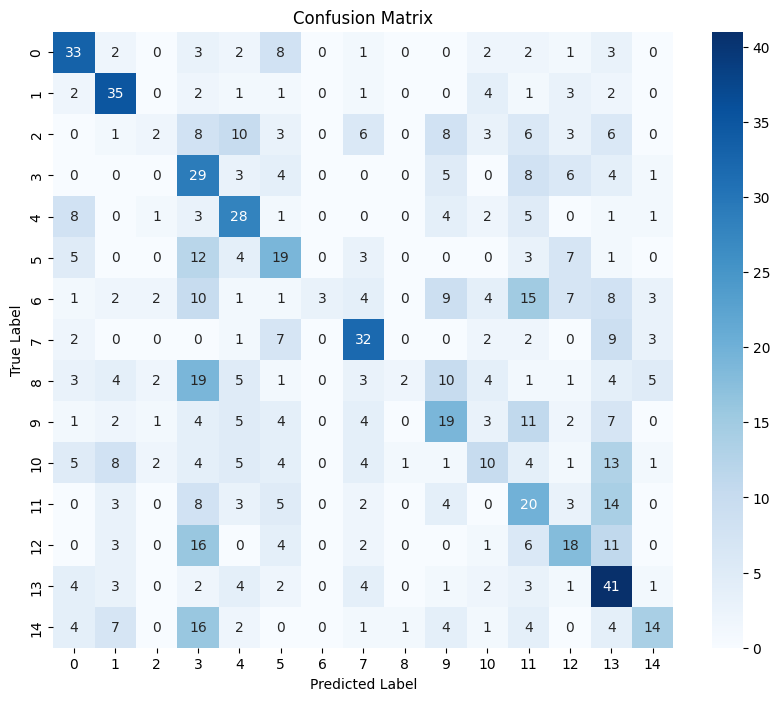

In [209]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

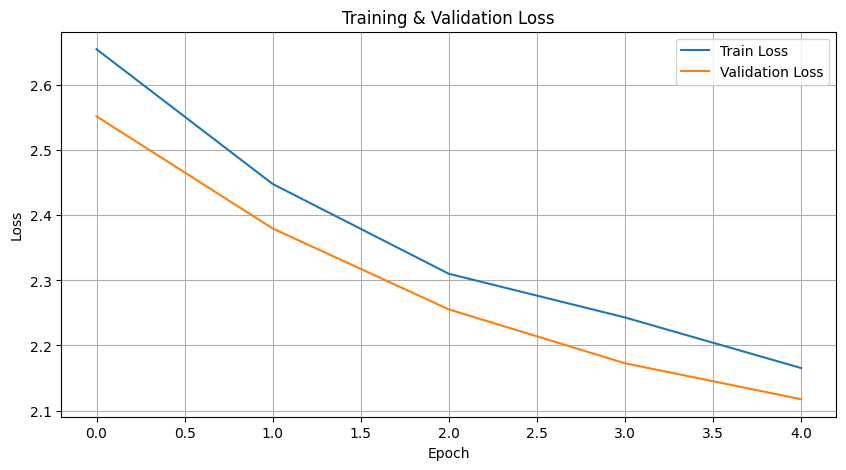

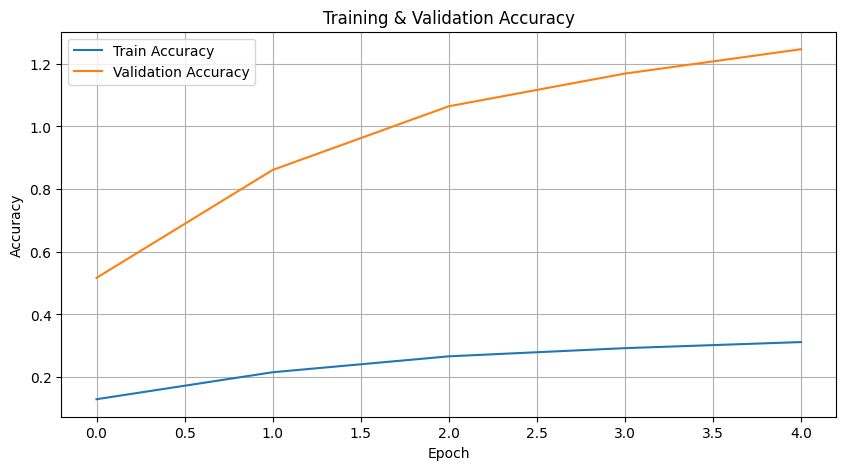

In [210]:
# Krzywa strat
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Krzywa dokładności
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()
